In [1]:
import os
from collections import Counter
# import rdata
import pyreadr
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from astral import LocationInfo, sun
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
from timezonefinder import TimezoneFinder
from zoneinfo import ZoneInfo
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from multiprocessing import Process, Queue, Event

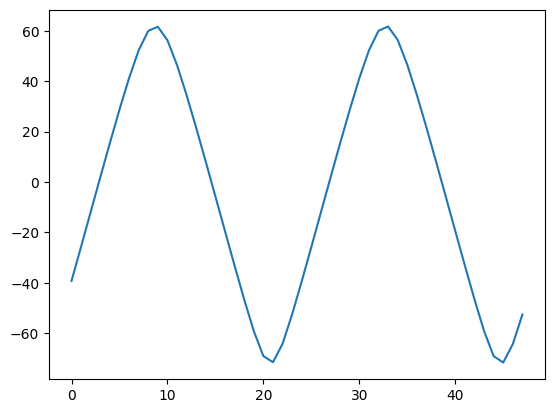

In [2]:

from astropy.time import TimeDelta
x = list(range(48))
y = []
loc = coord.EarthLocation(lon=50 * u.deg, lat=5 * u.deg)
for i in x:
    time = Time('1999-01-01T00:00:00.123456789') + TimeDelta(i * 3600, format="sec")
    altaz = coord.AltAz(location=loc, obstime=time)
    sun = coord.get_sun(time)
    sun.transform_to(altaz).alt
    y.append(float(sun.transform_to(altaz).alt / u.deg))

import matplotlib.pyplot as plt
plt.plot(x, y)

In [2]:
def get_thresholds(target_species_scores, n_sweep_steps):
    valid_mask = ~np.isnan(target_species_scores)
    return np.linspace(np.min(target_species_scores[valid_mask]), np.max(target_species_scores[valid_mask]), n_sweep_steps)
    # return np.percentile(target_species_scores[valid_mask], np.linspace(0, 100, n_sweep_steps))

In [4]:
target_species_out = "lynx"
output_path = os.path.join("data", "metadata_iwildcam_2022_tmp_v5.RData")
output_table_path = os.path.join("data", "iwildcam_2022_results_v5.csv")
# assert not os.path.exists(output_path)

tf = TimezoneFinder()


# dfo = rdata.read_rda(os.path.join("data", "metadata_Ain.RData"))["allfiles"]
dfn = pd.read_csv(os.path.join("..", "data", "iwildcam_2022_crops_bioclip_inference_logits_v3.csv"))
dfn["datetime"] = pd.to_datetime(dfn["datetime"])
df_dem = pd.read_csv(os.path.join("..", "data", "iwildcam_2022_dem.csv"))
df_landcover = pd.read_csv(os.path.join("..", "data", "iwildcam_2022_landcover.csv"))

dfn.merge(df_dem, left_on="location", right_on="name").merge(df_landcover, left_on="location", right_on="name")

# # compute time since sunrise/sunset
# for _, row in dfn:
#     loc = LocationInfo(latitude=row["latitude"], longitude=row["longitude"])
#     s = sun(loc.observer, date=row["datetime"])


# TODO: re-enable
# # compute sun altitude above horizon in degrees
# alt = []
# for _, row in dfn.iterrows():
# # for _, row in dfn.sample(frac=1).iterrows():  # TODO: remove
#     if np.isfinite([row["latitude"], row["longitude"]]).all():
#         loc = coord.EarthLocation(lon=row["longitude"] * u.deg, lat=row["latitude"] * u.deg)
#         local_time = row["datetime"].to_pydatetime().replace(tzinfo=ZoneInfo(tf.timezone_at(lng=row["longitude"], lat=row["latitude"])))
#         time = Time(local_time)
#         altaz = coord.AltAz(location=loc, obstime=time)
#         sun = coord.get_sun(time)
#         alt += [float(sun.transform_to(altaz).alt / u.deg)]
#         # filepath = f"/data/vision/beery/scratch/data/iwildcam_unzipped/train/{row['file_name']}"
#         # print(alt[-1], local_time, filepath)
#     else:
#         alt += [None]
# dfn["sun_alt"] = alt

print(f"number of sites: {dfn['location'].nunique()}")
# print(f"number of observations: {Counter(dfo['observed'].tolist())}")

pred_prefix = "logit_"  # "pred_" or "logit_"
n_sweep_steps = 11
calibration_min_samples = 10

# target_species_list = None
target_species_list = [e.replace(" ", "_") for e in [
    "tayassu pecari",
    "meleagris ocellata",
    "equus quagga",
    "madoqua guentheri",
    "leopardus pardalis",
    "giraffa camelopardalis",
    "sus scrofa",
    "mazama pandora",
    # "litocranius walleri",
    # "formicarius analis",
    # "tragulus javanicus",
    # "tupinambis teguixin",
]]

best_threshold = {}

# split along sequence IDs
train_seq, test_seq = train_test_split(dfn["seq_id"].unique(), test_size=0.8, random_state=42)
df_train, df_test = dfn[dfn["seq_id"].isin(train_seq)], dfn[dfn["seq_id"].isin(test_seq)]

# for target_species in target_species_list:
#     gt = df_train[f"gt_{target_species}"]
#     scores = df_train[f"{pred_prefix}{target_species}"]
#     pos_scores = scores[ df_train[f"gt_{target_species}"]]
#     neg_scores = scores[~df_train[f"gt_{target_species}"]]
#     assert len(pos_scores) >= calibration_min_samples and len(neg_scores) > calibration_min_samples
#     f1 = []
#     for s in scores:
#         tp = ((scores >= s) &  gt).sum()
#         fp = ((scores >= s) & ~gt).sum()
#         fn = ((scores <  s) &  gt).sum()
#         tn = ((scores <  s) & ~gt).sum()
#         recall = tp / (tp + fn)
#         precision = tp / (tp + fp)
#         f1 += [(2 * precision * recall) / (precision + recall)]
#     f1 = np.array(f1)
#     assert len(f1[np.isfinite(f1)]) > 0
#     best_score = np.mean(scores[f1 == f1[np.isfinite(f1)].max()])
#     print(f"Best threshold for species '{target_species}' is {best_score:.2f} at f1 of {f1[np.isfinite(f1)].max():.2f}")
#     best_threshold[target_species] = best_score

# use only test data to continue
dfn = df_test

output_table = []


available_species = [e.replace(pred_prefix, "") for e in dfn.columns if e.startswith(pred_prefix) and e != f"{pred_prefix}empty"]
if target_species_list is None:
    target_species_list = available_species

import matplotlib.pyplot as plt
# for target_species in target_species_list:
#     fig, (ax1, ax2) = plt.subplots(1, 2, )
#     target_species_scores = dfn[f"{pred_prefix}{target_species}"]
#     valid_mask = ~np.isnan(target_species_scores)

#     thresholds = get_thresholds(target_species_scores, n_sweep_steps)
#     ax1.hist(target_species_scores[valid_mask &  dfn[f"gt_{target_species}"]], bins=20, alpha=0.5, label="True")
#     ax1.hist(target_species_scores[valid_mask & ~dfn[f"gt_{target_species}"]], bins=20, alpha=0.5, label="False")
#     ax1.plot(thresholds, [0] * len(thresholds), 'o', label="Thresholds")
    
#     precision = []
#     recall = []
#     for threshold in thresholds:
#         predicted = np.array([target_species_out if row[f"{pred_prefix}{target_species}"] >= threshold else "other" for _, row in dfn.iterrows()])
#         tp = ((predicted == target_species_out) &  dfn[f"gt_{target_species}"]).sum()
#         fp = ((predicted == target_species_out) & ~dfn[f"gt_{target_species}"]).sum()
#         fn = ((predicted != target_species_out) &  dfn[f"gt_{target_species}"]).sum()
#         tn = ((predicted != target_species_out) & ~dfn[f"gt_{target_species}"]).sum()
#         r = tp / (tp + fn)
#         p = tp / (tp + fp)
#         if np.isfinite([r, p]).all():
#             recall += [r]
#             precision += [p]

#     ax2.plot(recall, precision)
#     ax1.set_xlabel("Logit")
#     ax1.set_ylabel("Number of Observations")
#     ax2.set_xlabel("Recall")
#     ax2.set_ylabel("Precision")
#     fig.suptitle(target_species)
#     os.makedirs("figures/scores", exist_ok=True)
#     plt.savefig(f"figures/scores/{target_species}.pdf", bbox_inches="tight", transparent=True)

number of sites: 323


In [6]:
for target_species in target_species_list:
    target_species_scores = dfn[f"{pred_prefix}{target_species}"]
    valid_mask = ~np.isnan(target_species_scores)
    if np.sum(valid_mask) < n_sweep_steps:
        print(f"Species '{target_species}' has to few samples, skipping...")
        continue
    thresholds = [*get_thresholds(target_species_scores, n_sweep_steps), best_threshold[target_species], float("NaN")]
    threshold_types = ["sampled"] * (len(thresholds) - 2) + ["calibrated"] + ["gt"]
    for threshold, threshold_type in zip(thresholds, threshold_types):
        dfn["DateTimeOriginal"] = dfn["datetime"]
        print("Removing", dfn["DateTimeOriginal"].isna().sum(), "missing datetime values")
        dfn = dfn[~dfn["DateTimeOriginal"].isna()]

        if threshold_type != "gt":
            dfn["predicted"] = np.array([target_species_out if row[f"{pred_prefix}{target_species}"] >= threshold else "other" for _, row in dfn.iterrows()])
        else:
            dfn["predicted"] = np.array([target_species_out if row[f"gt_{target_species}"] else "other" for _, row in dfn.iterrows()])

        print((dfn["predicted"] == target_species_out).sum(), f"positive observations with threshold {threshold}")


        tp = ((dfn["predicted"] == target_species_out) &  dfn[f"gt_{target_species}"]).sum()
        fp = ((dfn["predicted"] == target_species_out) & ~dfn[f"gt_{target_species}"]).sum()
        fn = ((dfn["predicted"] != target_species_out) &  dfn[f"gt_{target_species}"]).sum()
        tn = ((dfn["predicted"] != target_species_out) & ~dfn[f"gt_{target_species}"]).sum()

        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = (2 * precision * recall) / (precision + recall)

        print(f"{target_species} precision {precision:.2f} recall {recall:.2f} f1 {f1:.2f}")

        
        start_date, end_date = dfn.datetime.min(), dfn.datetime.max()
        # sample data
        df = pd.DataFrame(pd.date_range(start_date, end_date), columns=["datetime"])
        # groupby your key and freq
        g = df.groupby(pd.Grouper(key="datetime", freq="ME"))
        # groups to a list of dataframes with list comprehension
        dfs = [group for _,group in g]

        print(dfs)
        quit()
        


        model_comparison_df = None
        if model_comparison_df is not None:
            model_comparison_df["species"] = target_species
            model_comparison_df["threshold"] = threshold
            model_comparison_df["threshold_type"] = threshold_type
            model_comparison_df["tp"] = tp
            model_comparison_df["fp"] = fp
            model_comparison_df["fn"] = fn
            model_comparison_df["tn"] = tn
            model_comparison_df["precision"] = precision
            model_comparison_df["recall"] = recall
            model_comparison_df["f1"] = f1

            print("Successfully got model comparison df")
            print(model_comparison_df)

            output_table.append(model_comparison_df)
            pd.concat(output_table).to_csv(output_table_path)

Removing 0 missing datetime values
88898 positive observations with threshold -8.112890243530273
tayassu_pecari precision 0.05 recall 0.87 f1 0.09
[              datetime
0  2013-01-02 16:34:53
1  2013-01-03 16:34:53
2  2013-01-04 16:34:53
3  2013-01-05 16:34:53
4  2013-01-06 16:34:53
5  2013-01-07 16:34:53
6  2013-01-08 16:34:53
7  2013-01-09 16:34:53
8  2013-01-10 16:34:53
9  2013-01-11 16:34:53
10 2013-01-12 16:34:53
11 2013-01-13 16:34:53
12 2013-01-14 16:34:53
13 2013-01-15 16:34:53
14 2013-01-16 16:34:53
15 2013-01-17 16:34:53
16 2013-01-18 16:34:53
17 2013-01-19 16:34:53
18 2013-01-20 16:34:53
19 2013-01-21 16:34:53
20 2013-01-22 16:34:53
21 2013-01-23 16:34:53
22 2013-01-24 16:34:53
23 2013-01-25 16:34:53
24 2013-01-26 16:34:53
25 2013-01-27 16:34:53
26 2013-01-28 16:34:53
27 2013-01-29 16:34:53
28 2013-01-30 16:34:53
29 2013-01-31 16:34:53,               datetime
30 2013-02-01 16:34:53
31 2013-02-02 16:34:53
32 2013-02-03 16:34:53
33 2013-02-04 16:34:53
34 2013-02-05 16:34:53


KeyboardInterrupt: 

: 

[  3 350  10 176 133 336 372 514 366 474 256 337 271 306 501  71 171 361
 431 531 123 262 199 177 408  90 333 105  28 119 345 140 210 532 130 511
 392 464 495 519  31 470 418 287 499 444 529 126 295  57 451 263 165 330
 266   8 466 290 410  85 131 416 242 291  25 456 247 156 178  35 320  23
 497 443  87 312  72 313 284 218 220 453 449 115 166 419 238 362 349 503
 322 522 225 509 428 384 385  93 530 506 465  76  33 338 526 198 298 440
 283 237 316 212 127 258 149 301 469 157  91 170 226 504  66 110 512 129
 540  37 204 138 518  51 508  18 144 259 543 398  77 100 475 302  41 202
  14  65 275 496 403 541 155 132 383 395 268 186 484 442 103  19  60 415
 285 142 452  53 353 359 450 547 108 194 348 254 458 487 303  44 167 278
 528 339 231 480 477 245 386 282 369 538 551 379 363 356 524 387  73 422
 289 516  47 537 405   1 173 375 293 412 460 111 517 229 109 468 373 427
 473 542 521 489 169 445 502 249 340  81 406 315  16 471 112 482 121  22
 179 344 269 216 374 159 329 146 321 324 523  95 11

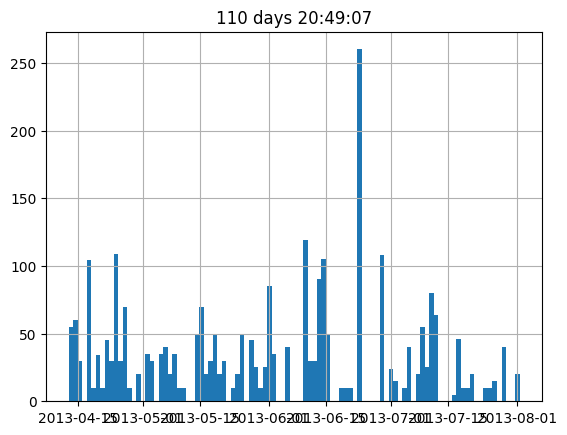

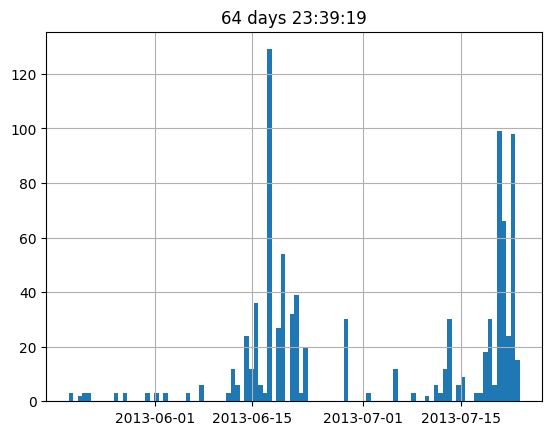

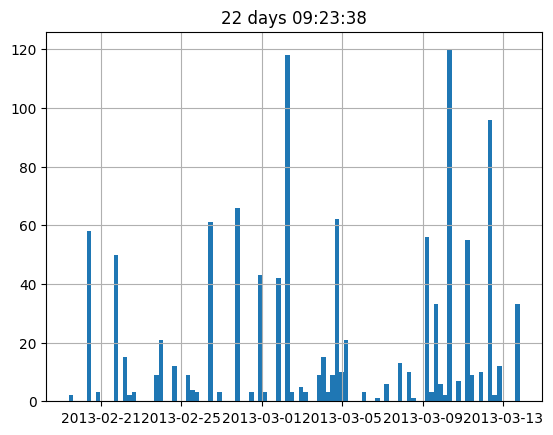

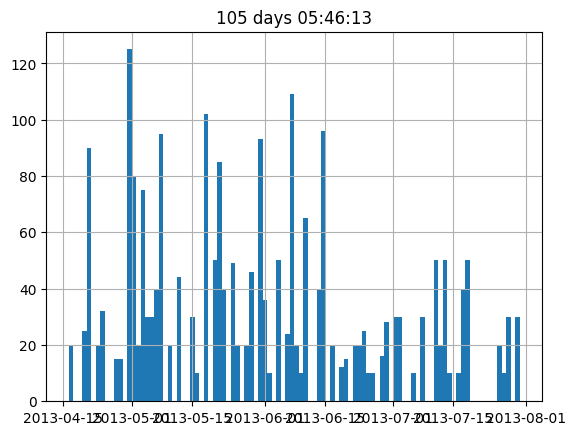

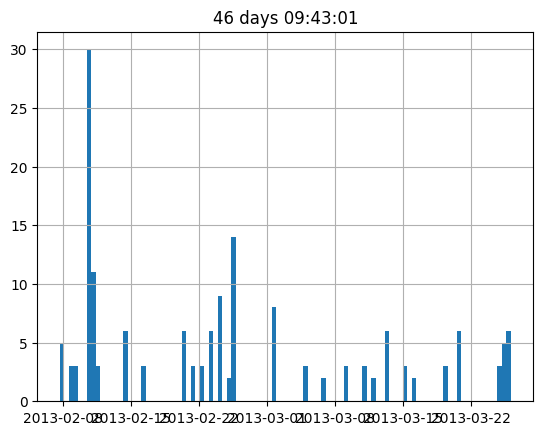

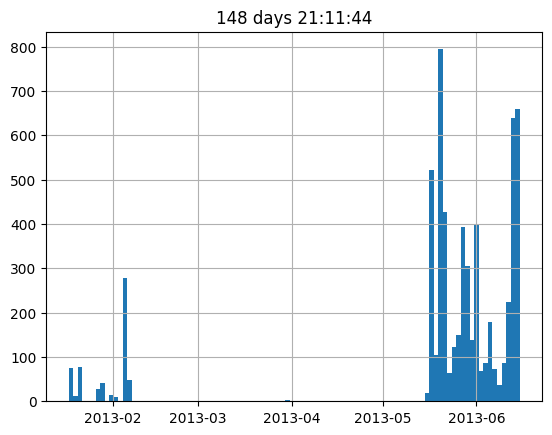

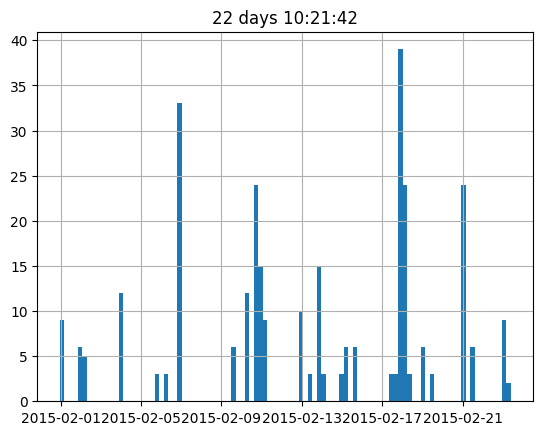

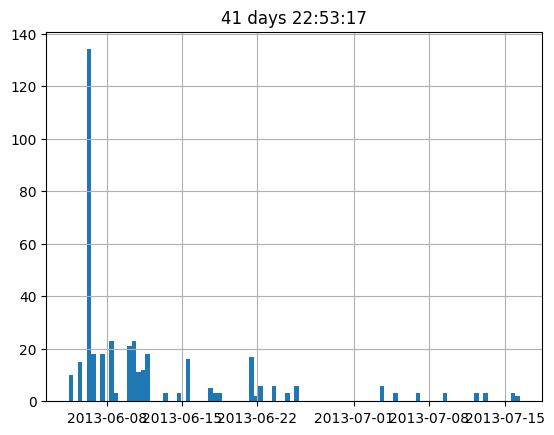

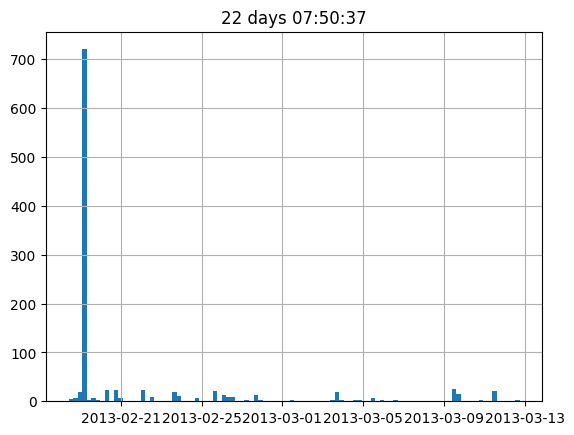

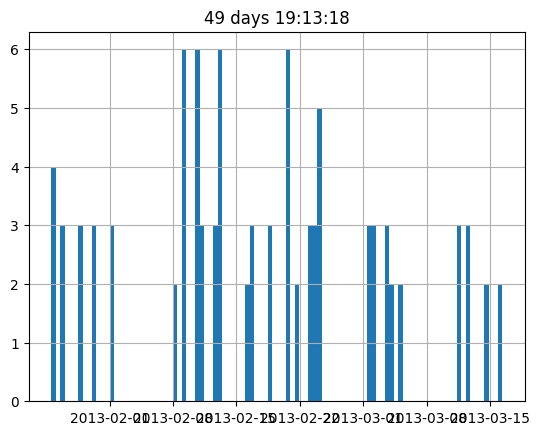

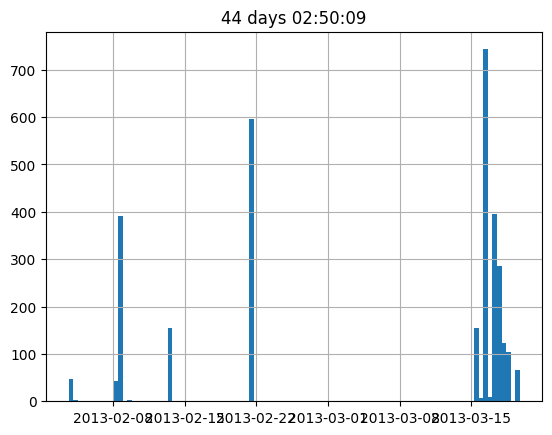

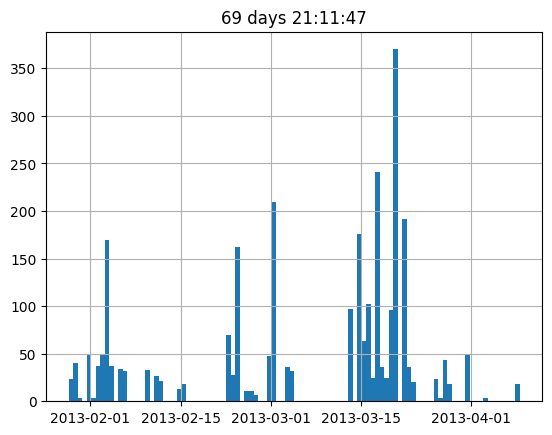

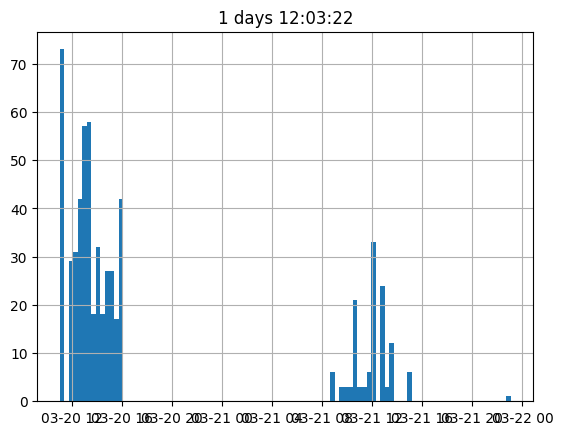

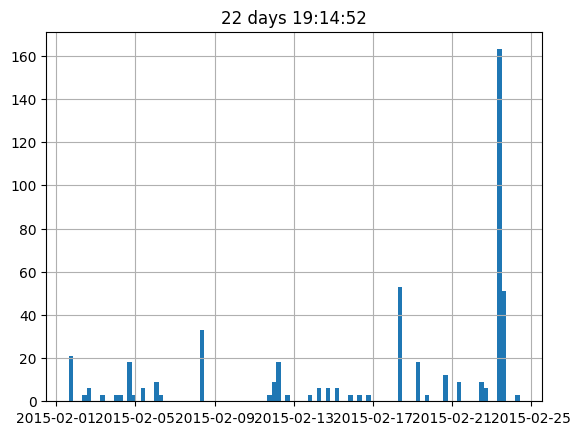

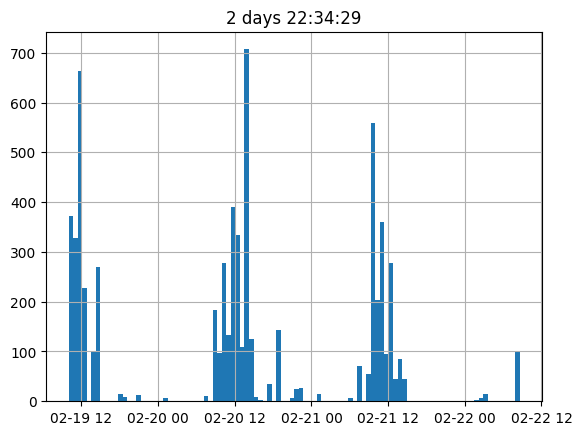

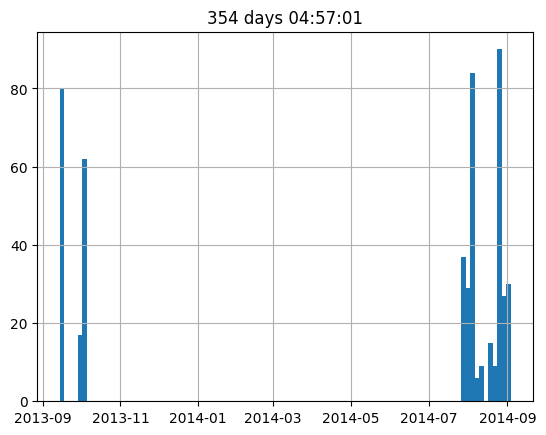

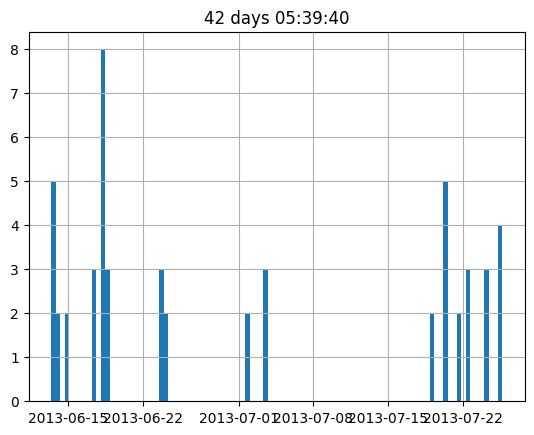

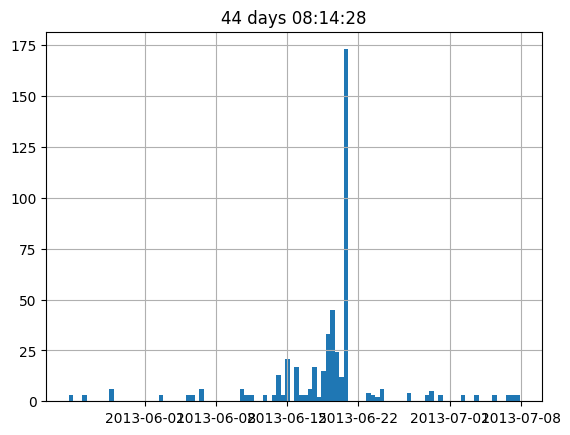

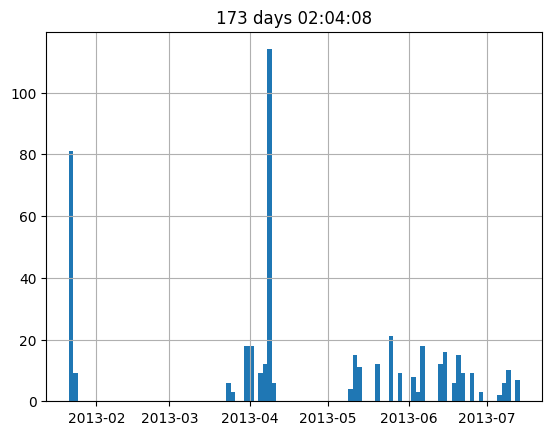

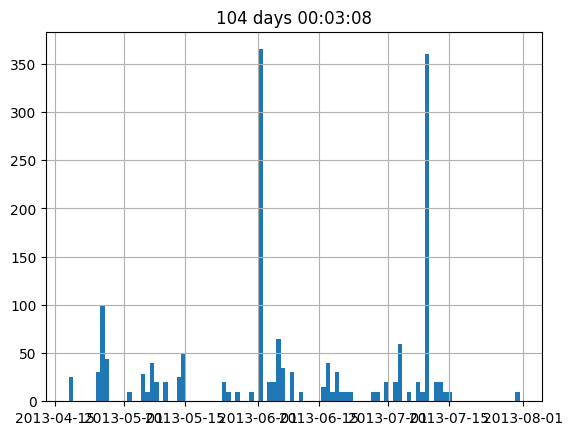

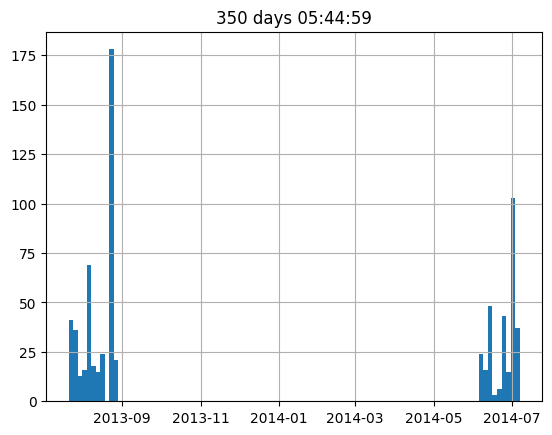

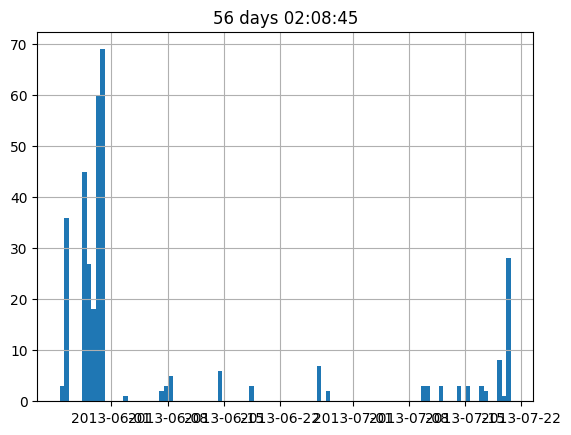

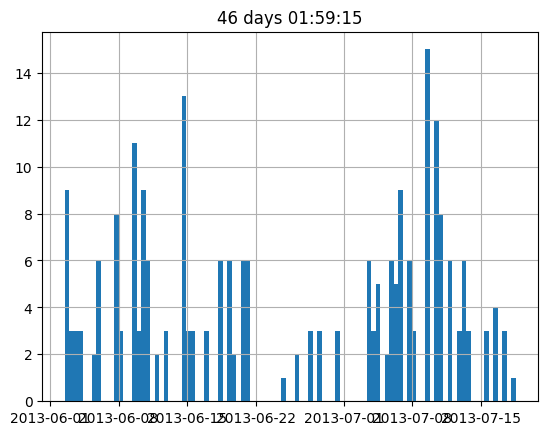

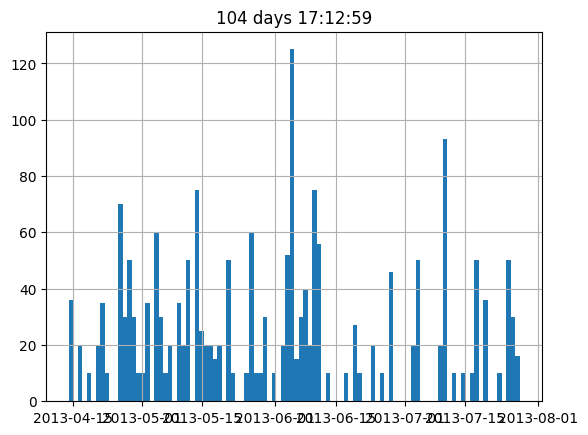

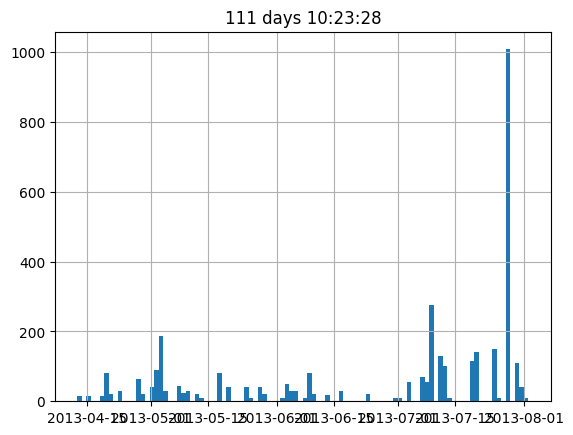

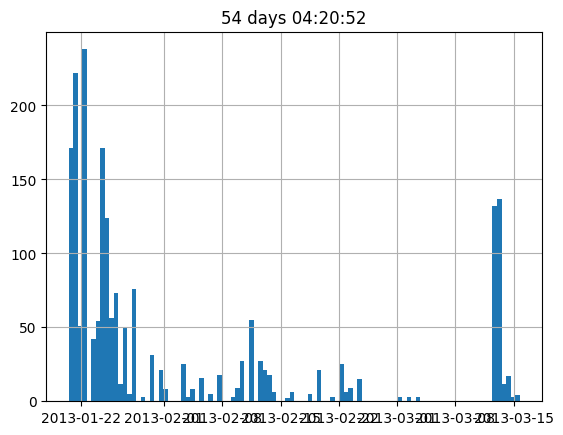

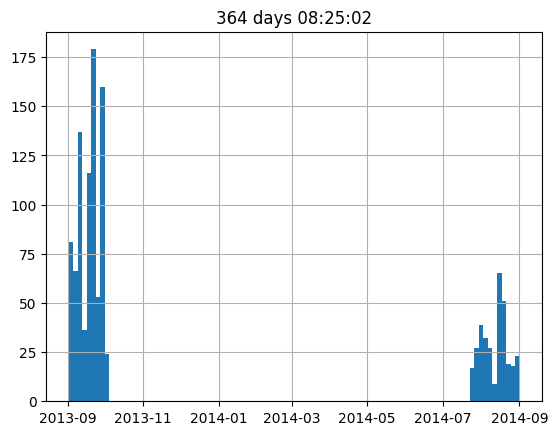

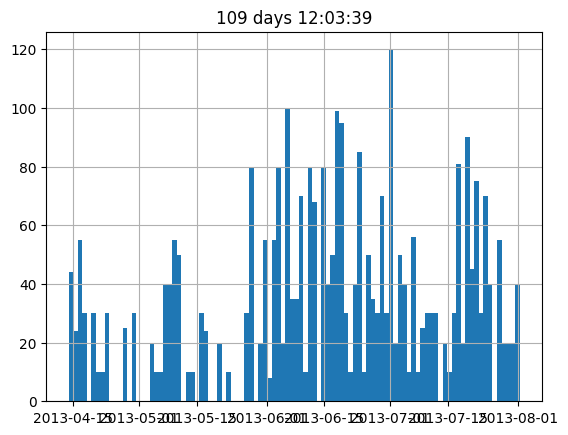

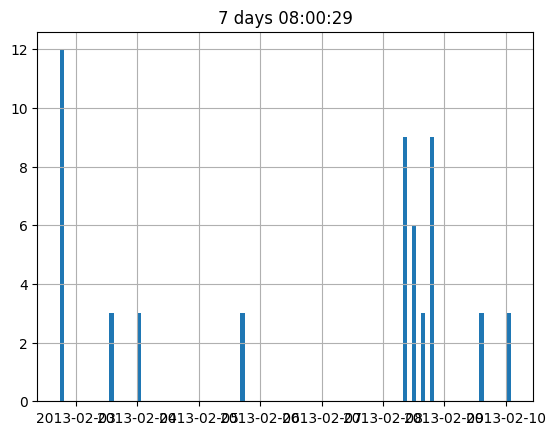

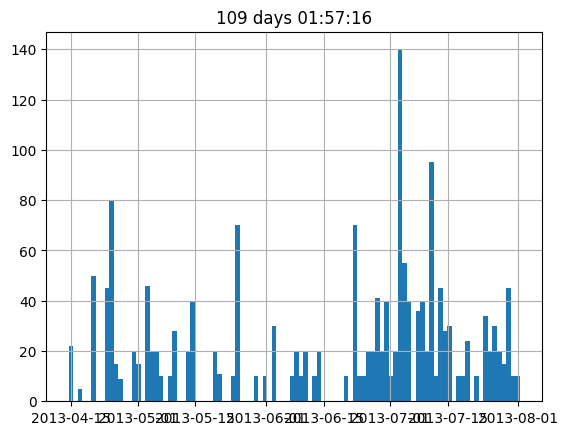

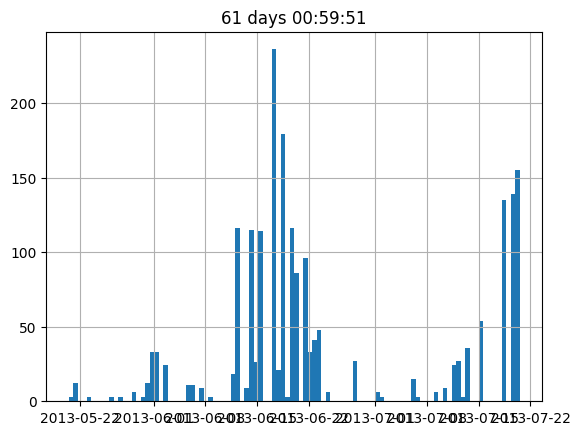

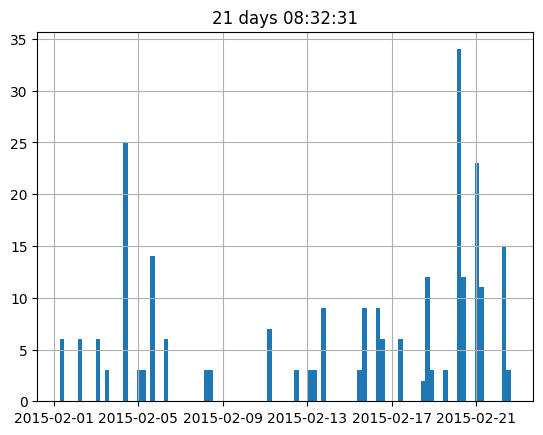

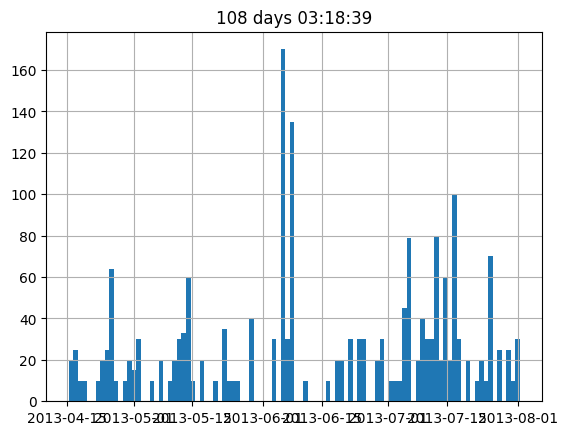

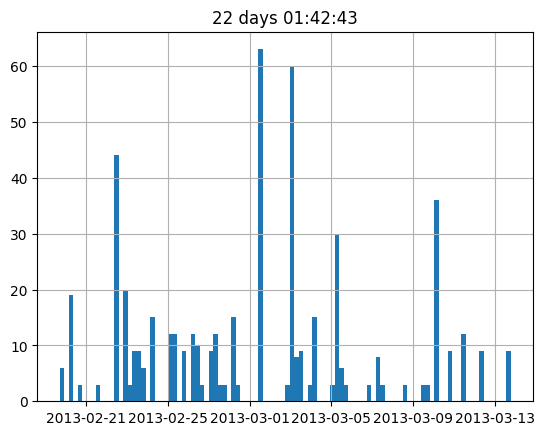

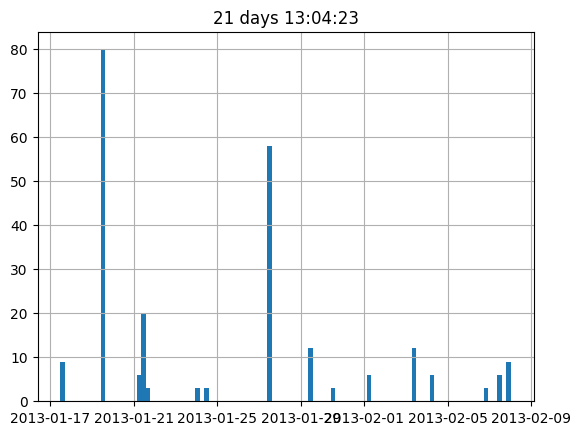

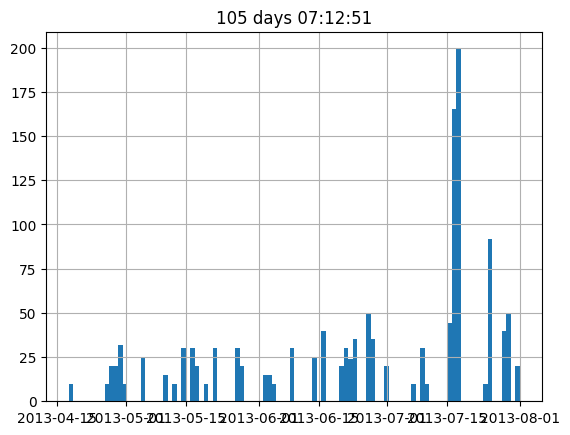

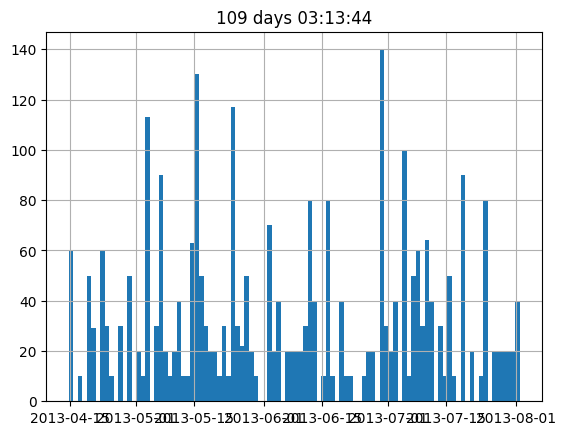

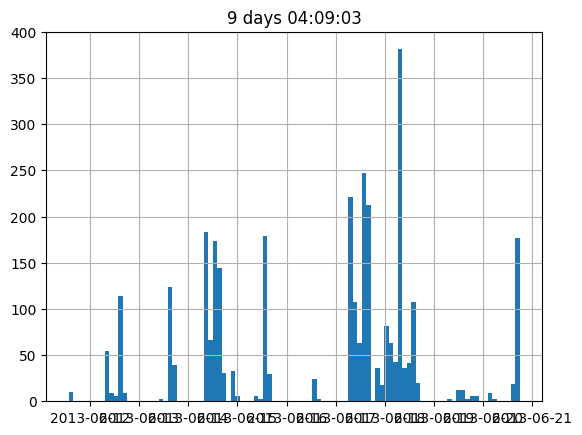

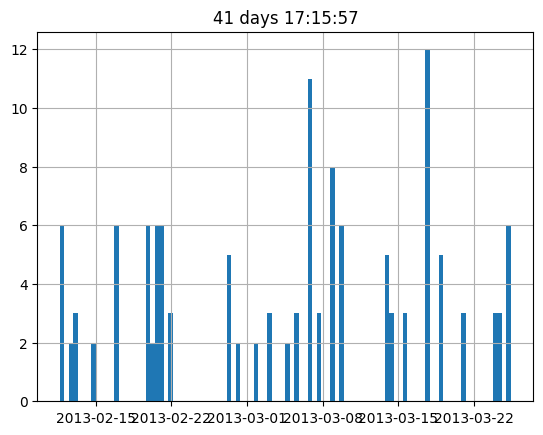

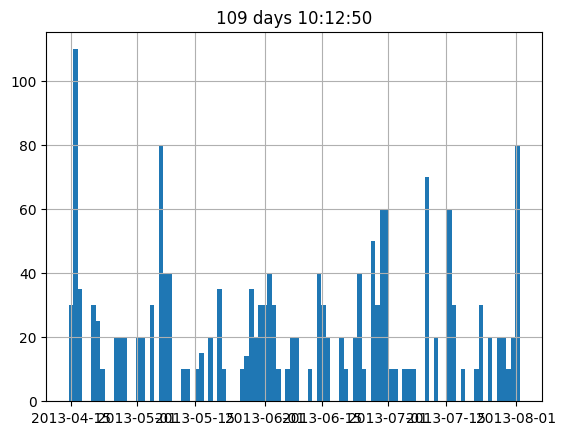

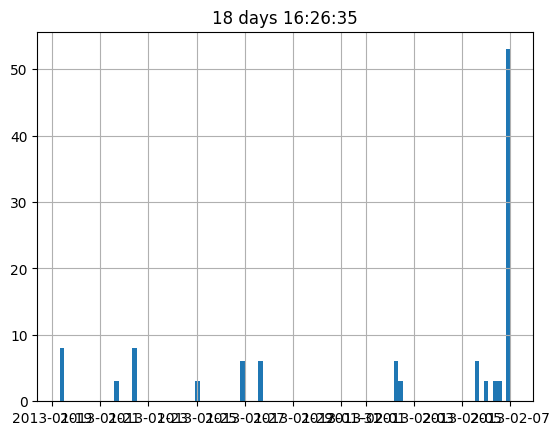

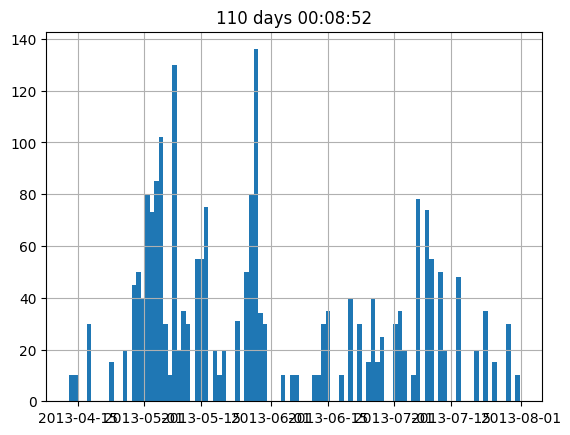

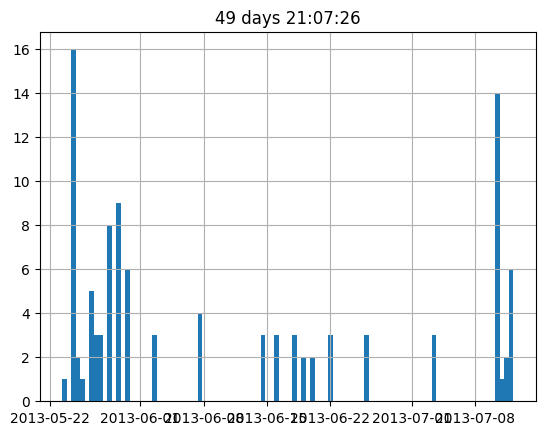

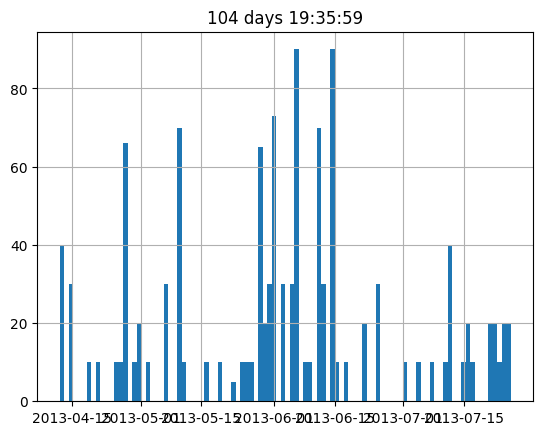

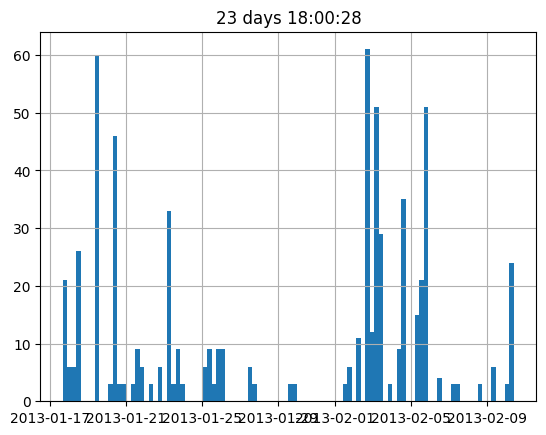

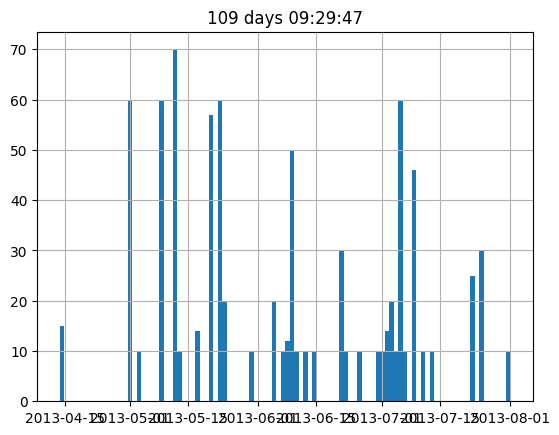

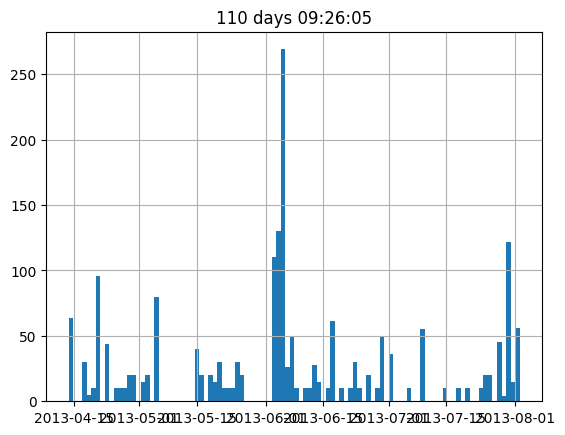

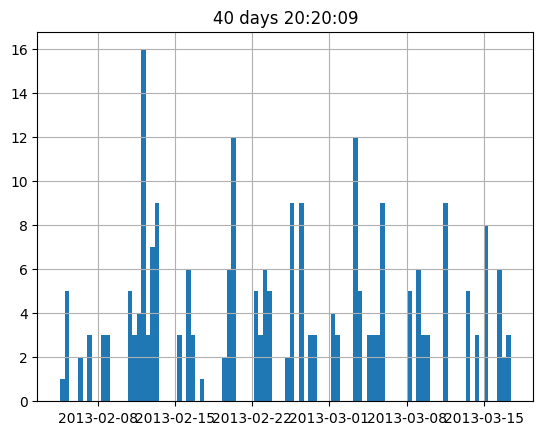

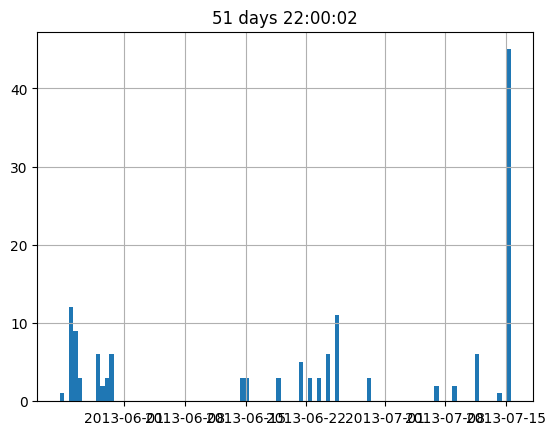

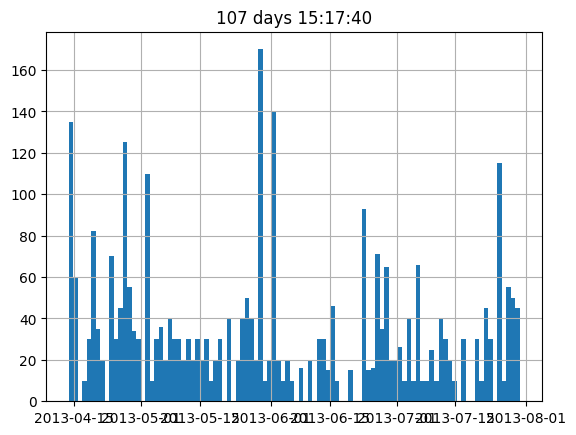

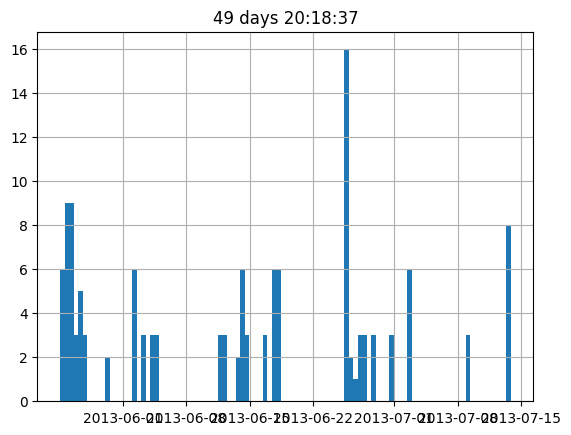

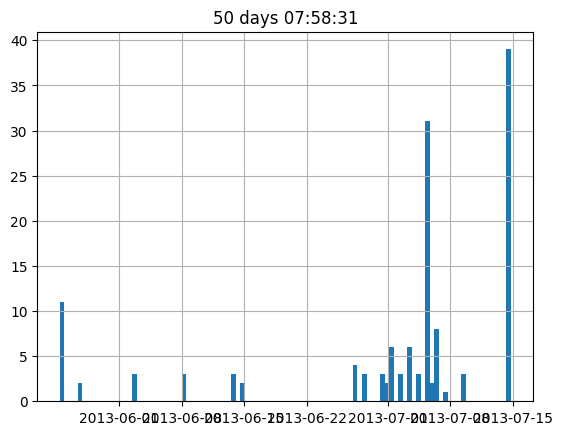

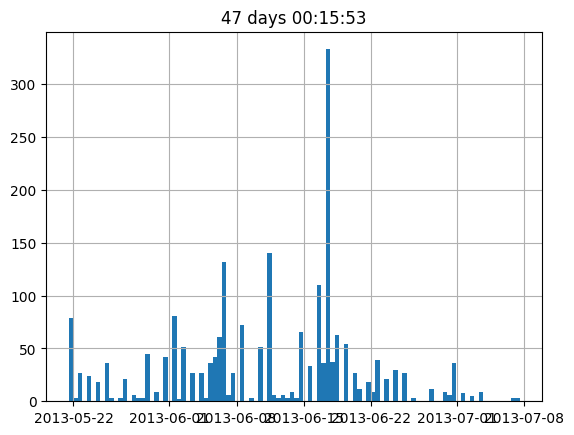

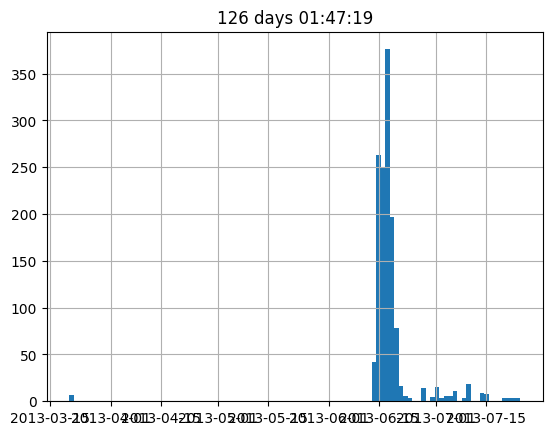

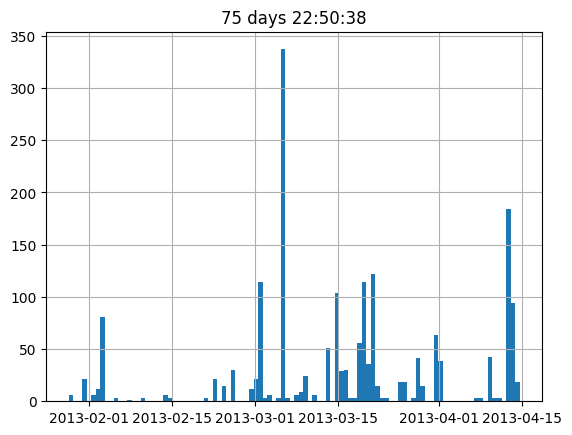

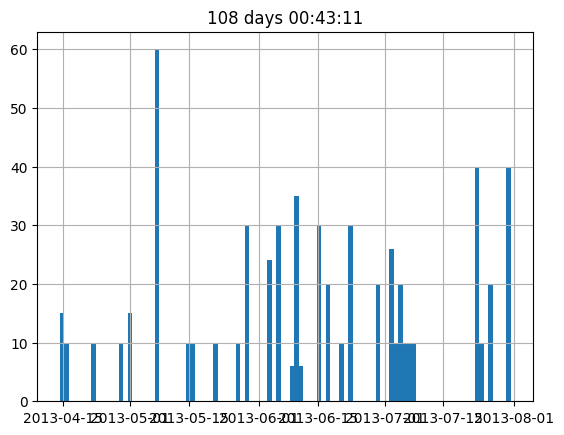

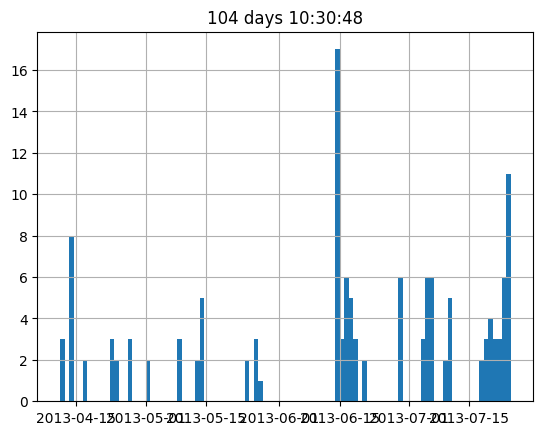

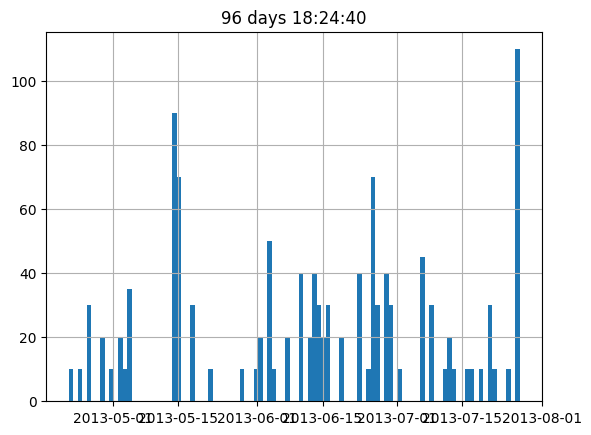

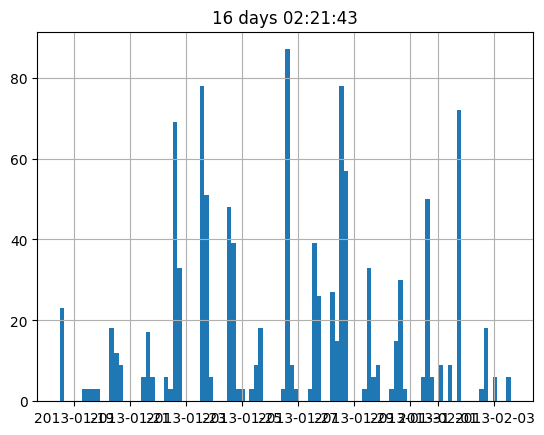

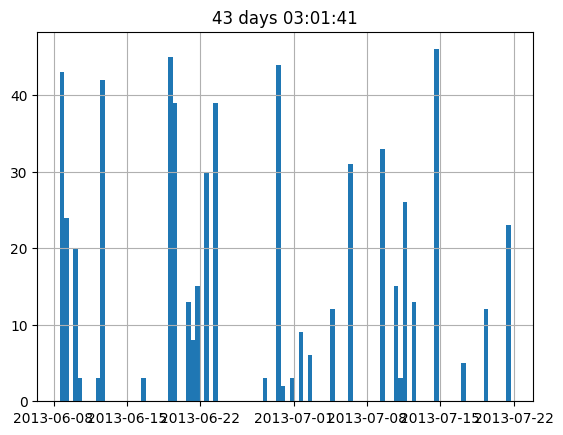

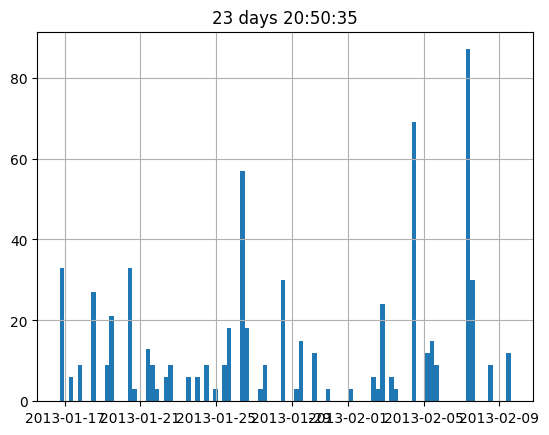

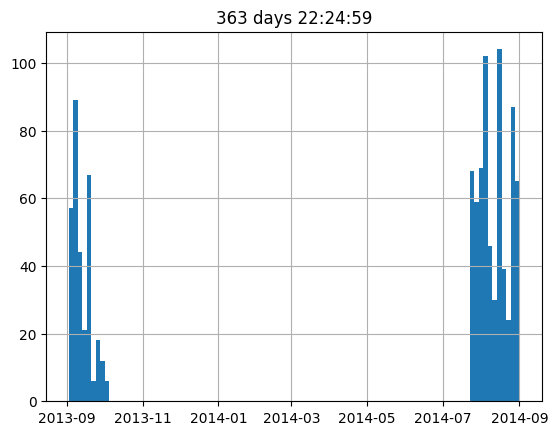

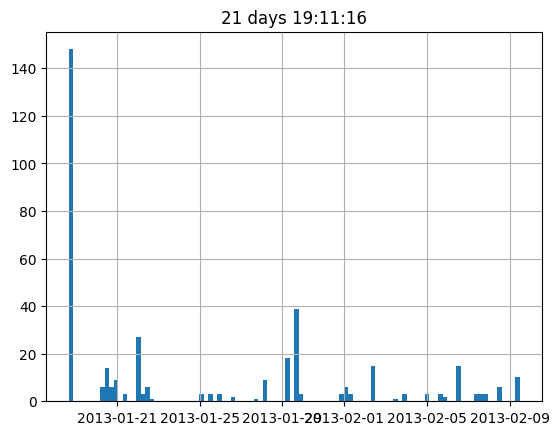

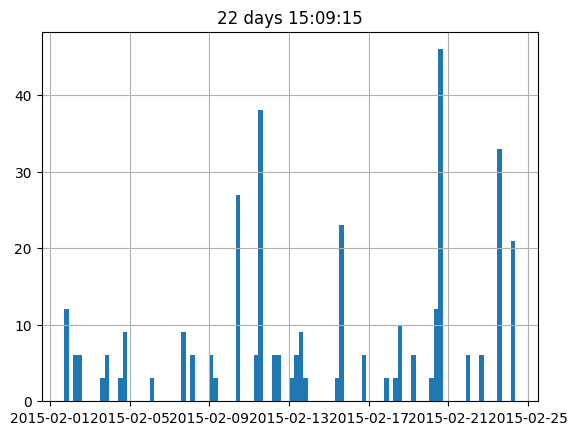

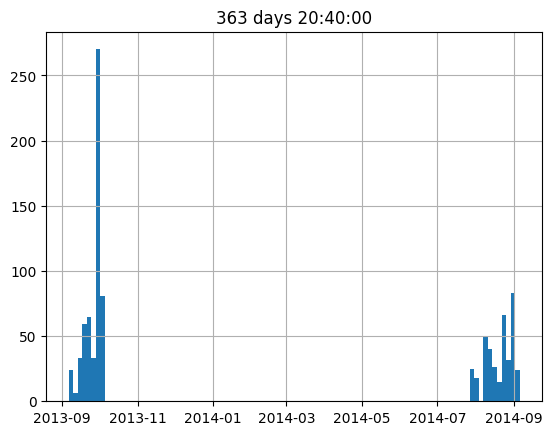

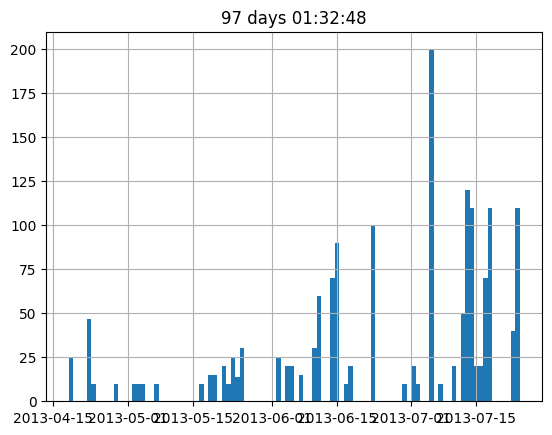

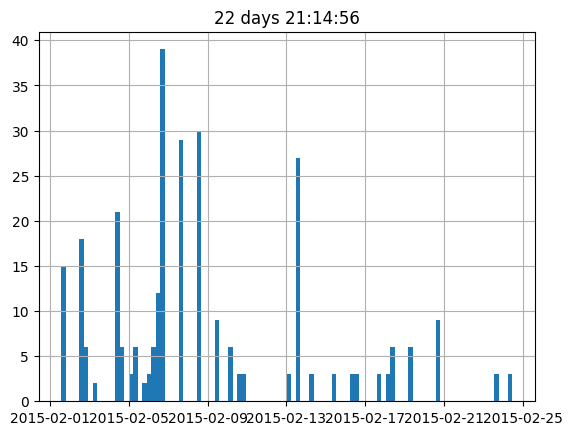

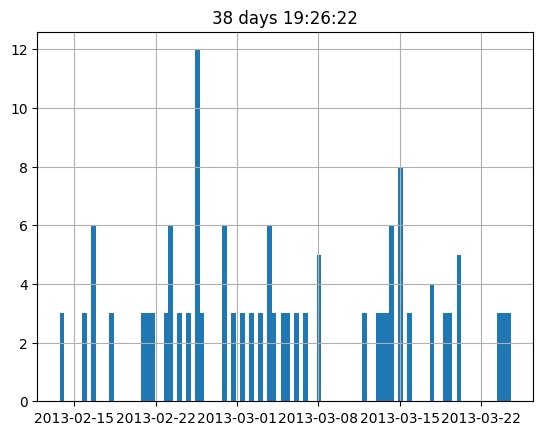

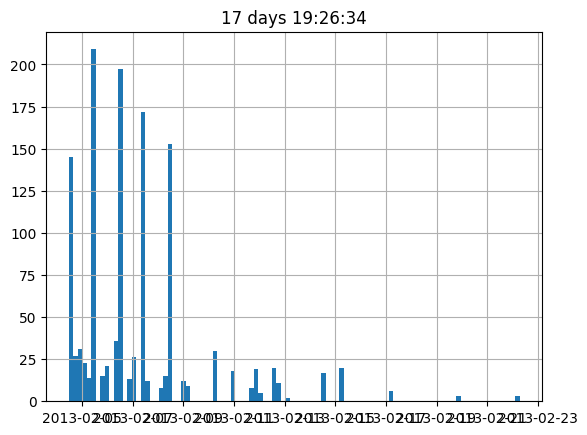

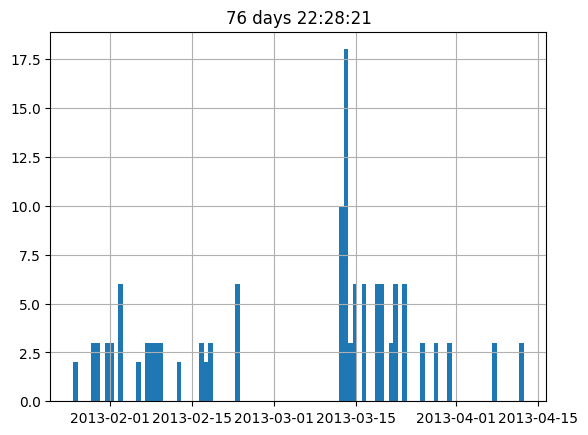

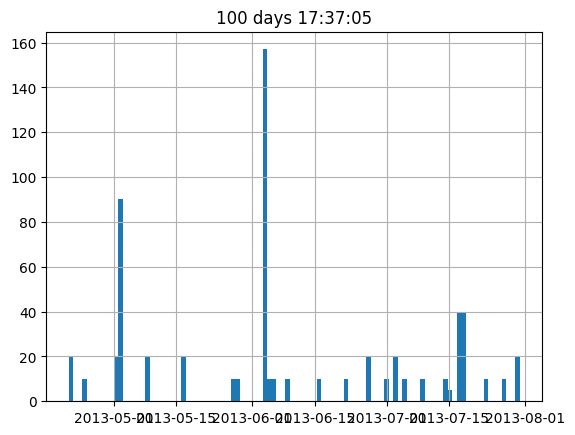

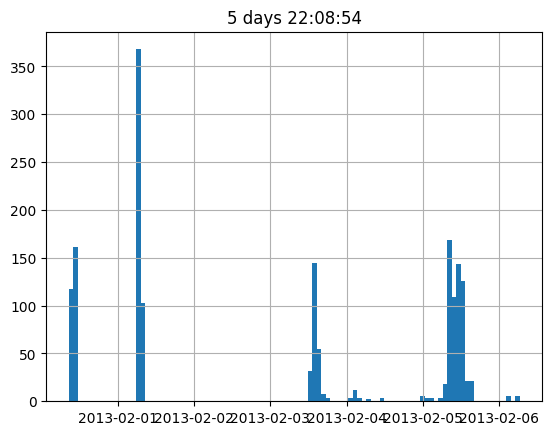

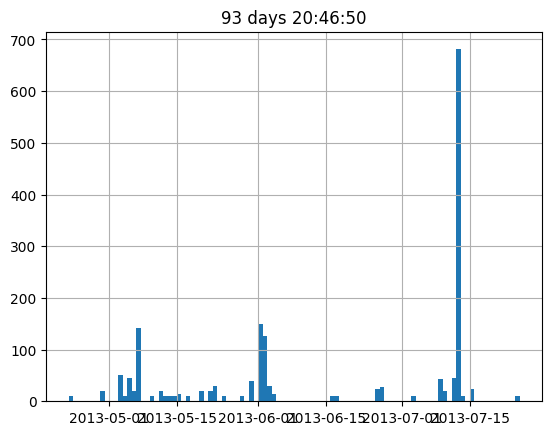

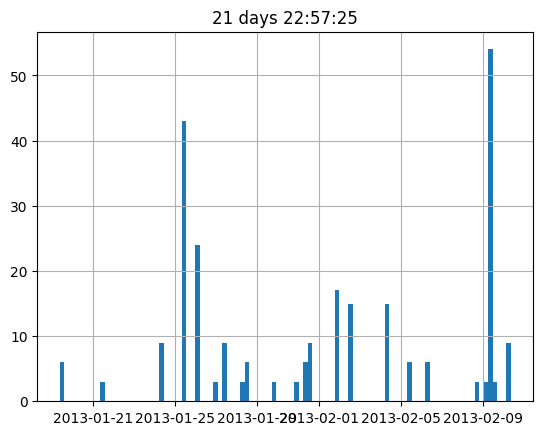

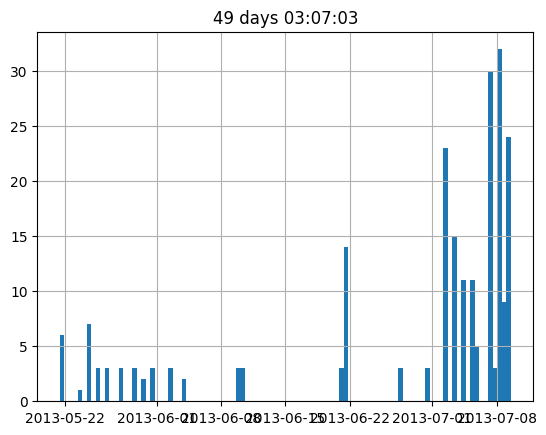

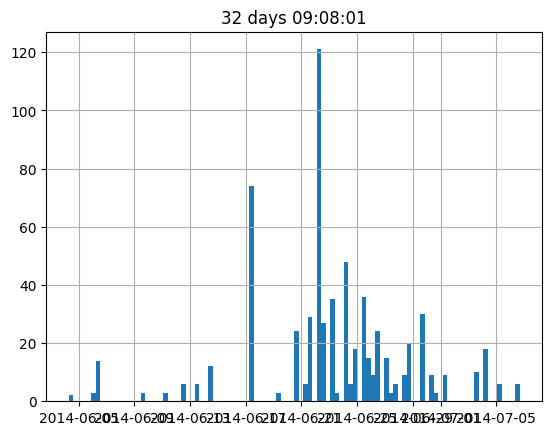

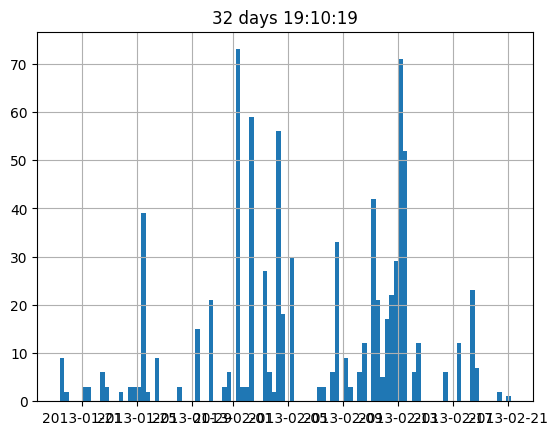

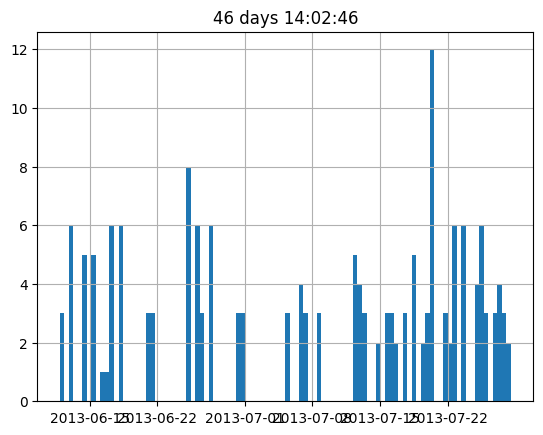

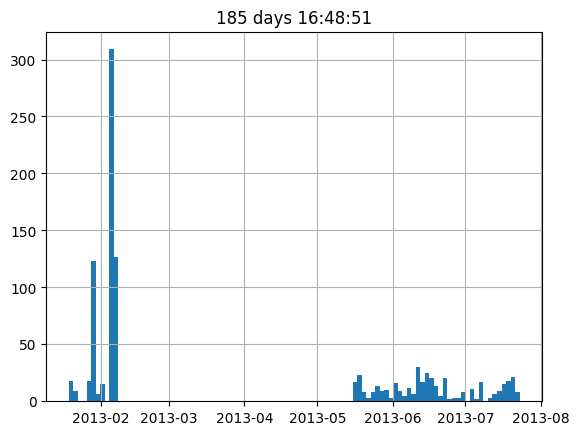

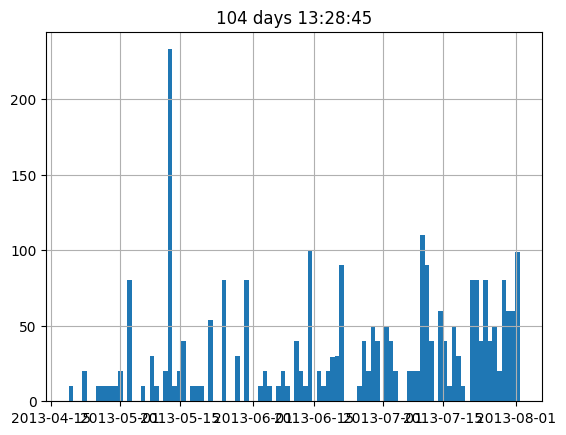

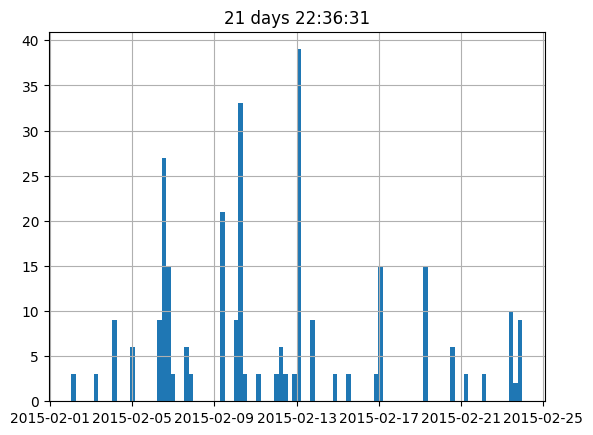

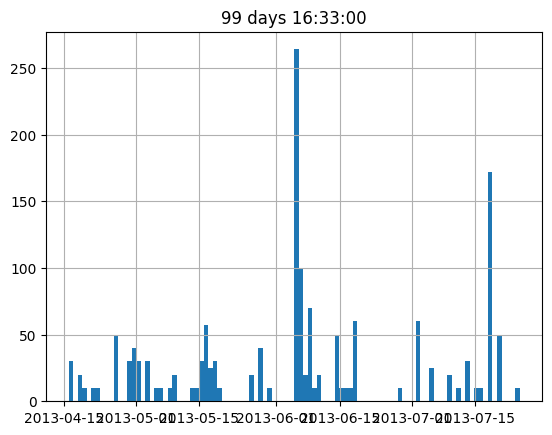

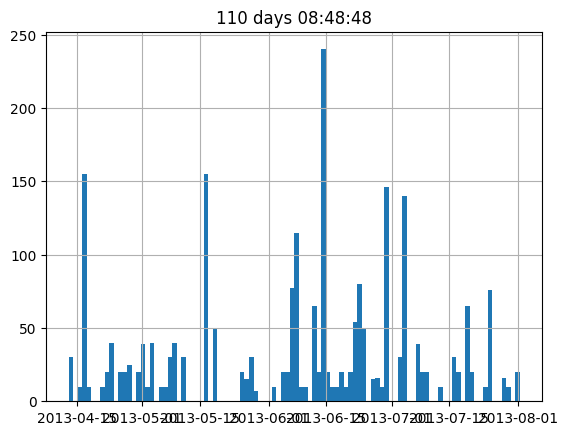

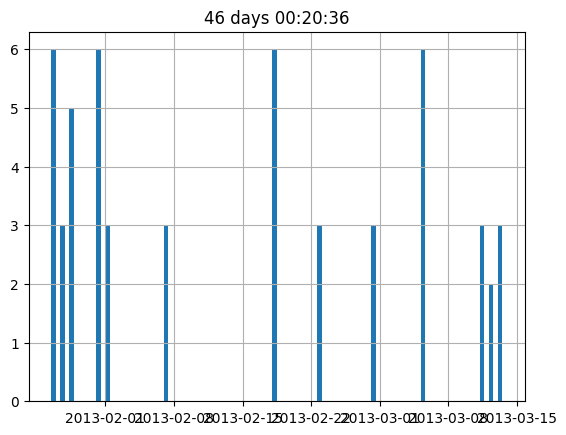

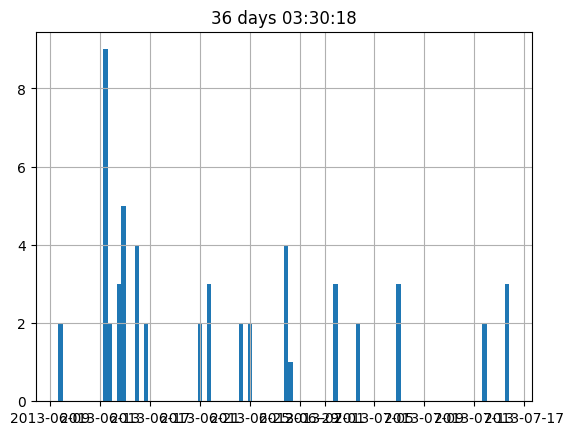

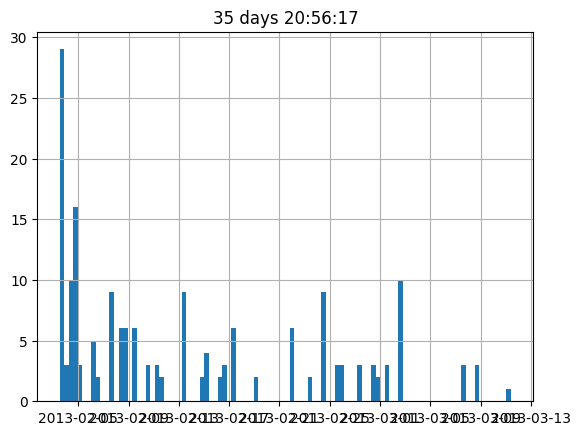

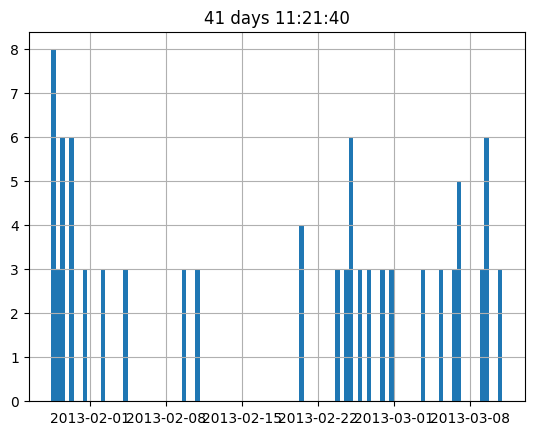

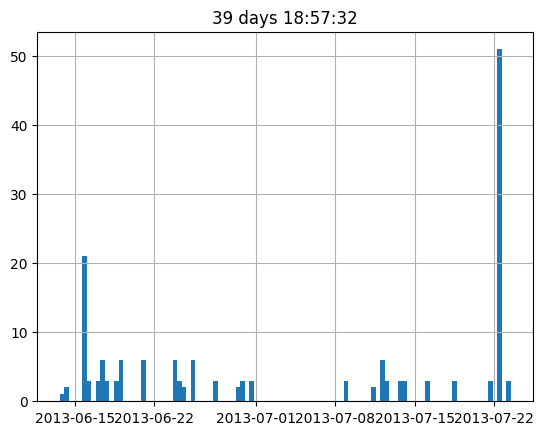

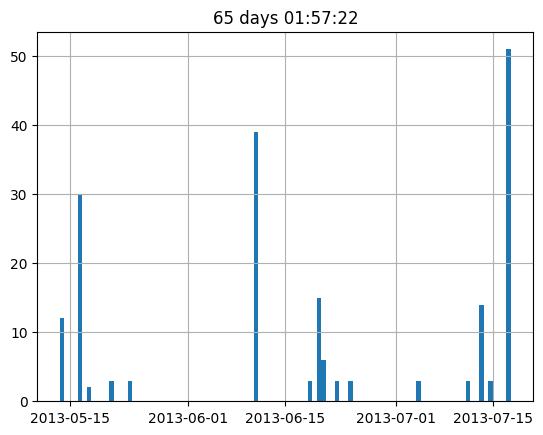

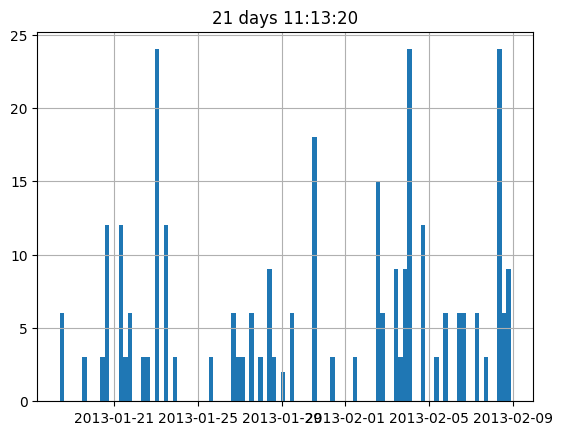

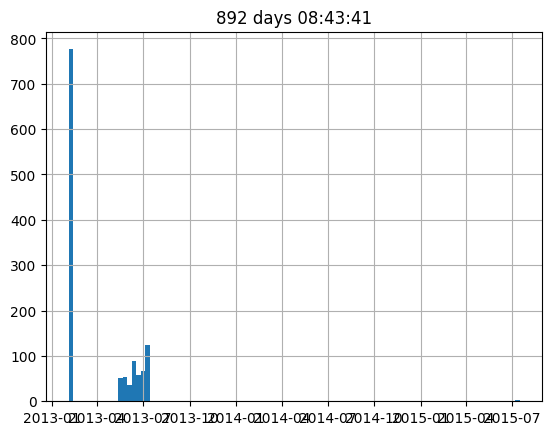

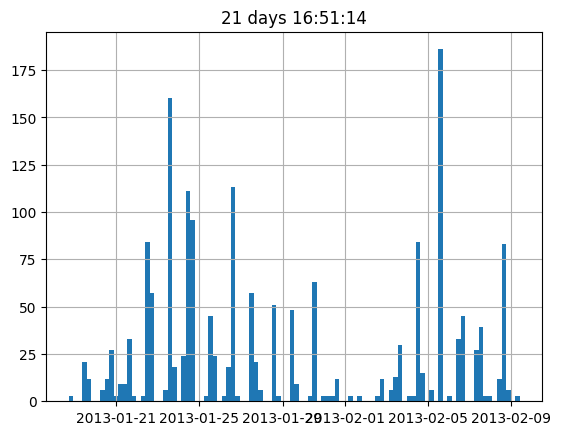

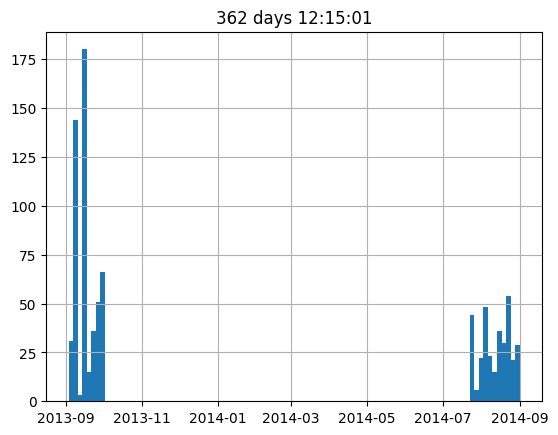

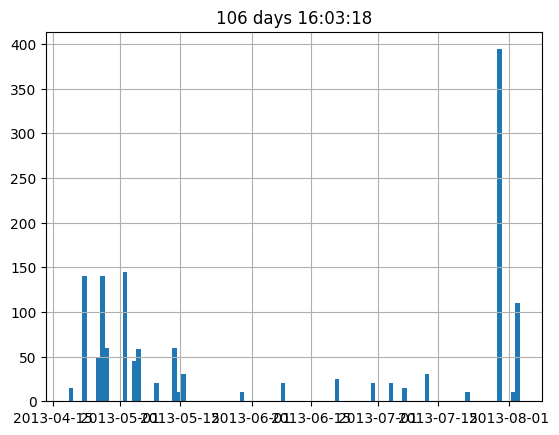

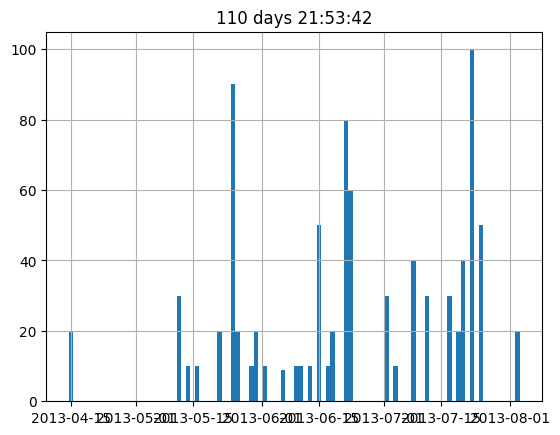

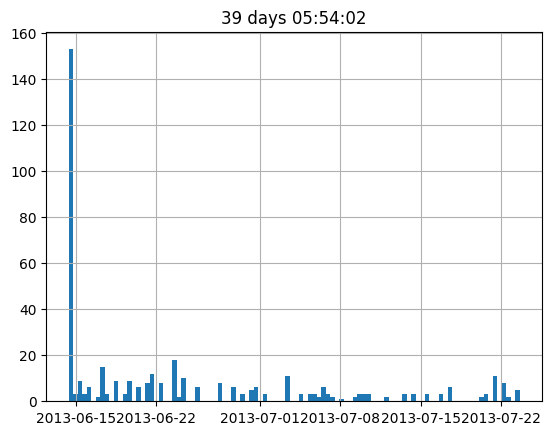

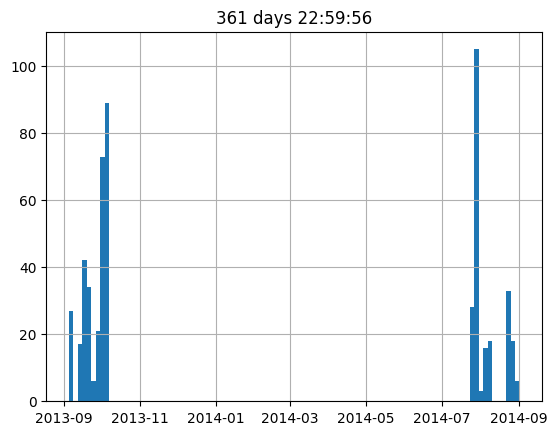

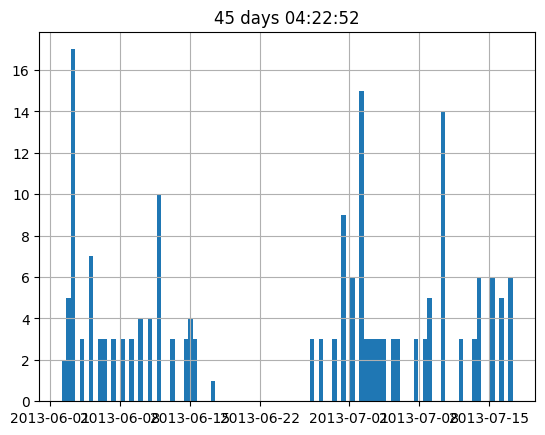

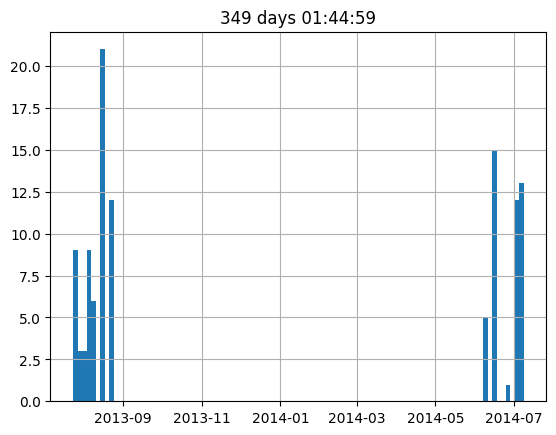

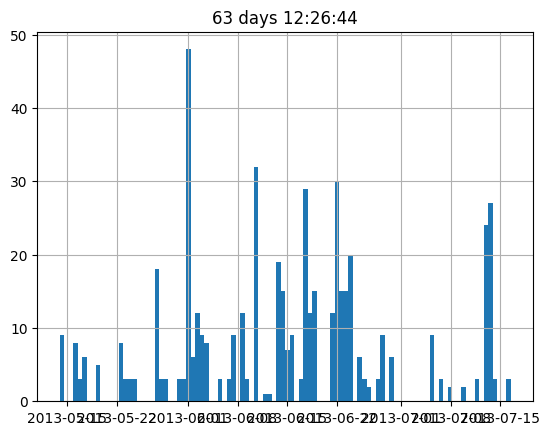

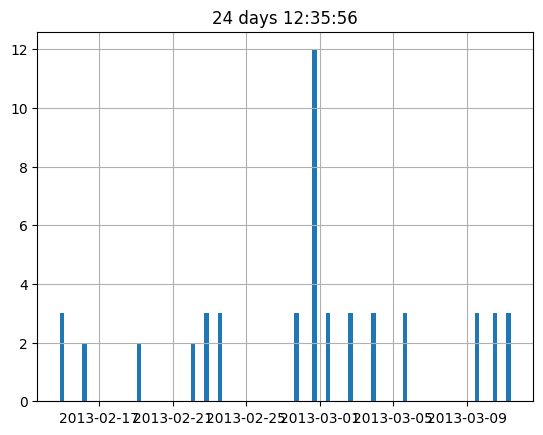

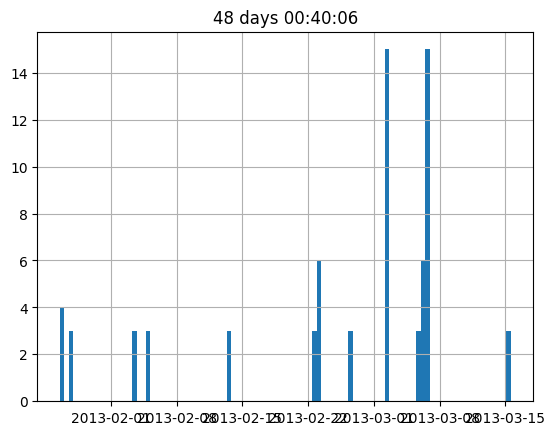

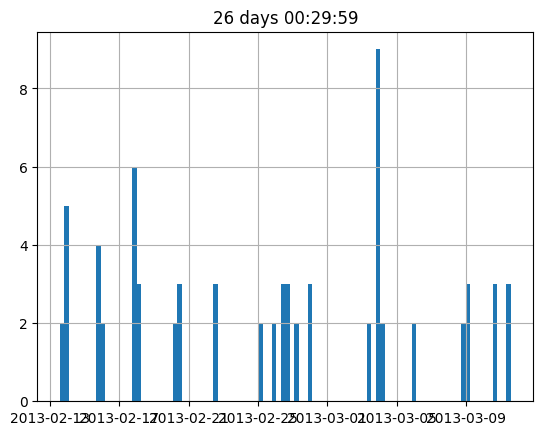

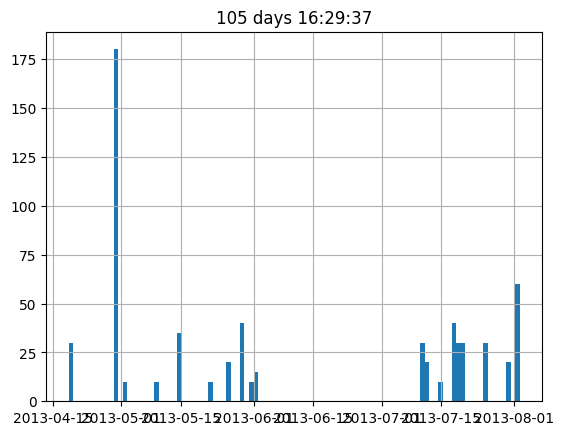

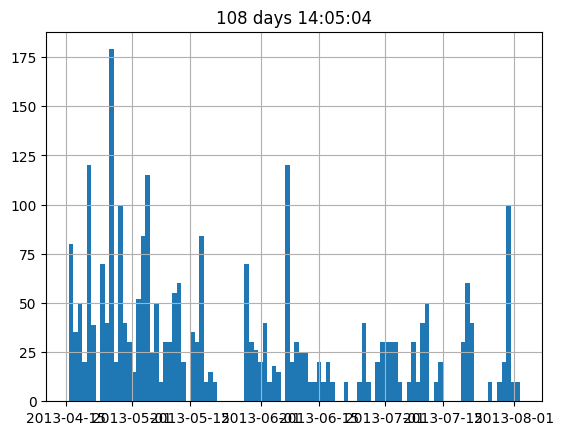

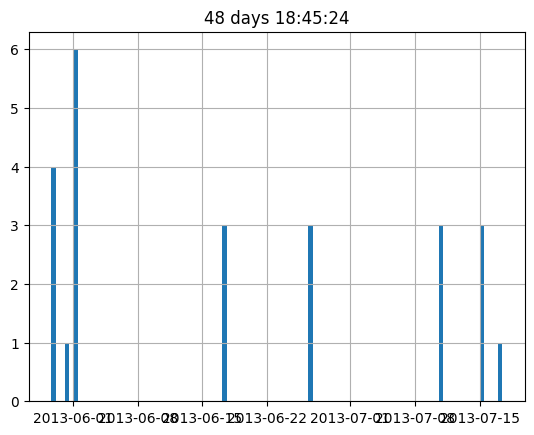

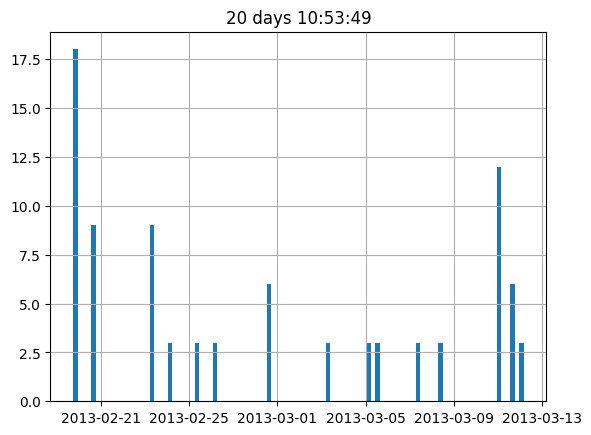

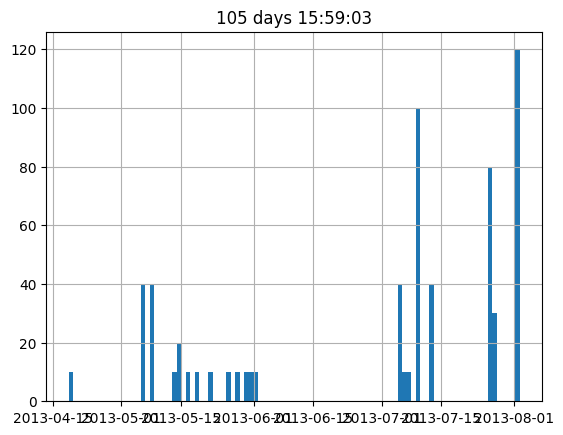

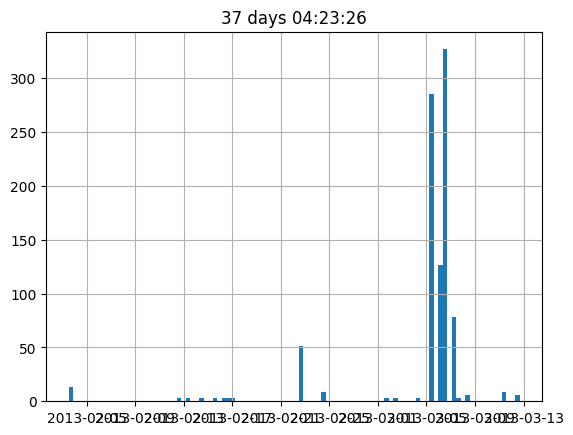

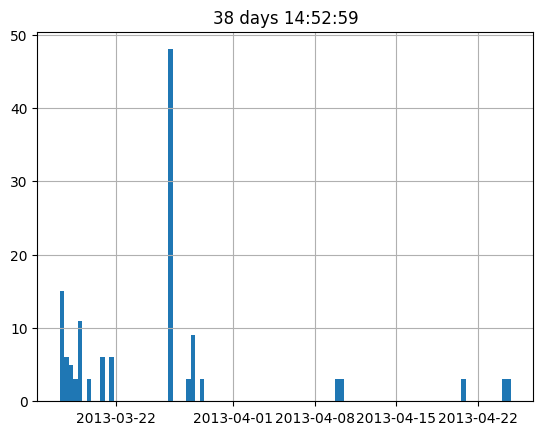

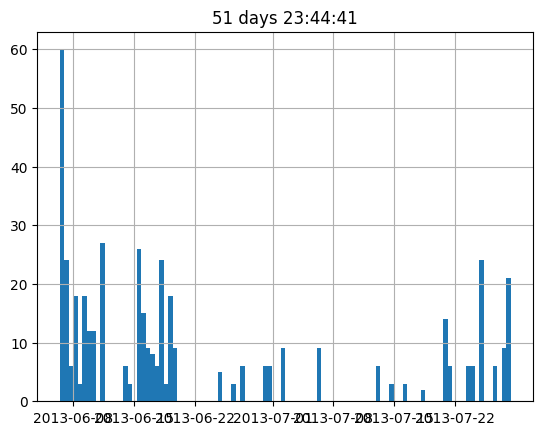

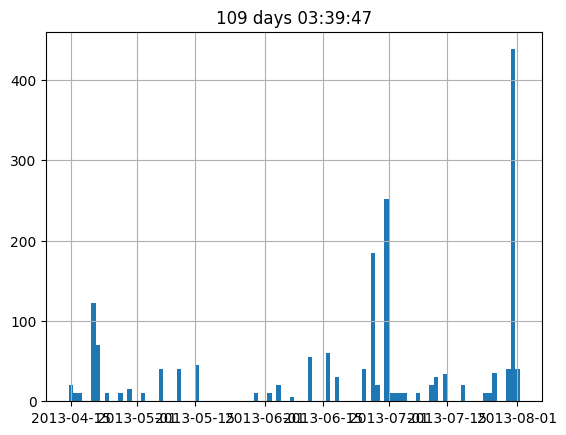

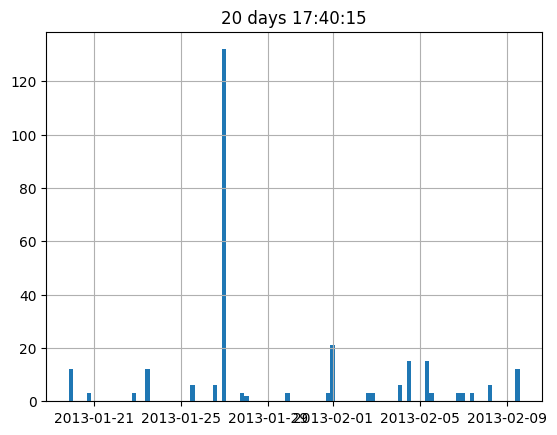

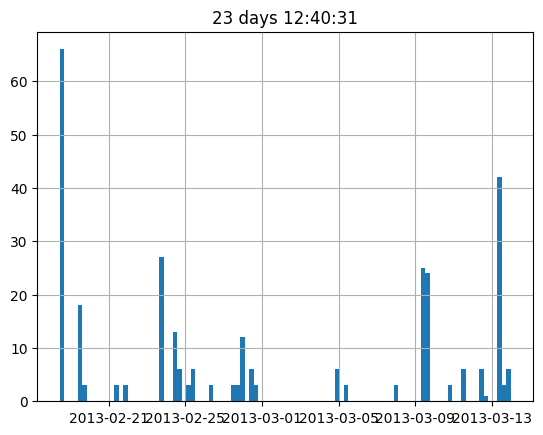

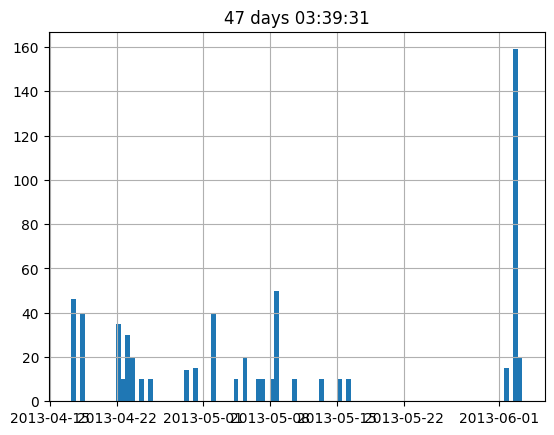

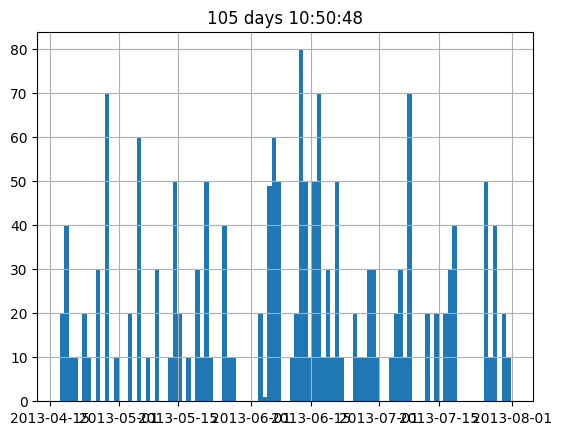

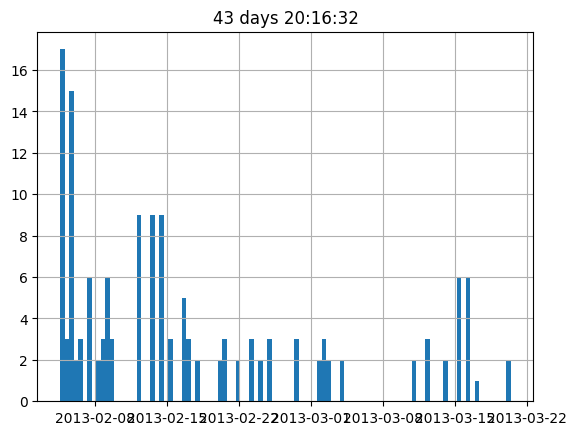

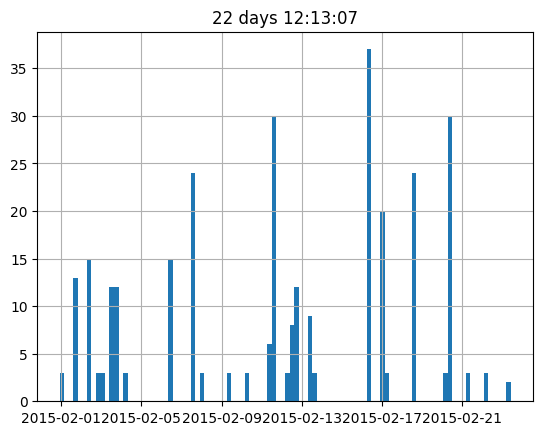

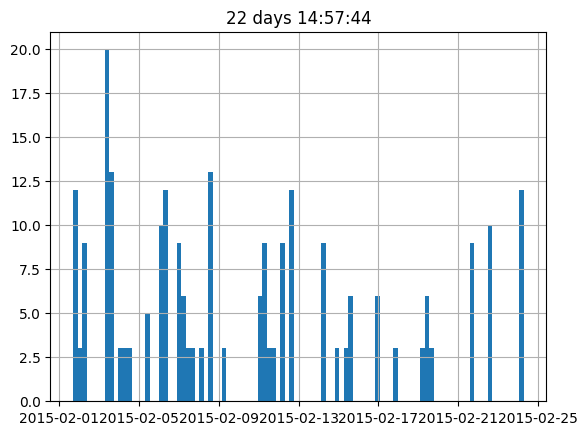

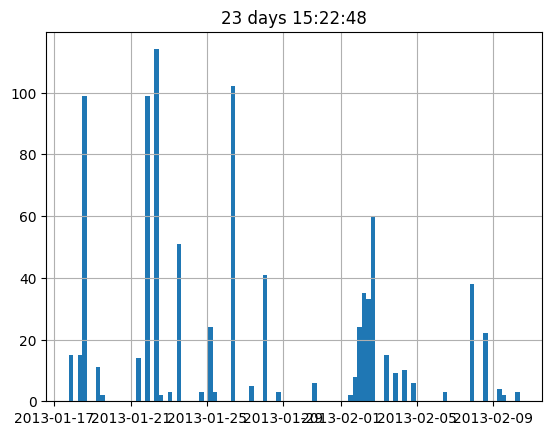

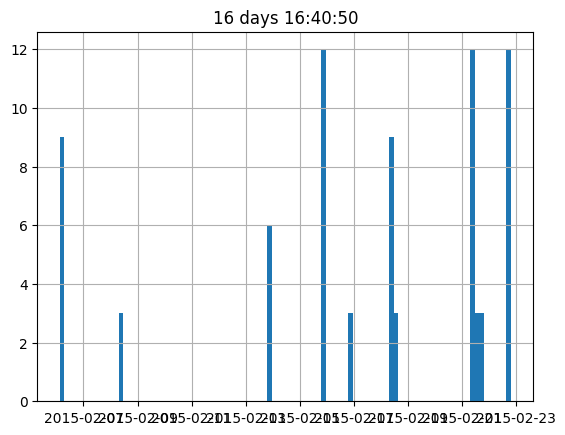

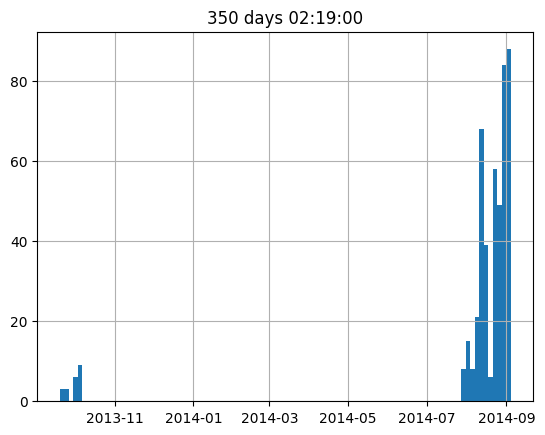

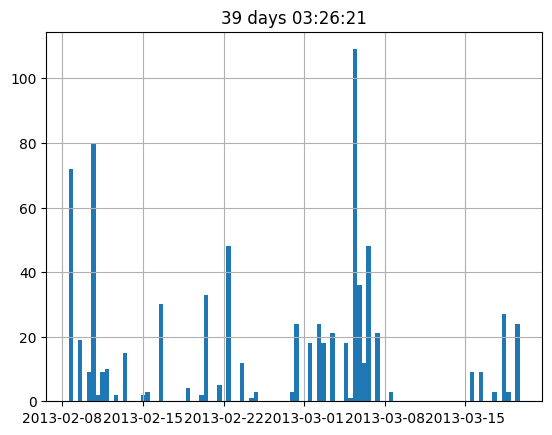

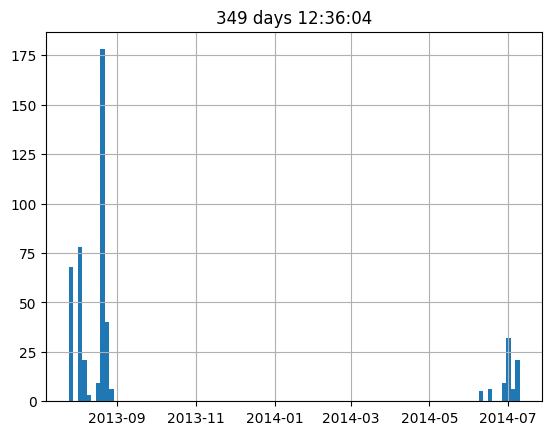

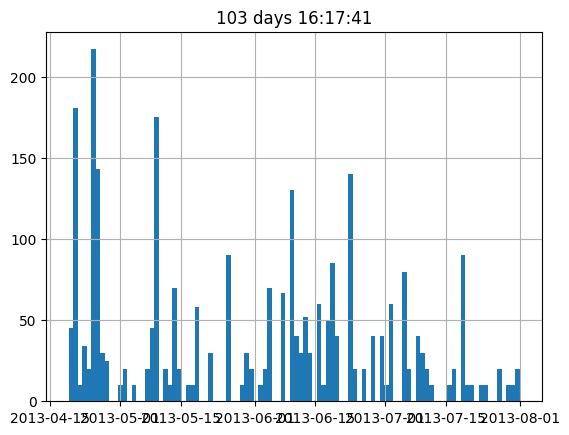

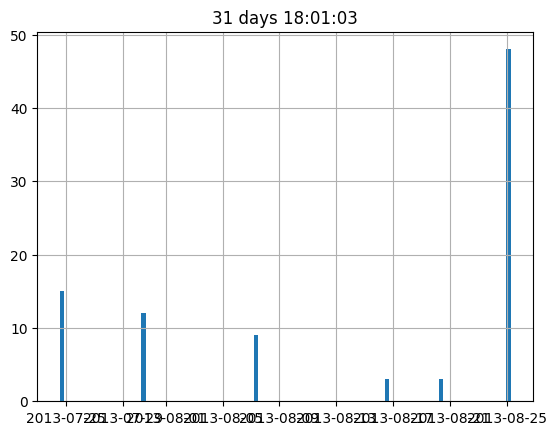

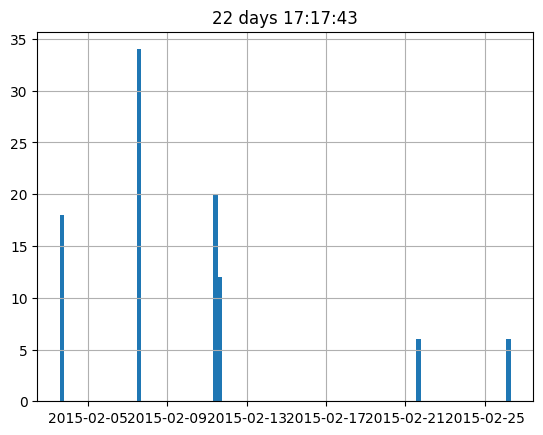

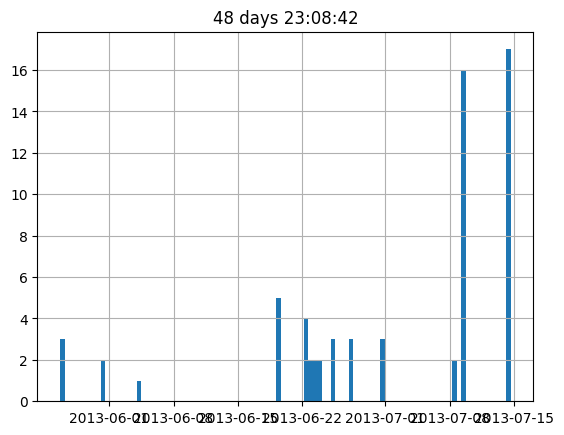

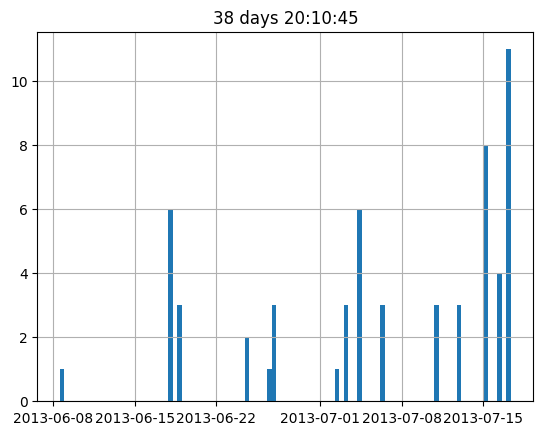

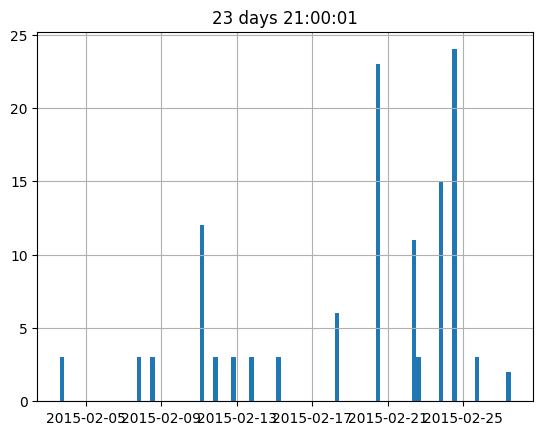

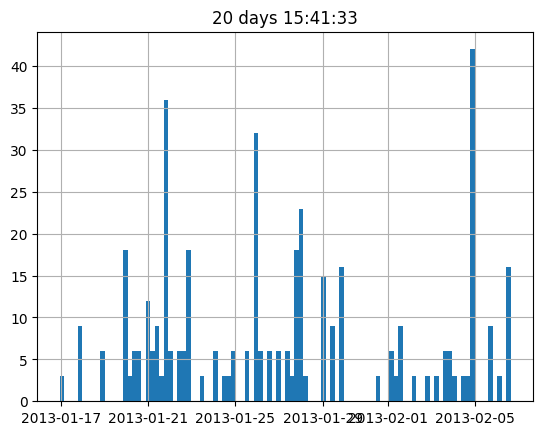

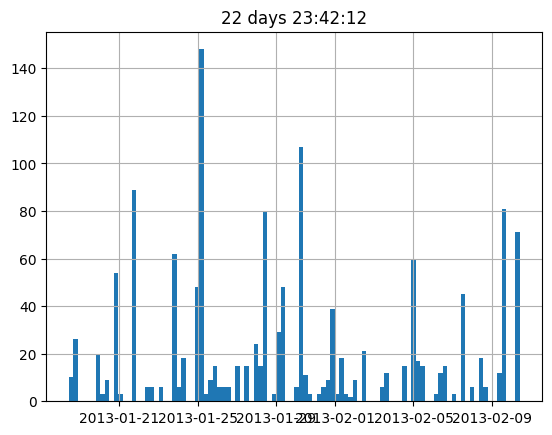

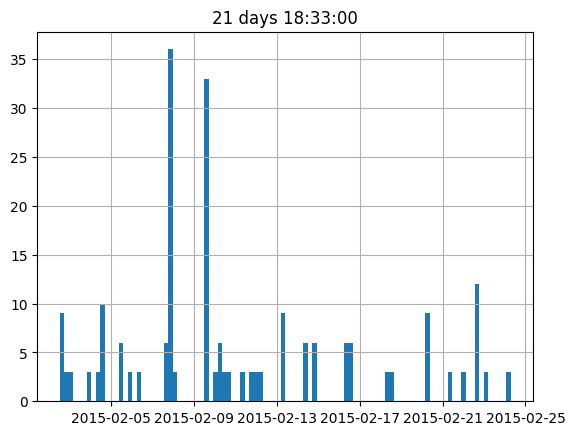

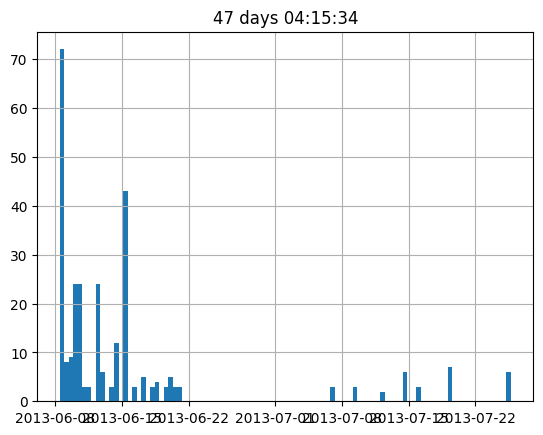

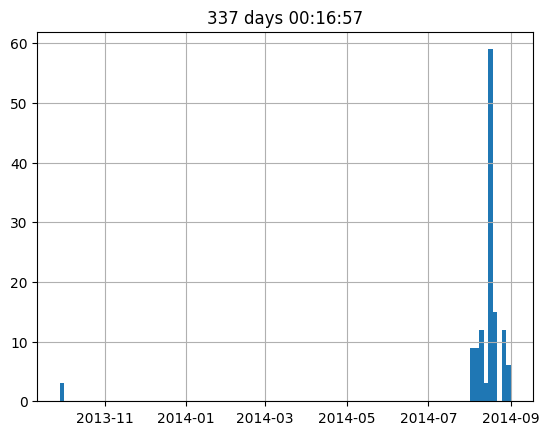

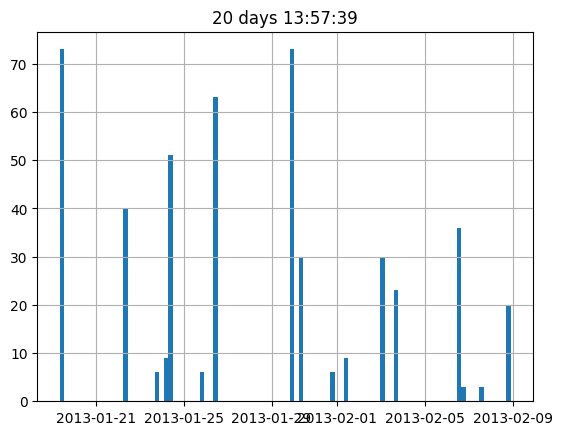

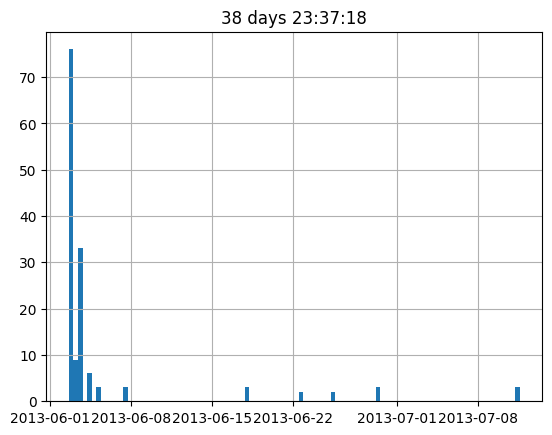

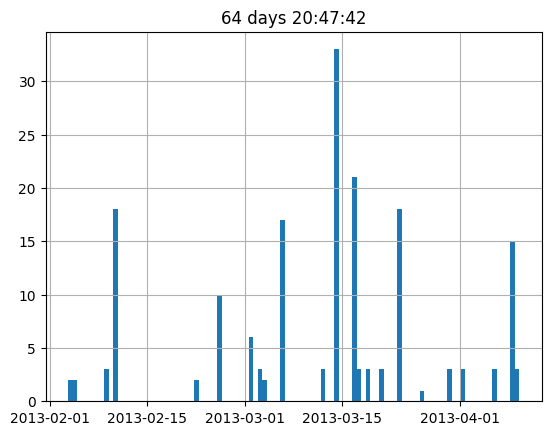

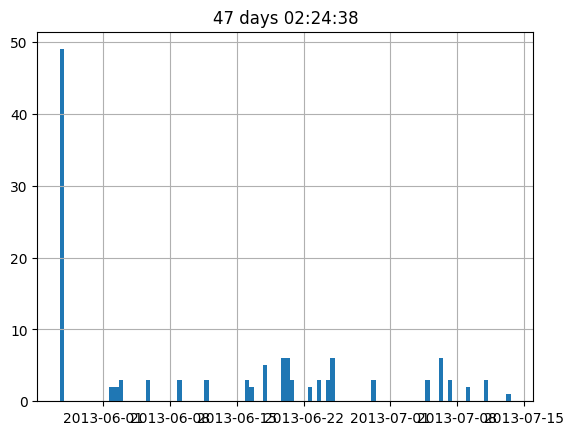

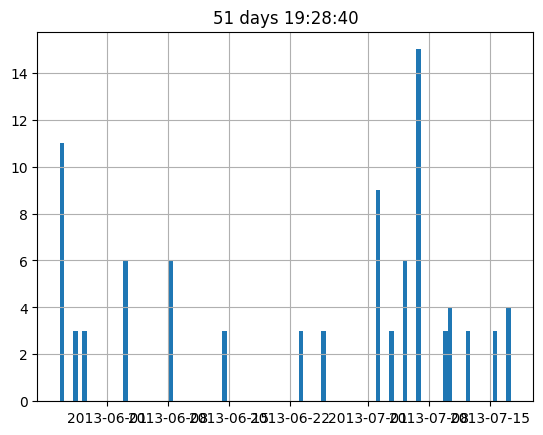

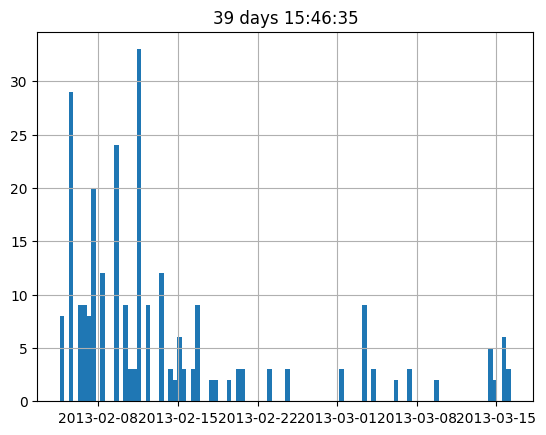

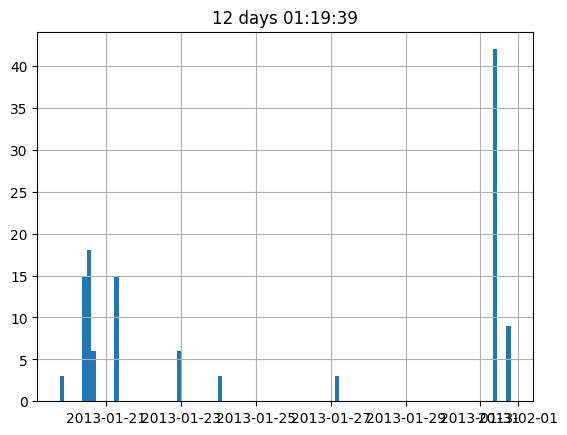

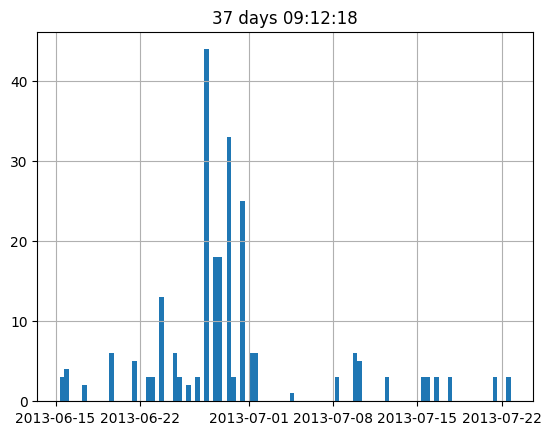

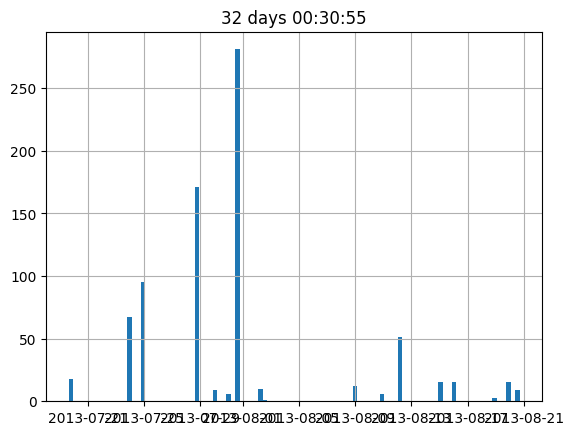

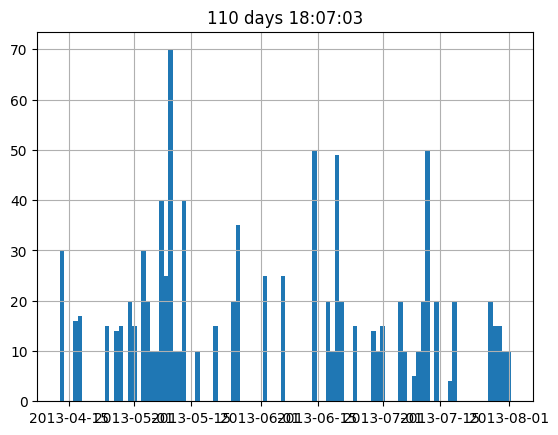

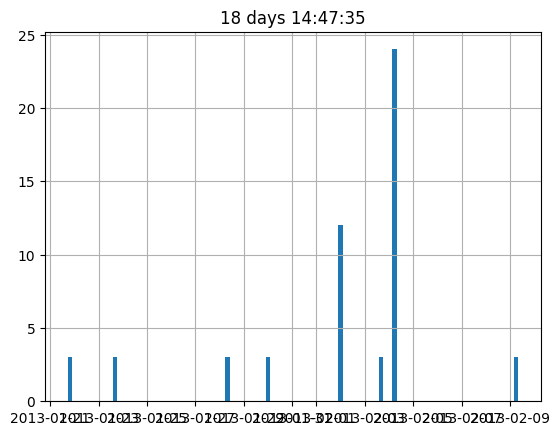

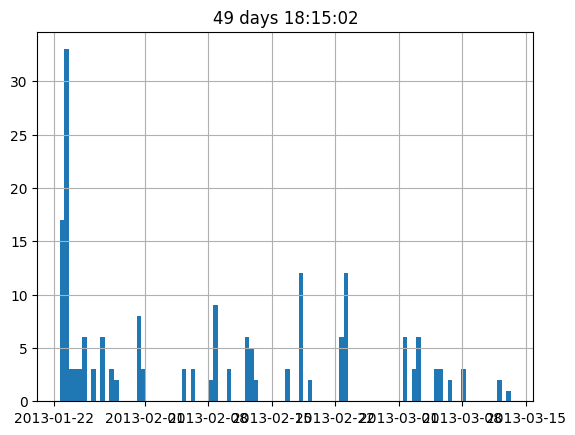

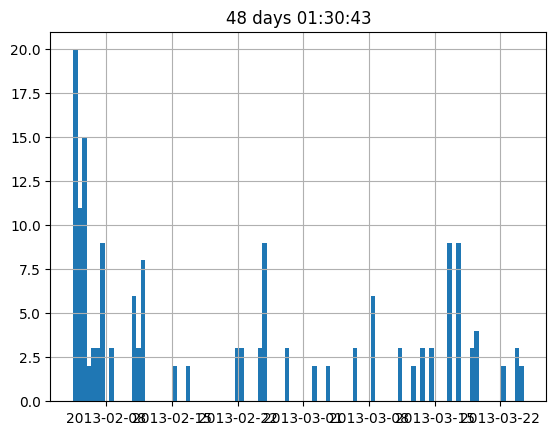

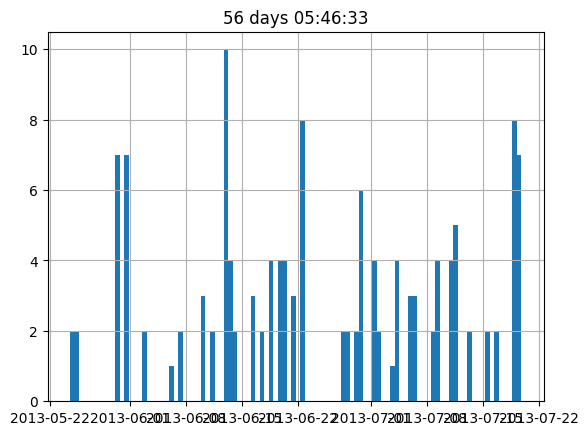

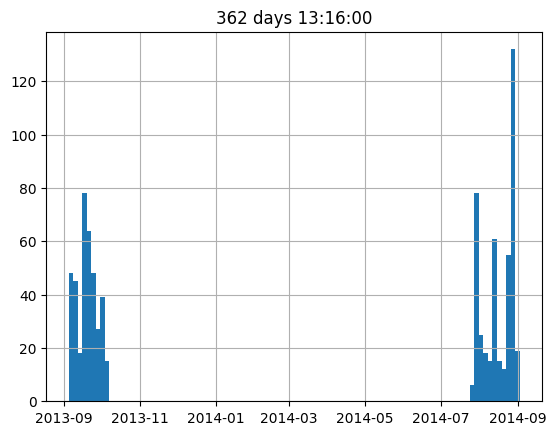

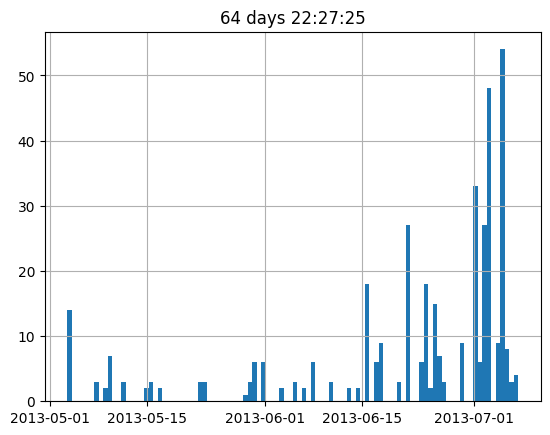

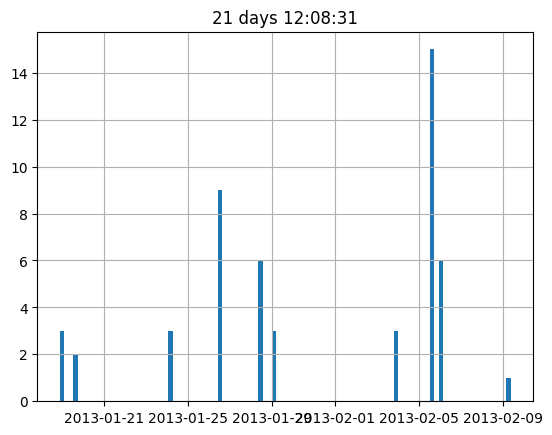

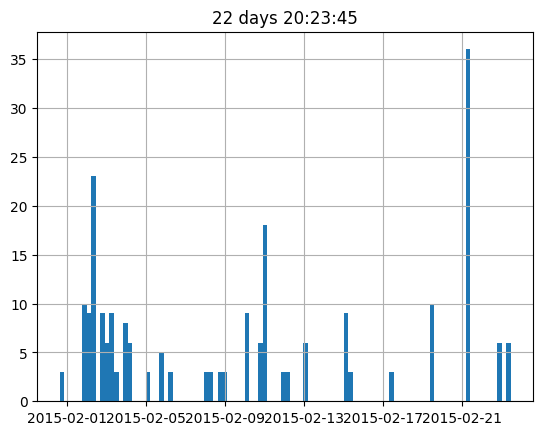

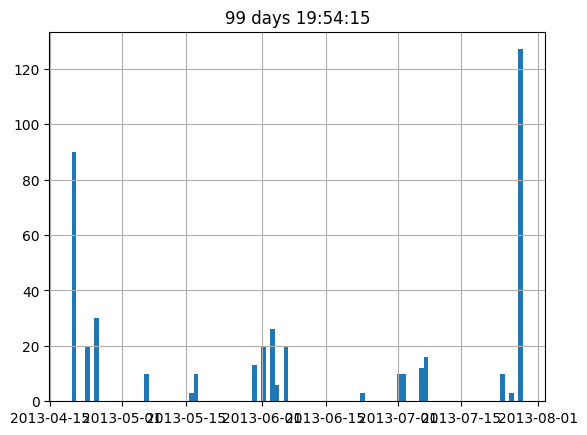

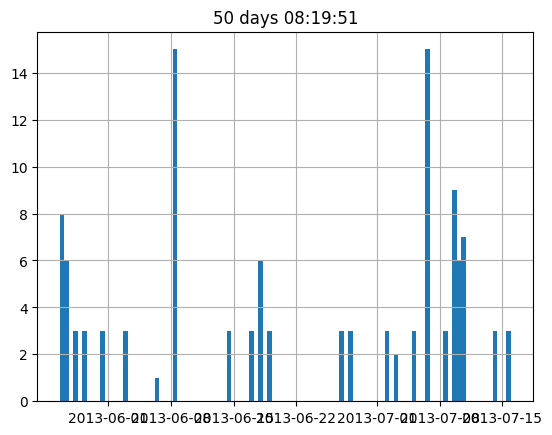

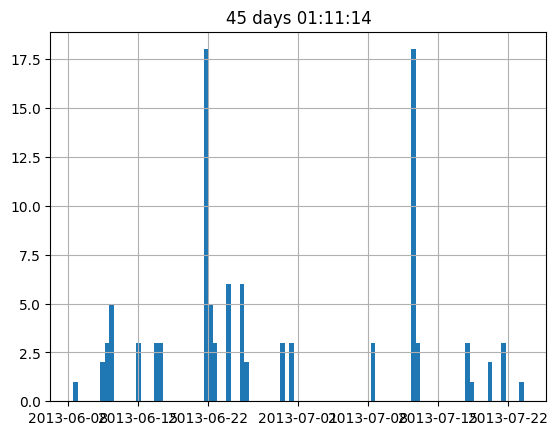

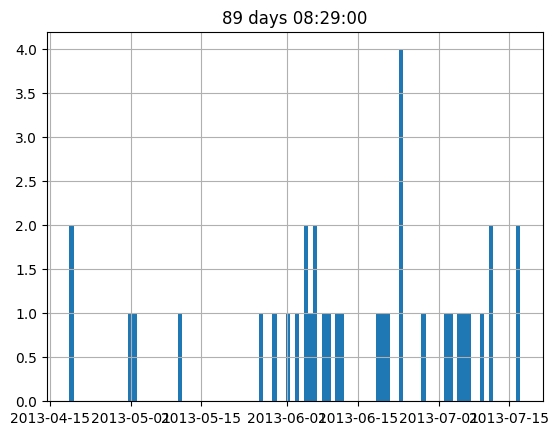

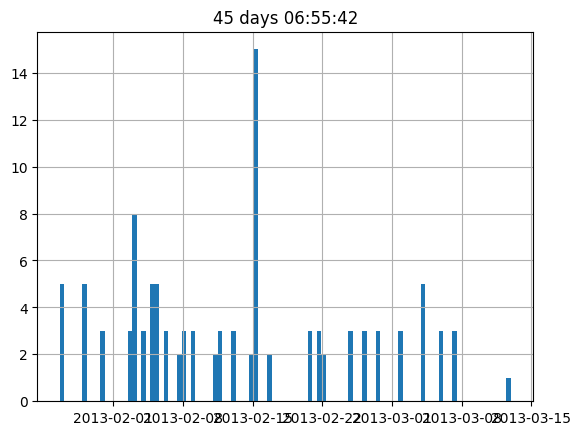

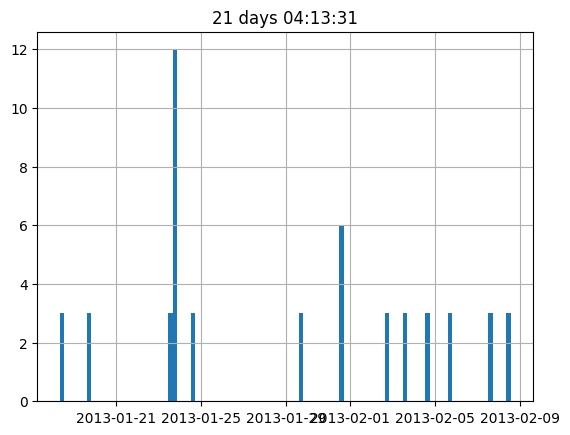

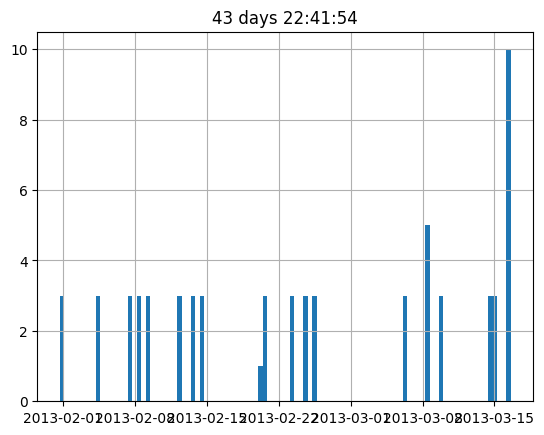

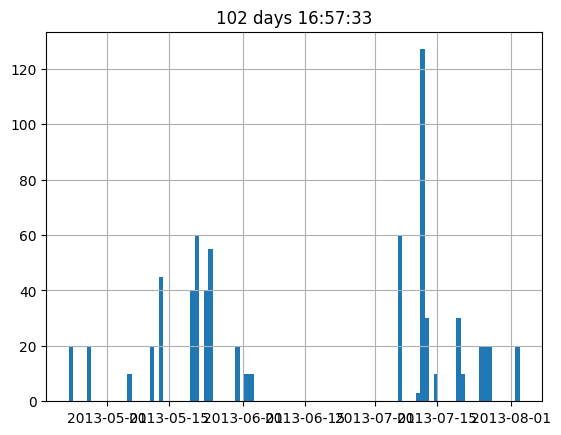

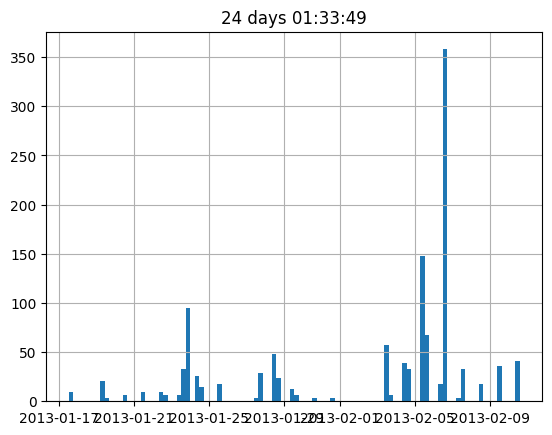

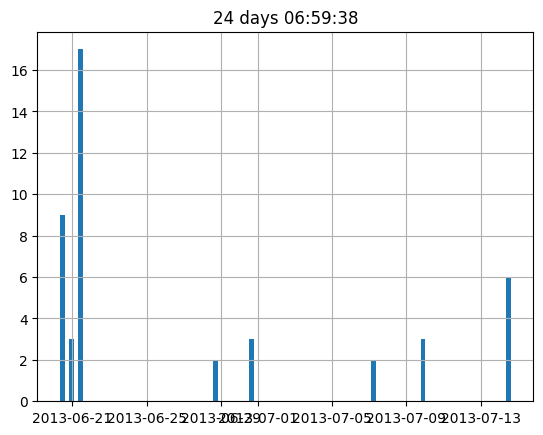

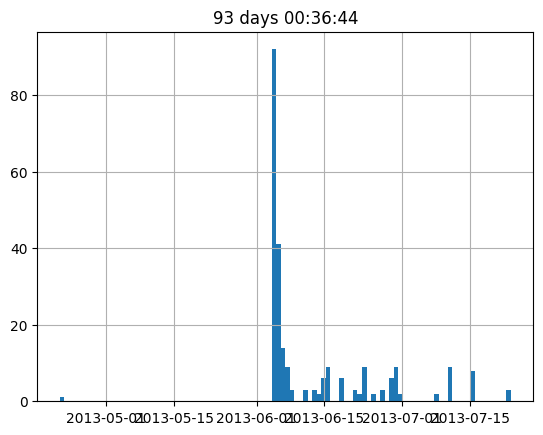

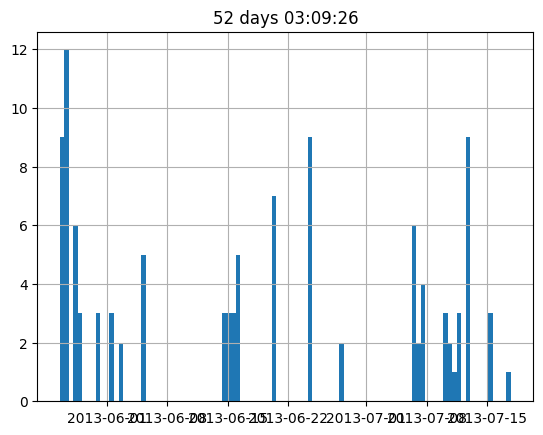

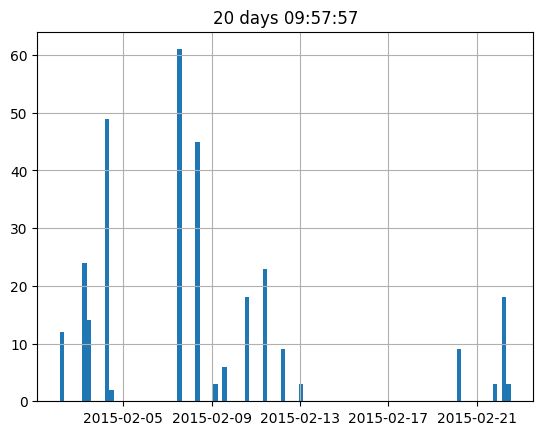

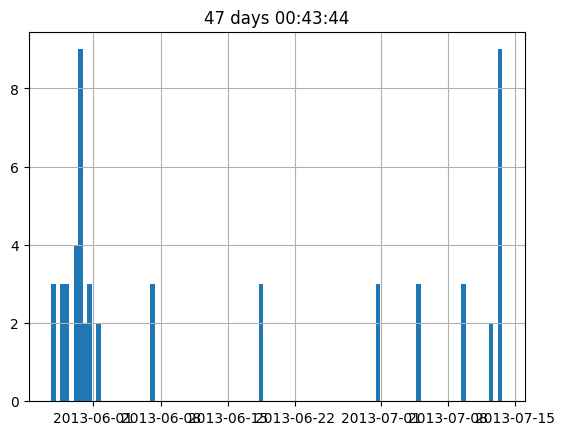

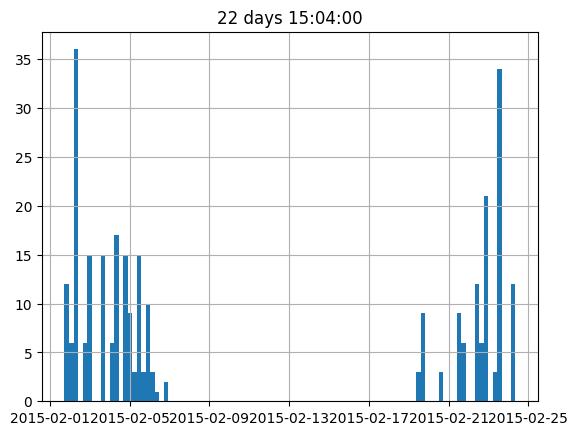

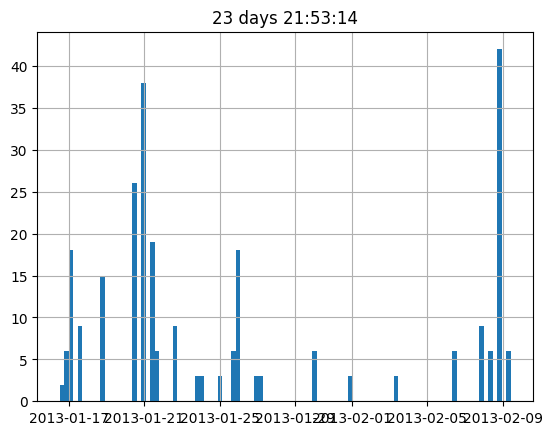

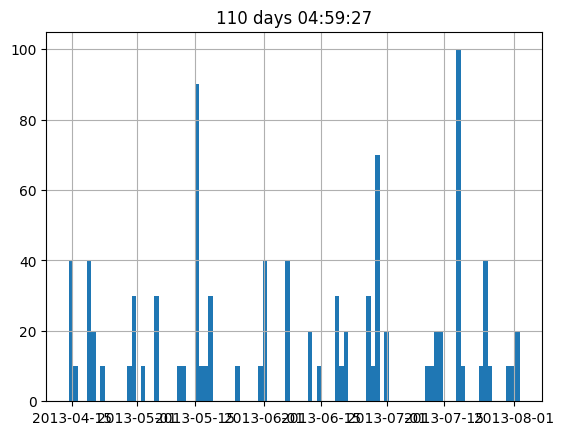

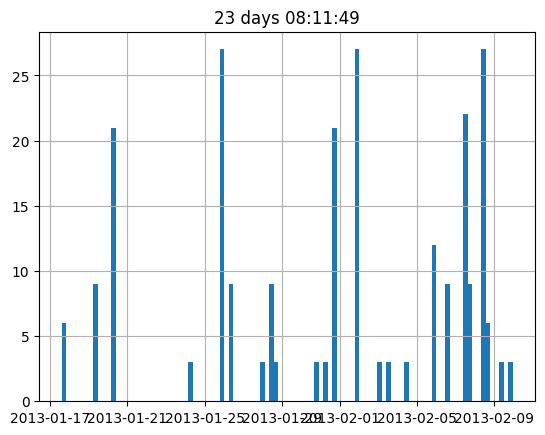

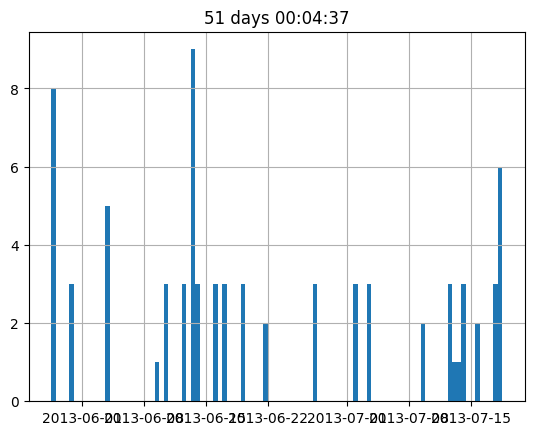

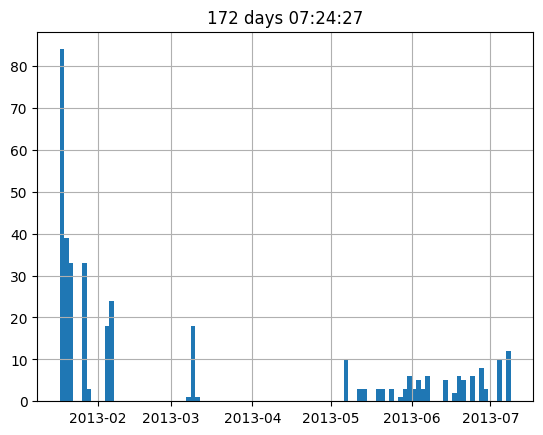

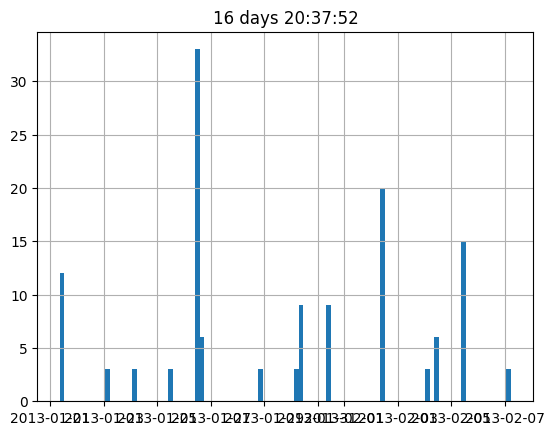

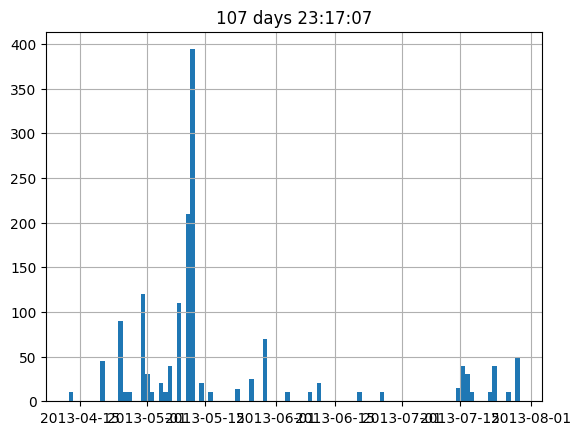

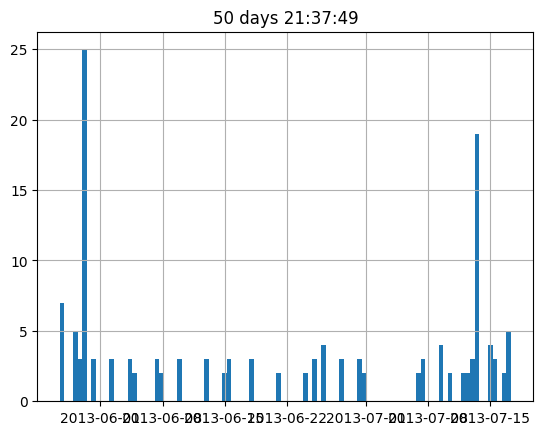

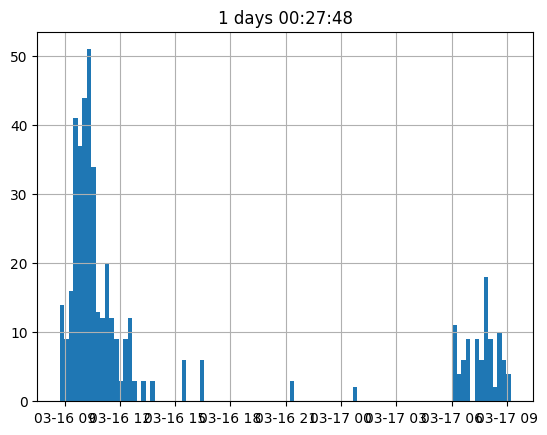

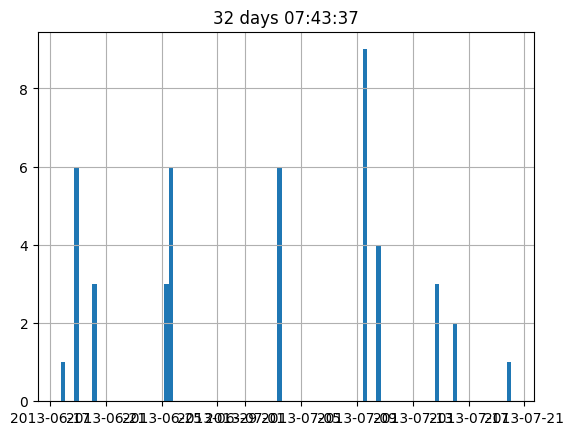

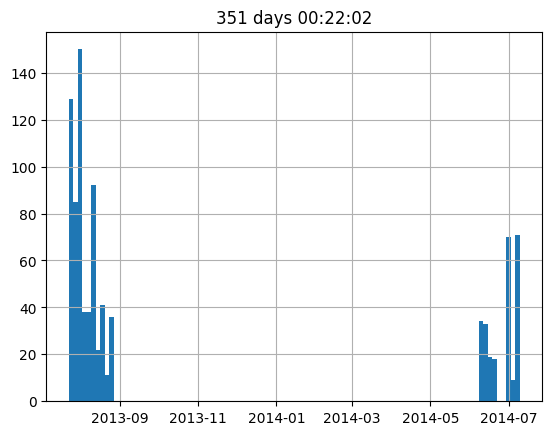

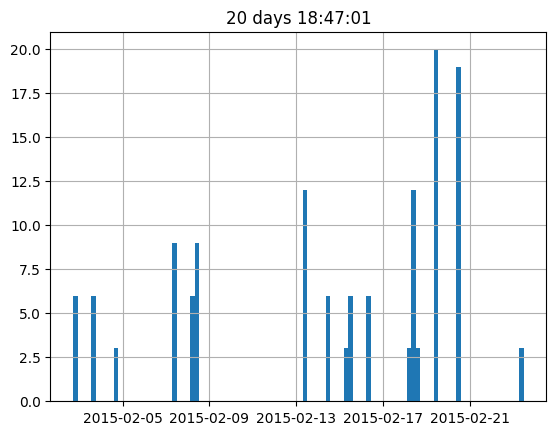

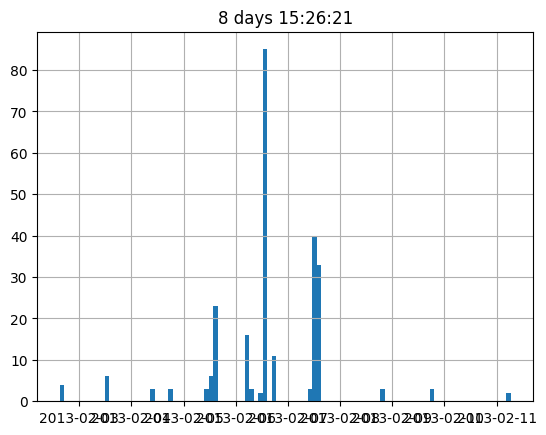

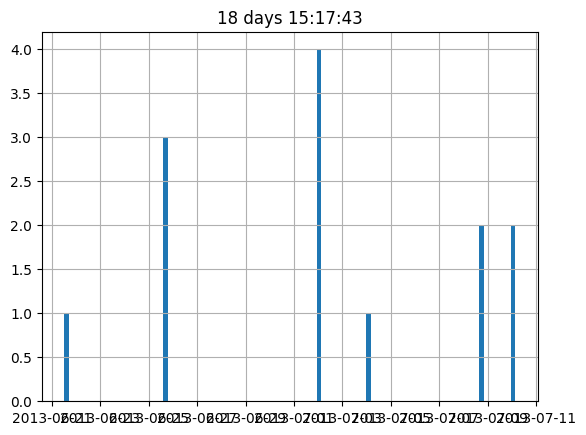

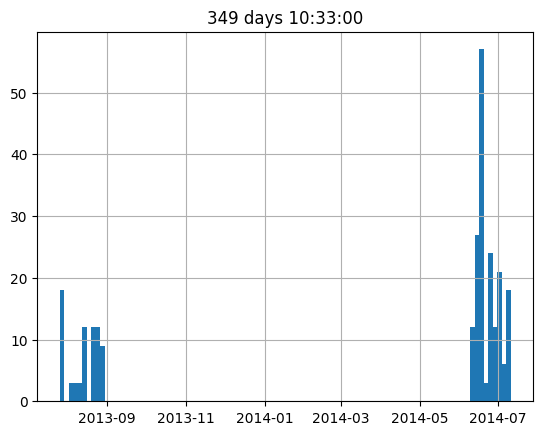

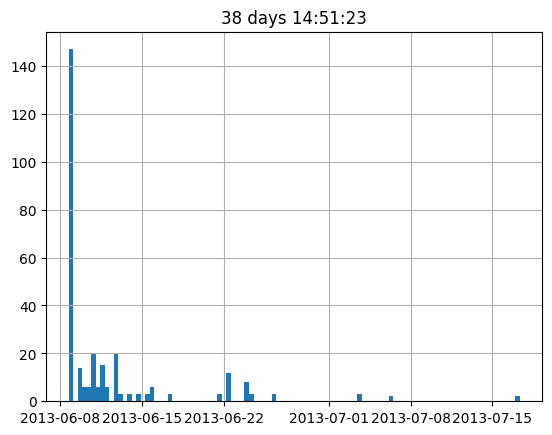

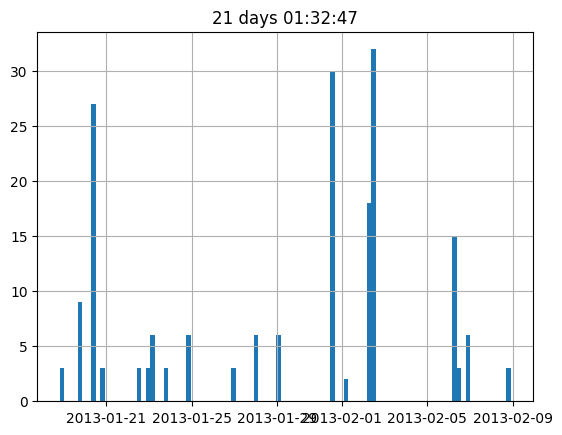

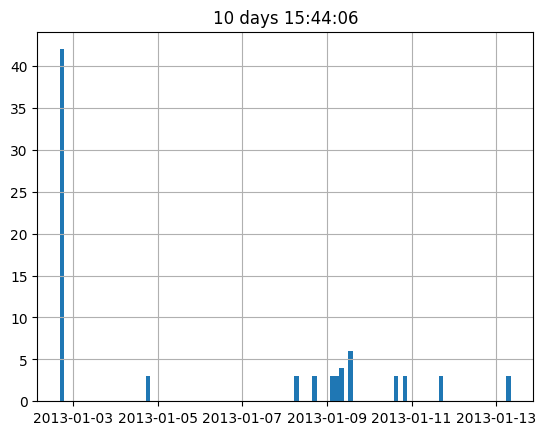

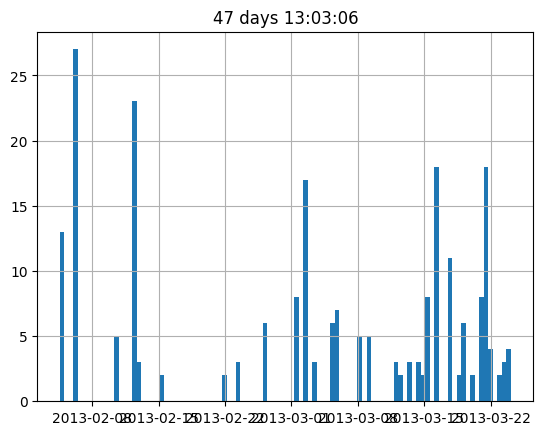

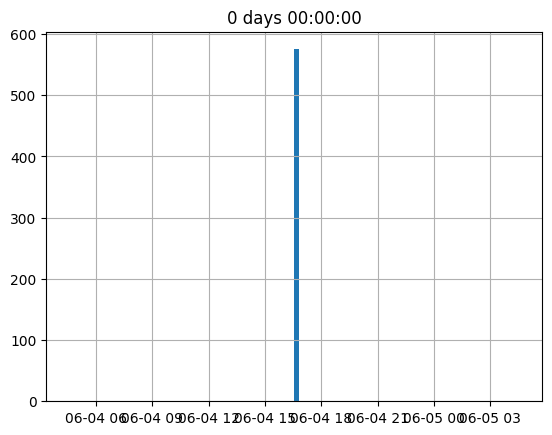

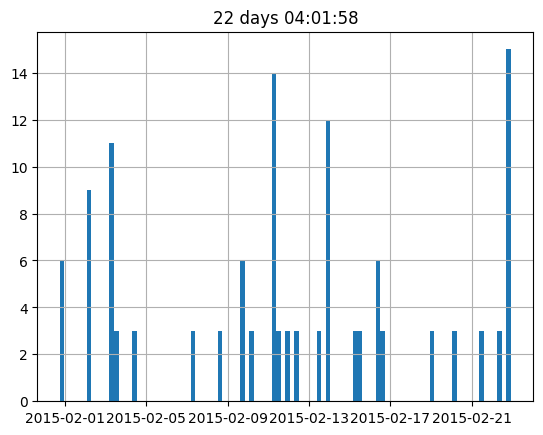

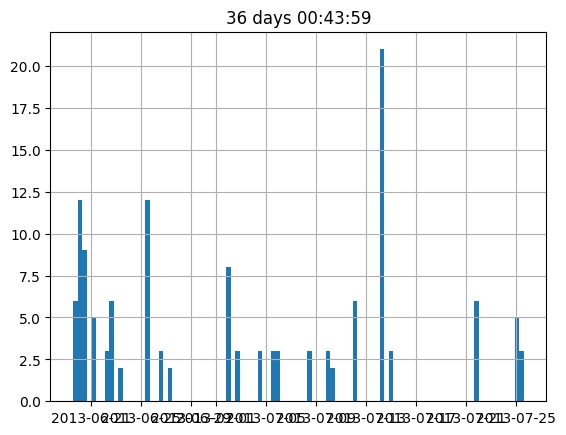

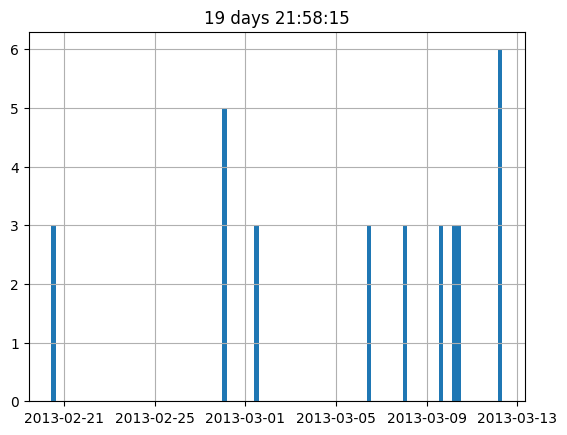

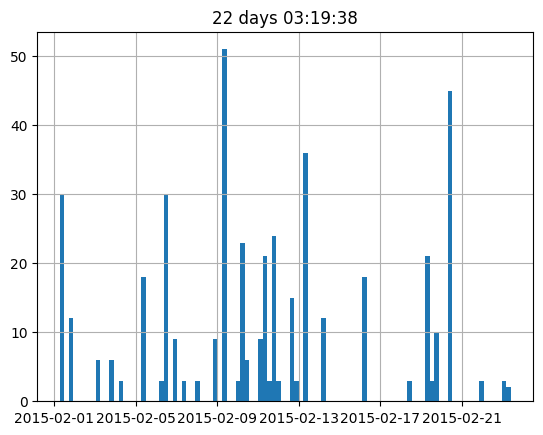

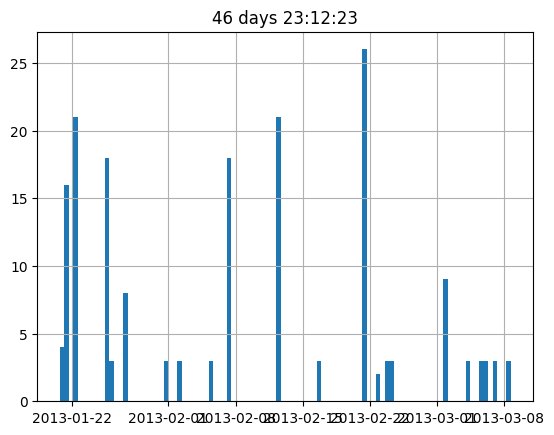

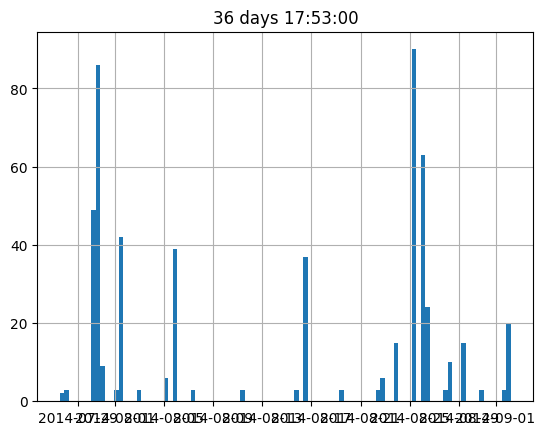

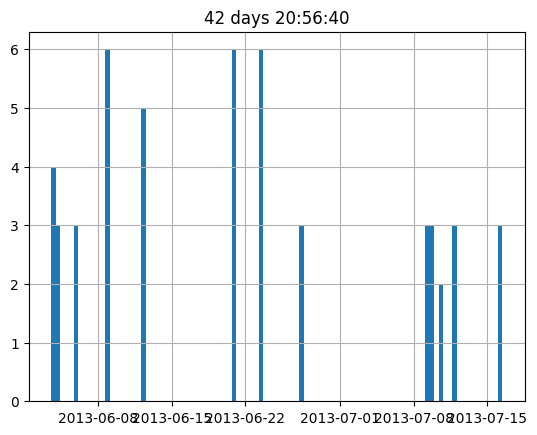

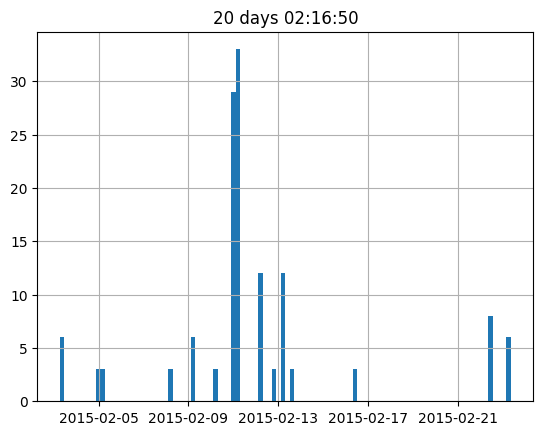

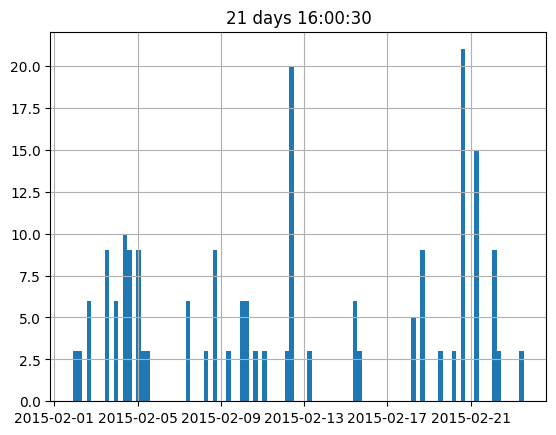

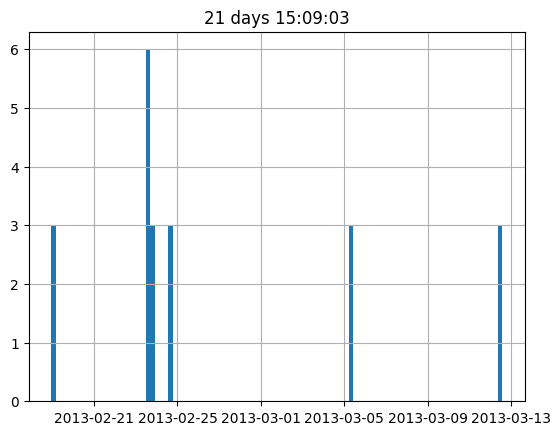

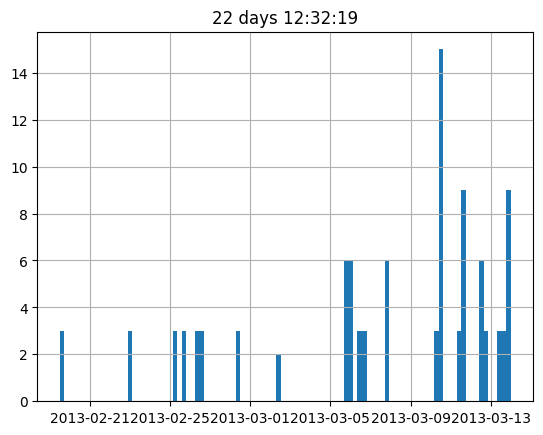

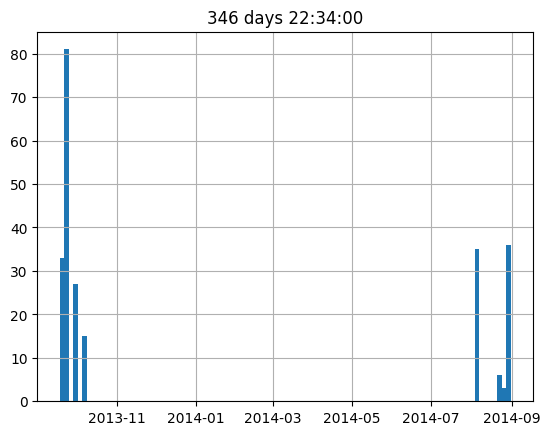

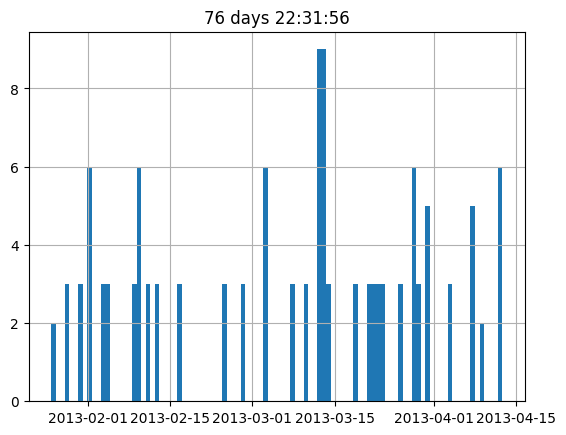

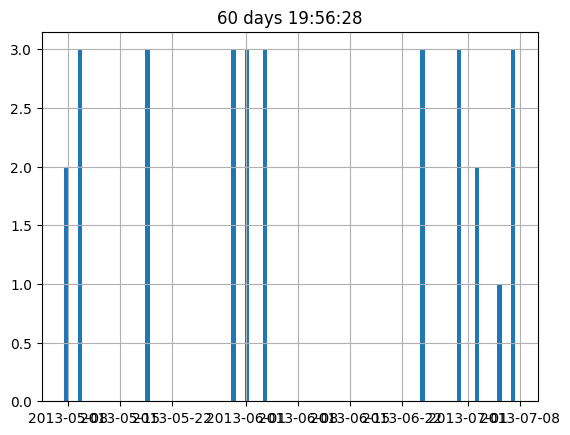

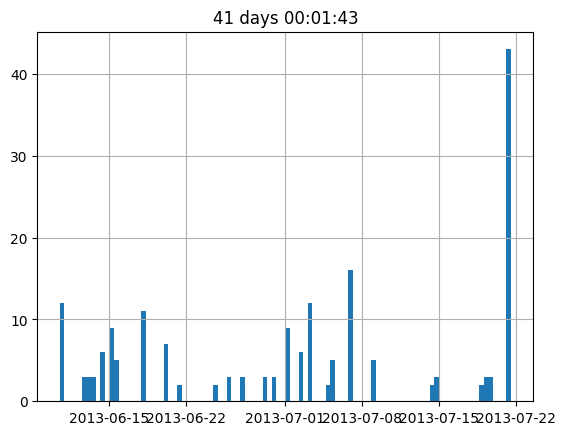

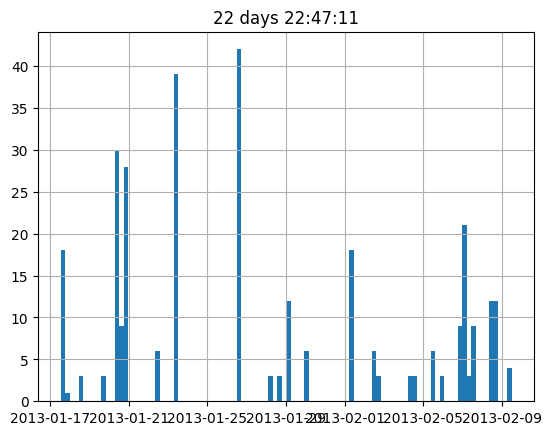

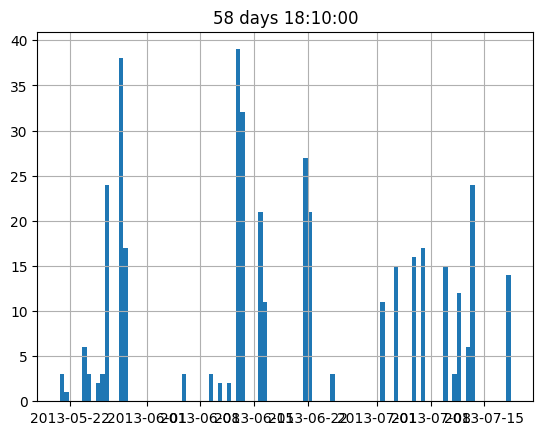

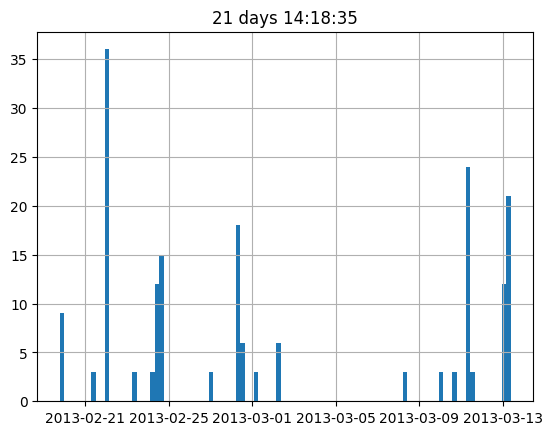

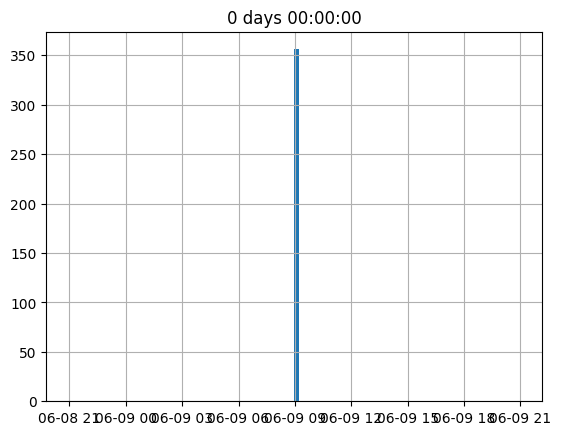

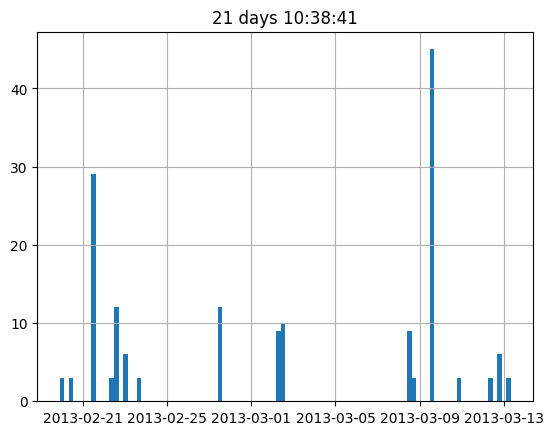

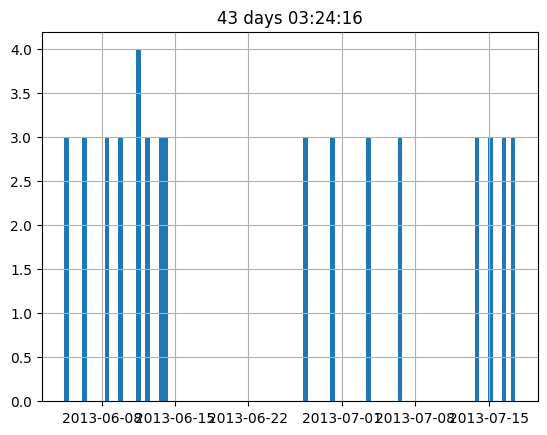

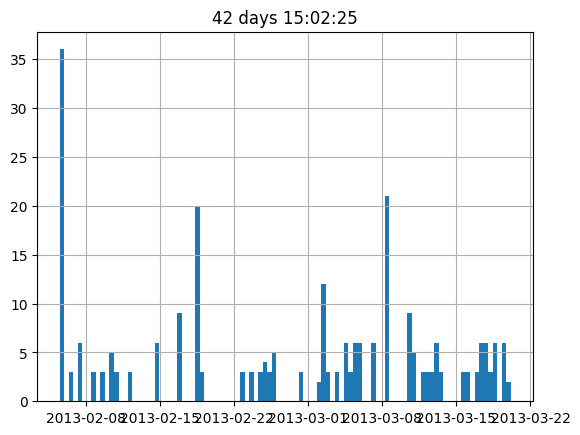

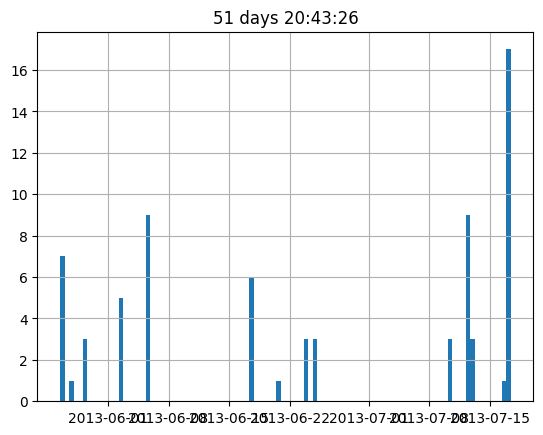

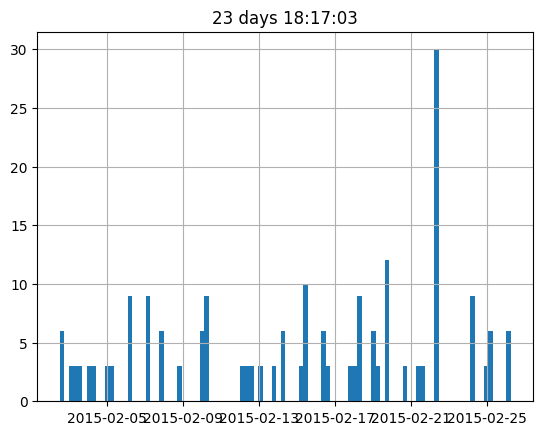

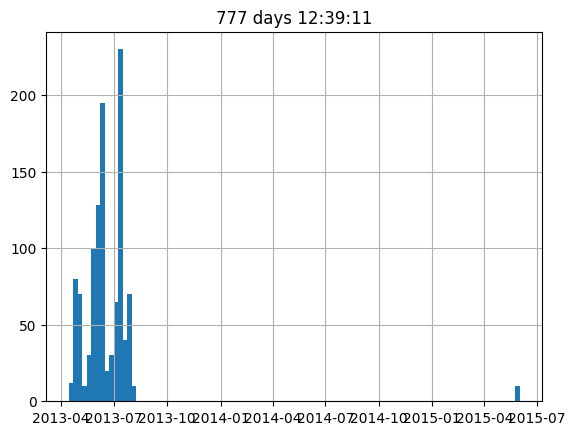

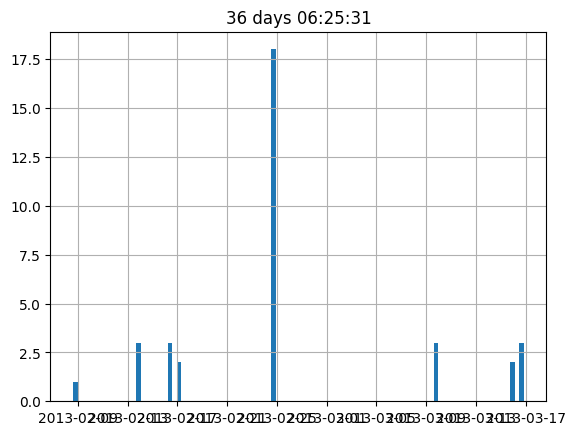

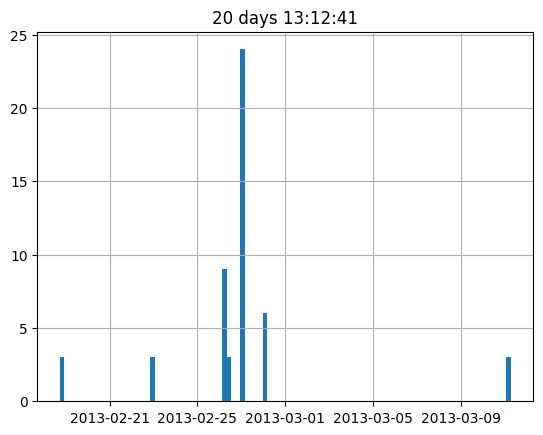

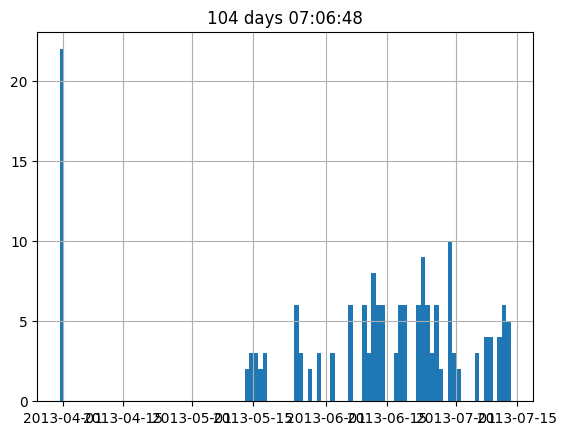

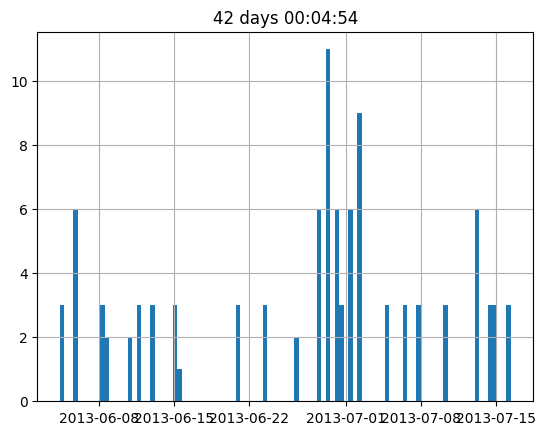

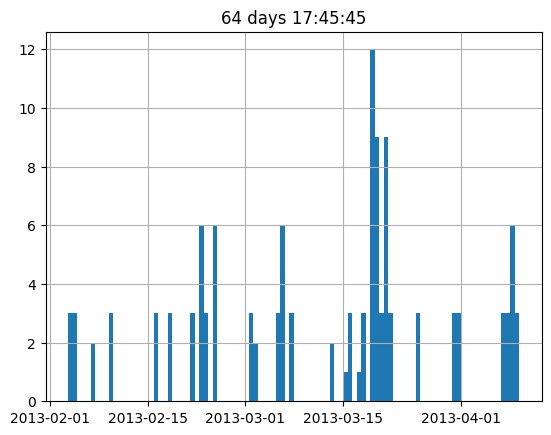

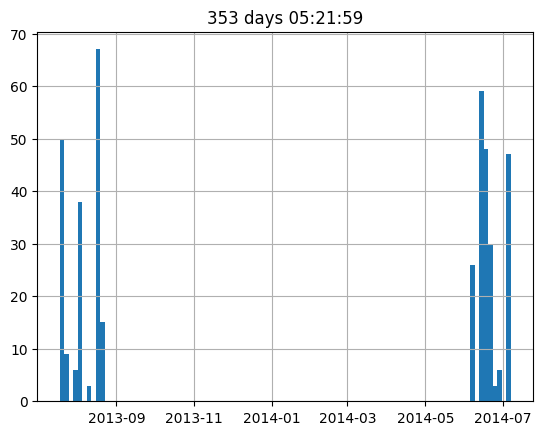

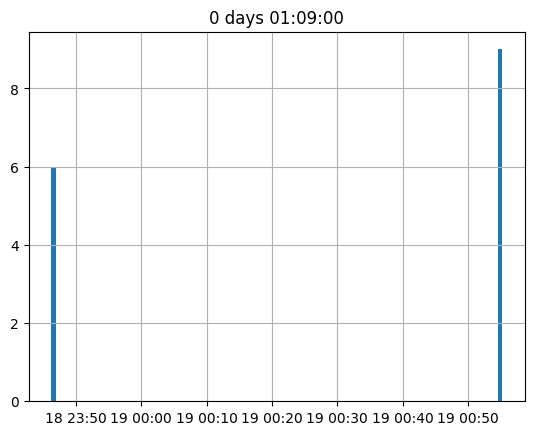

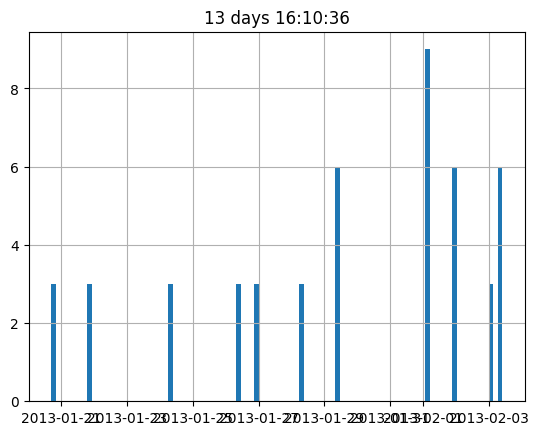

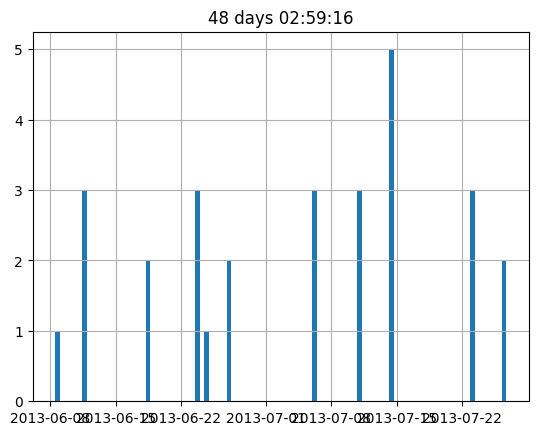

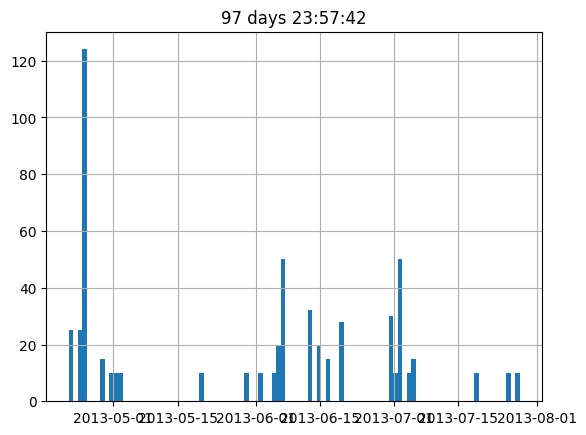

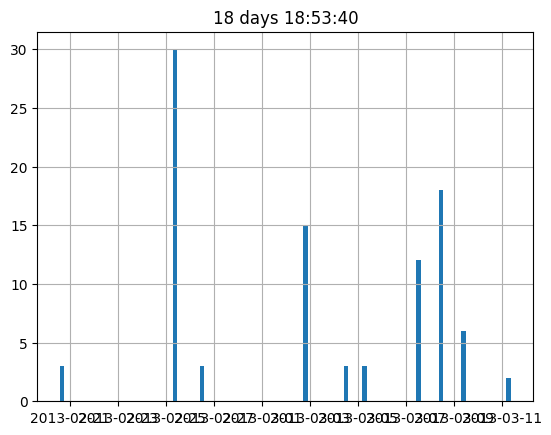

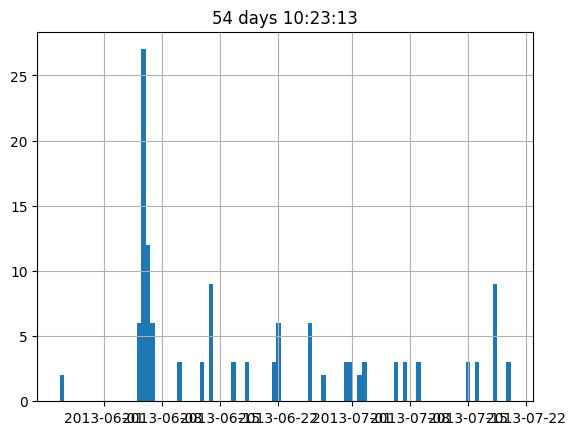

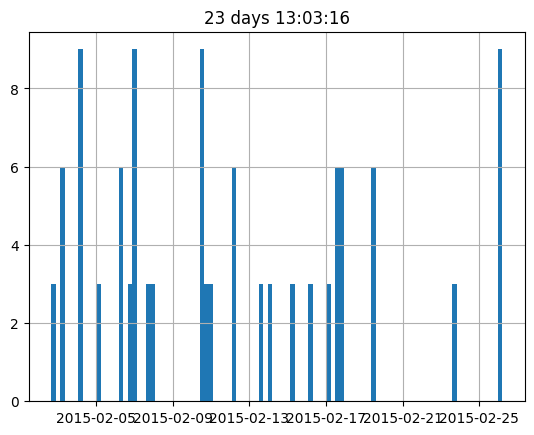

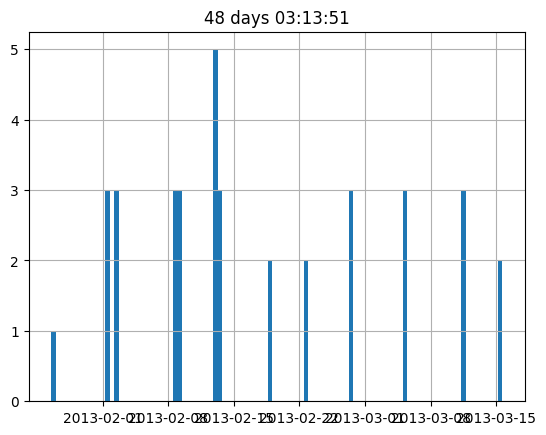

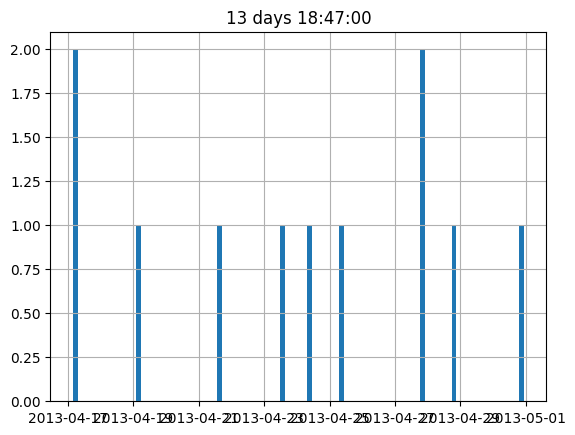

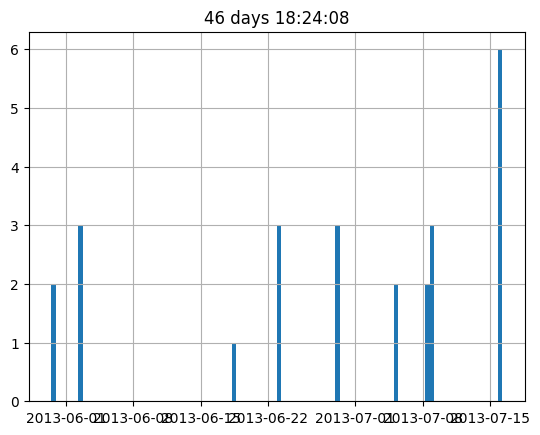

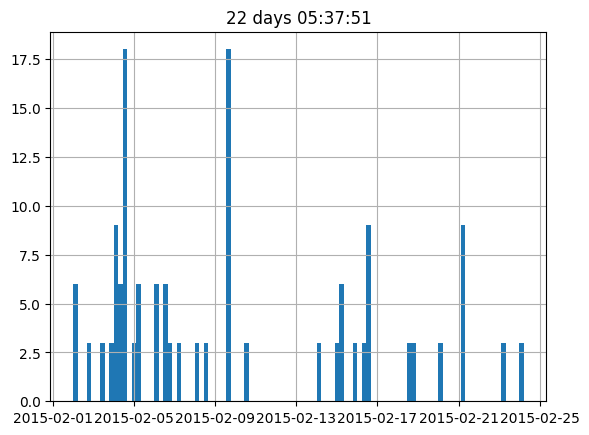

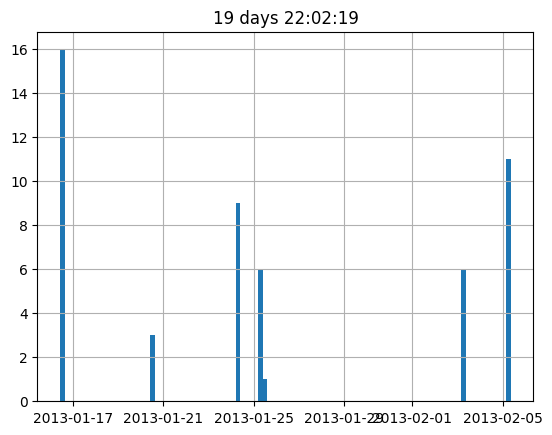

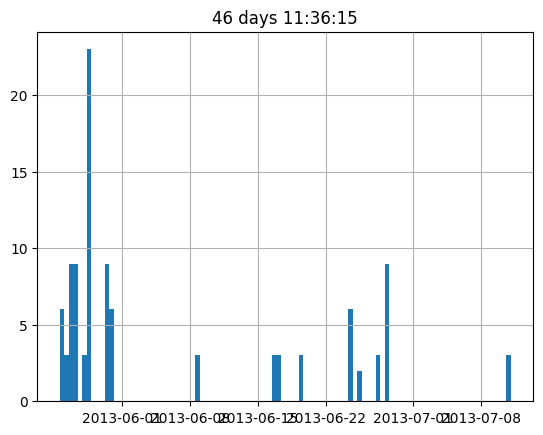

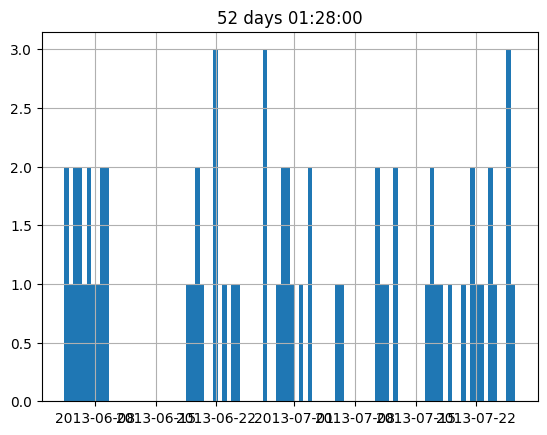

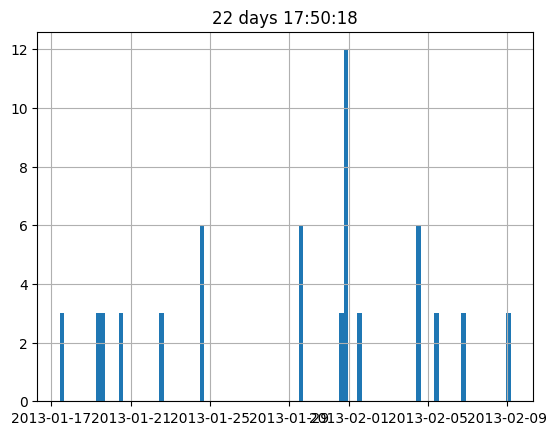

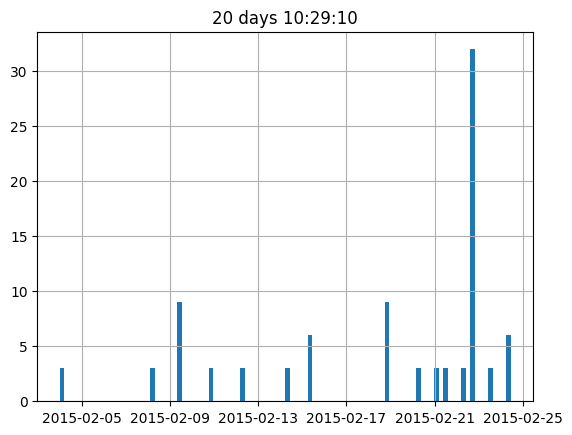

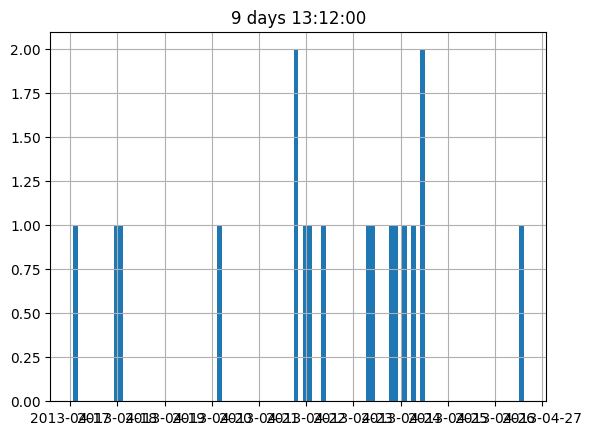

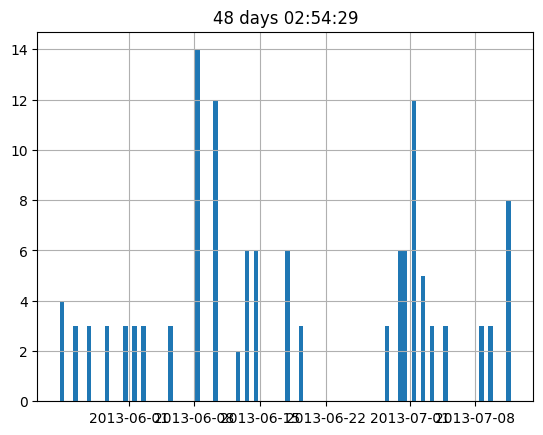

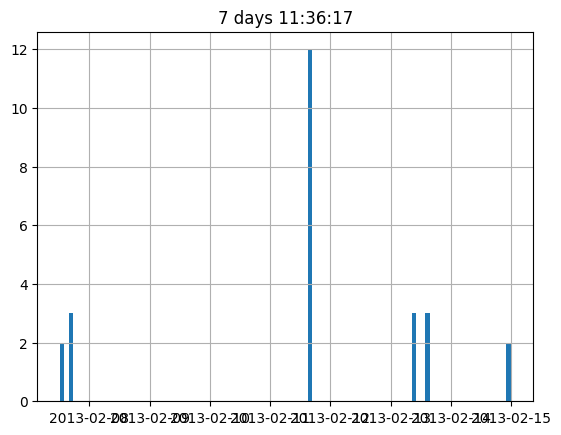

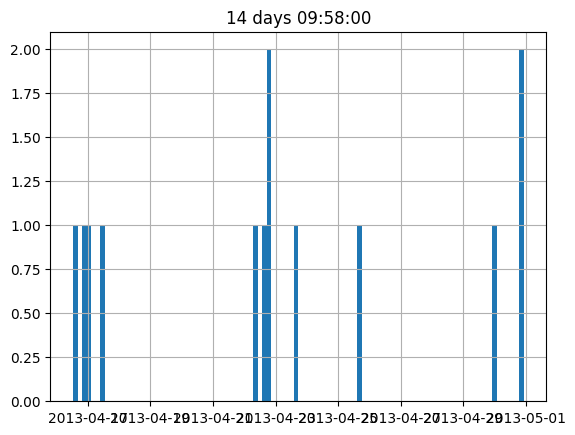

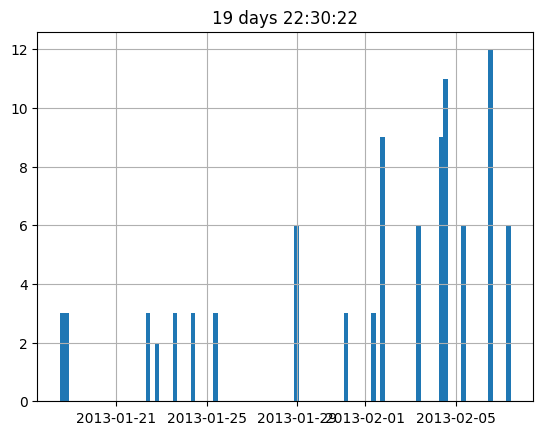

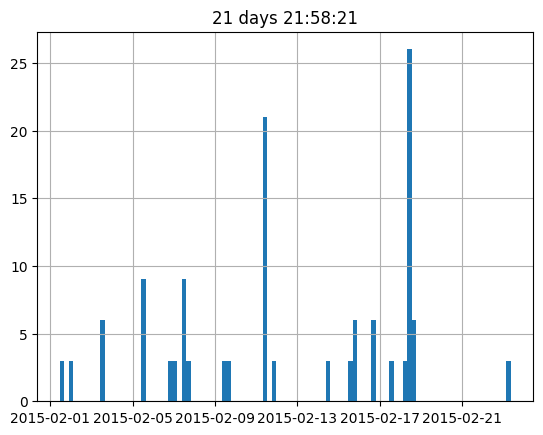

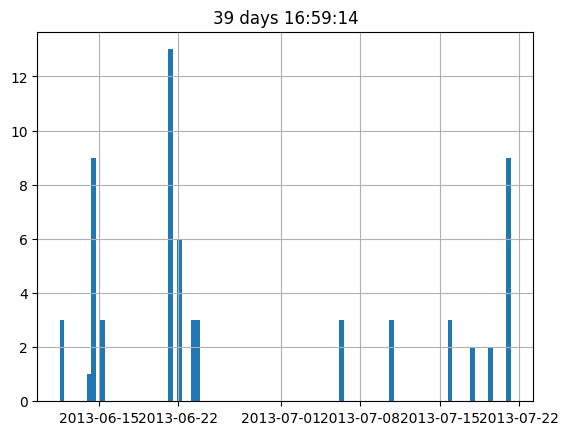

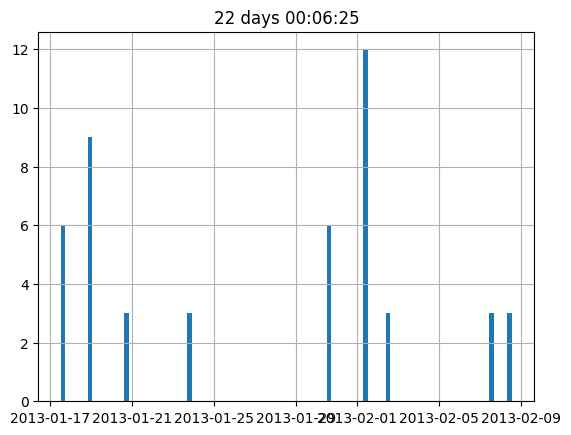

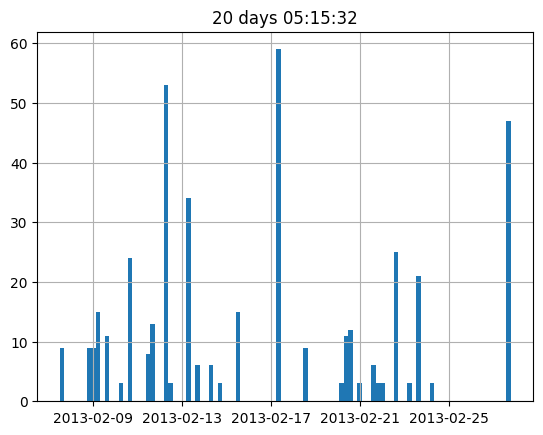

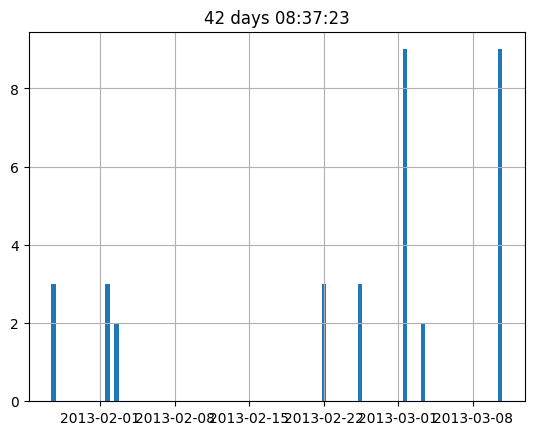

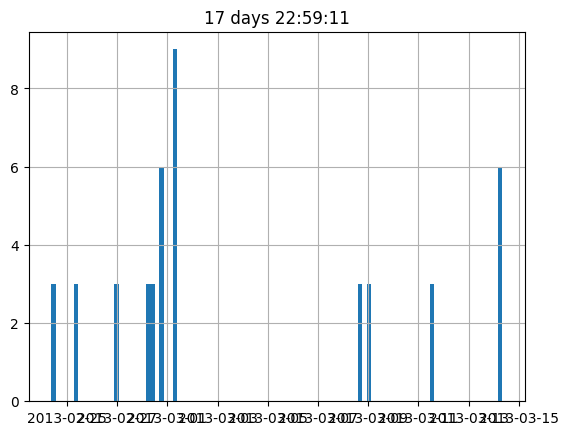

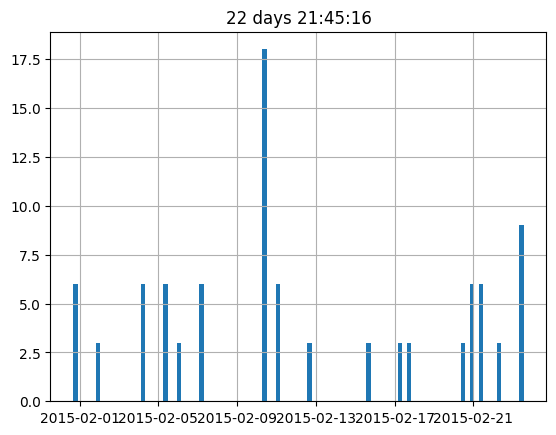

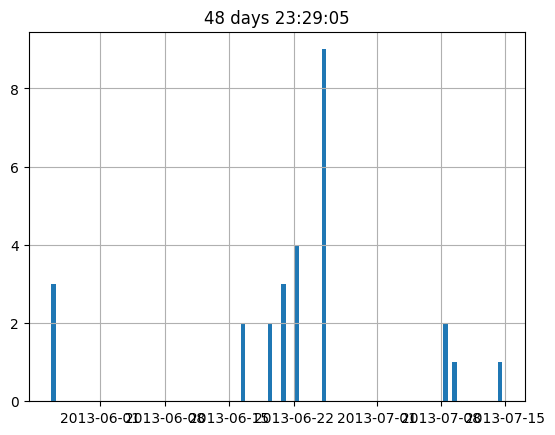

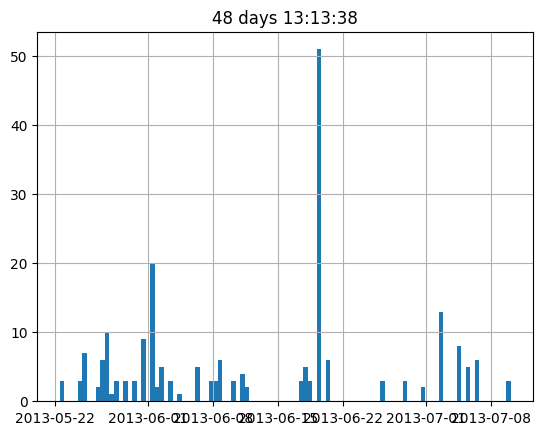

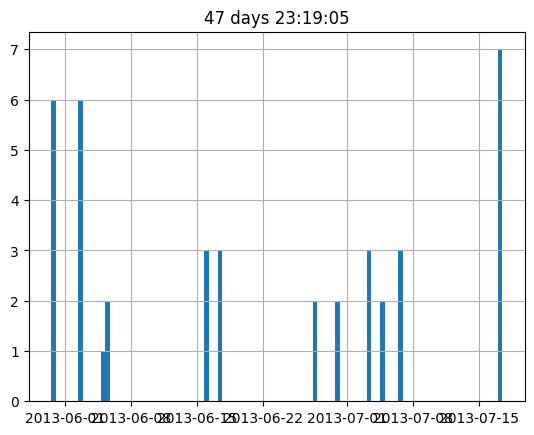

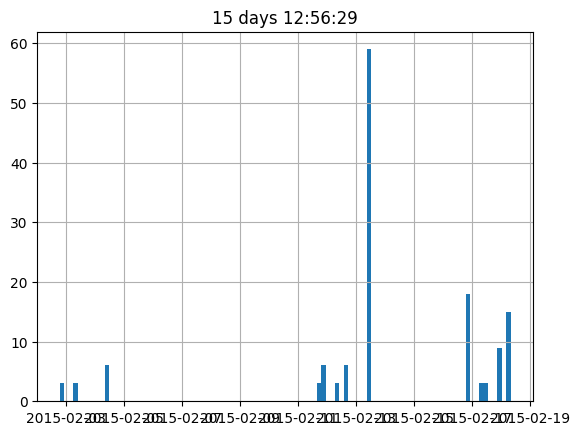

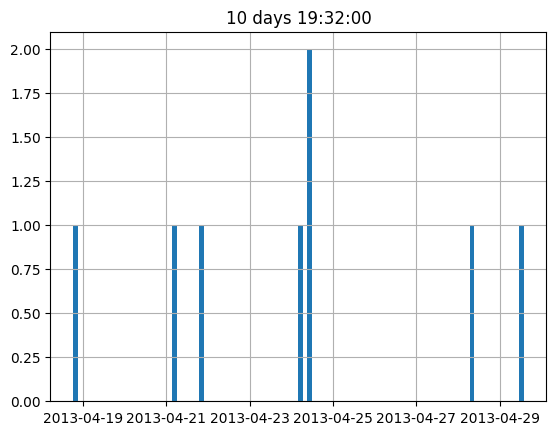

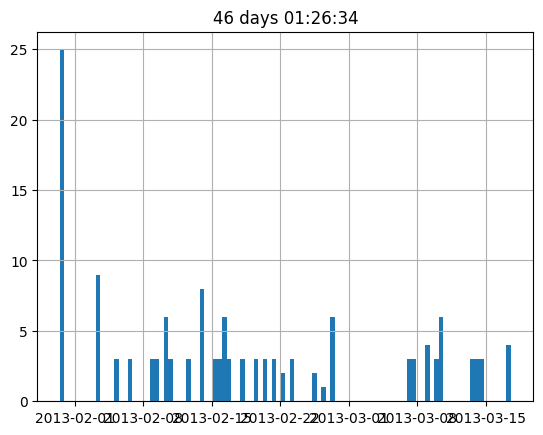

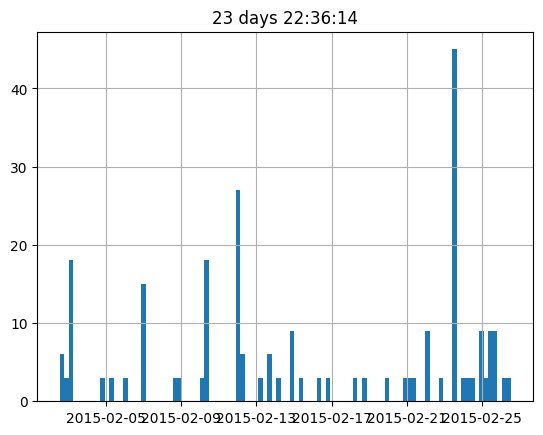

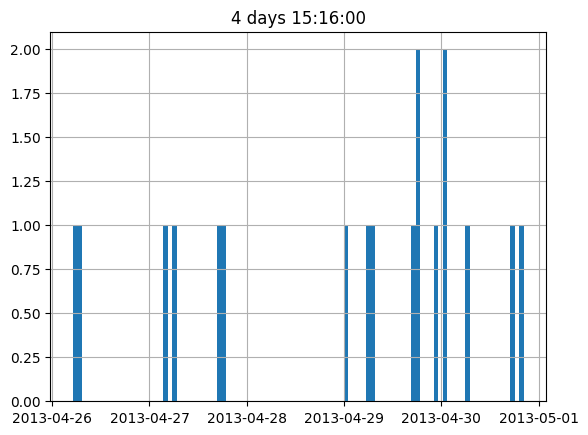

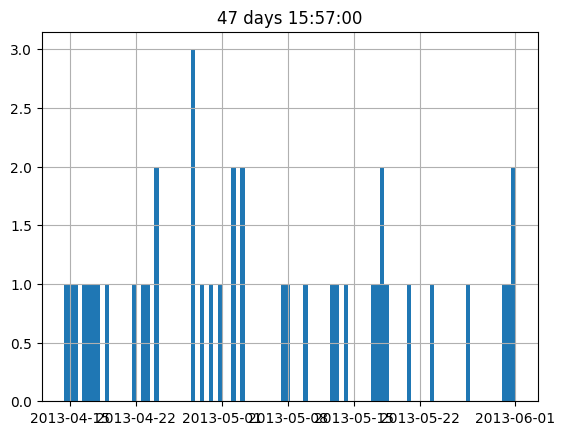

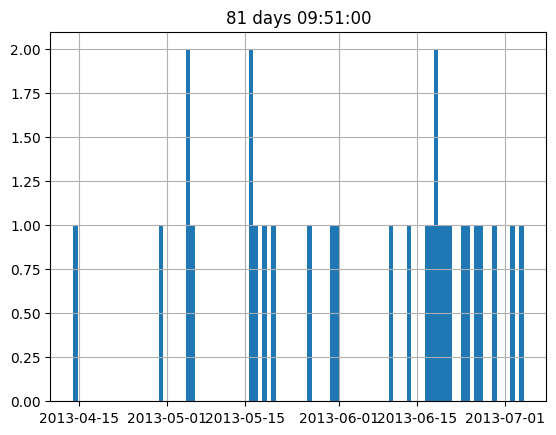

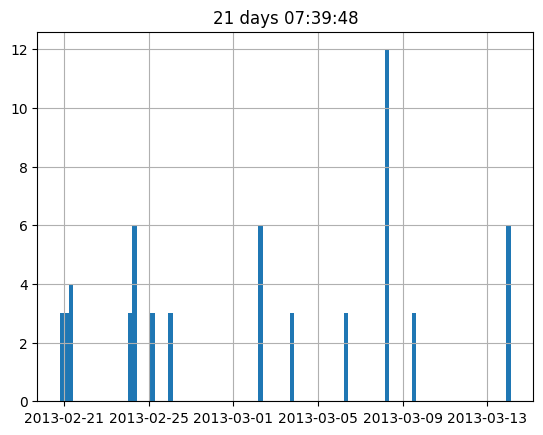

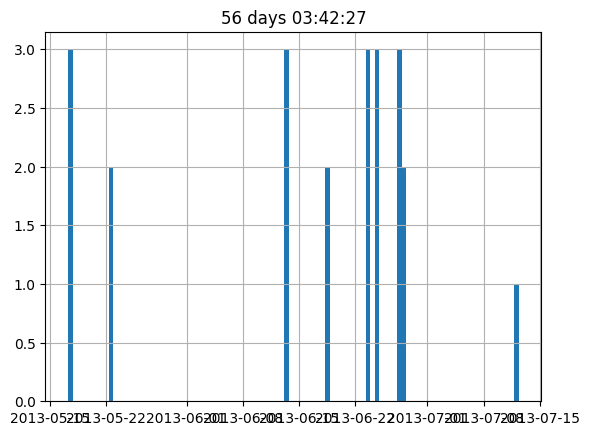

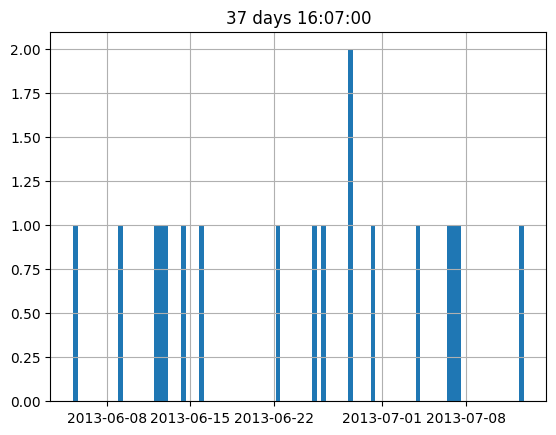

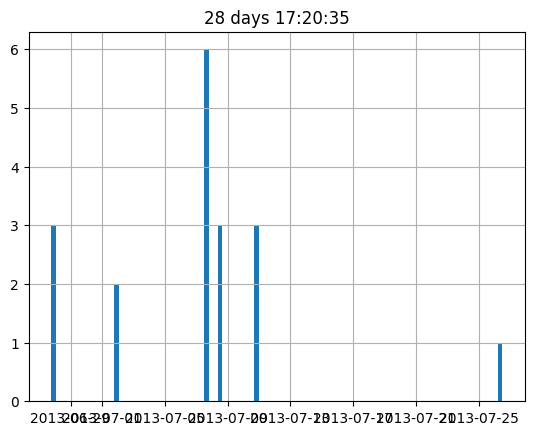

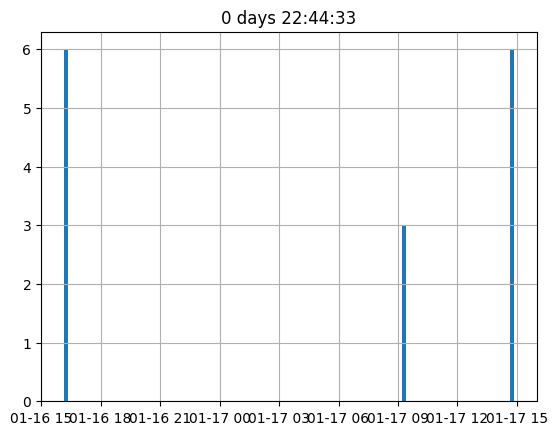

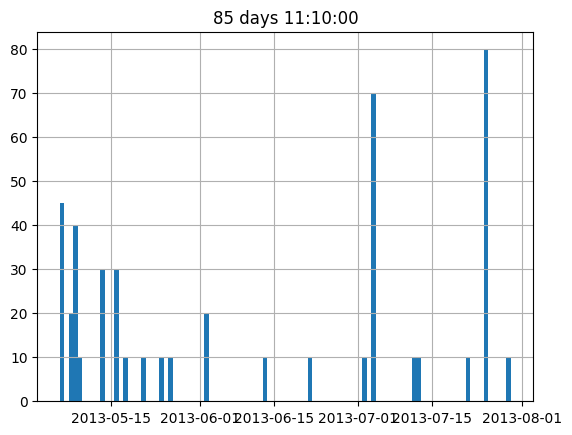

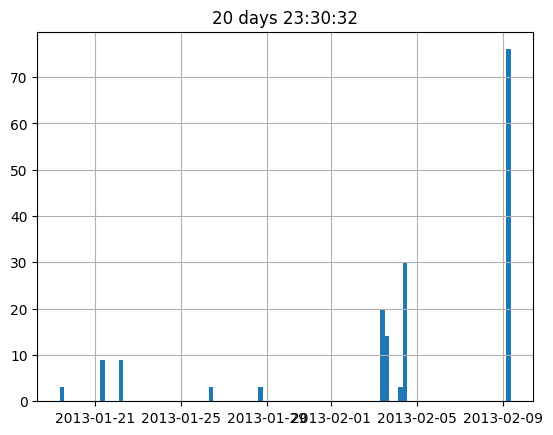

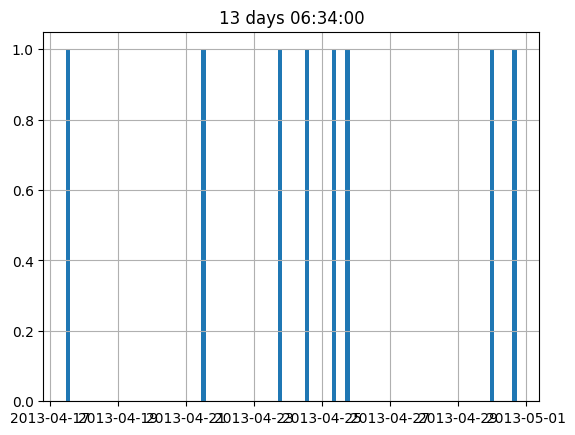

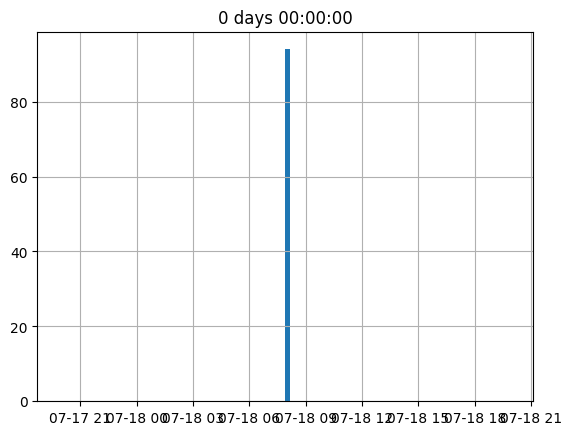

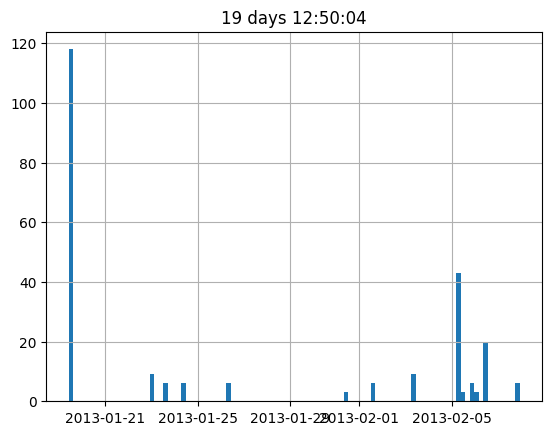

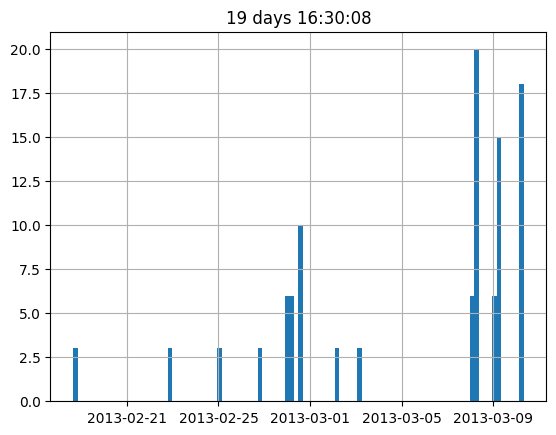

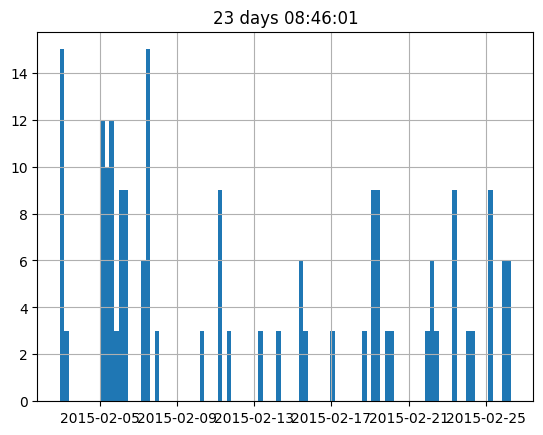

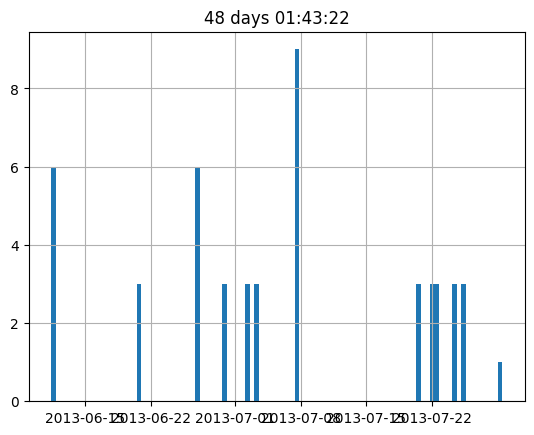

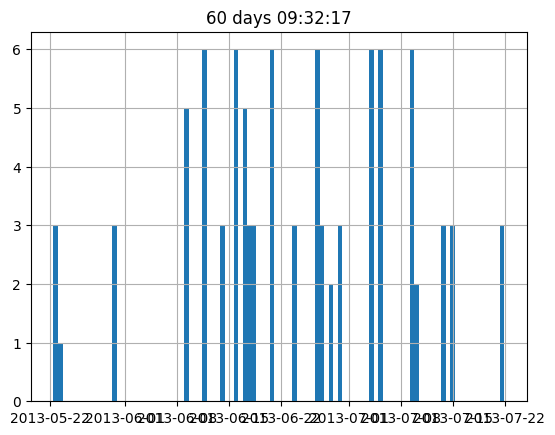

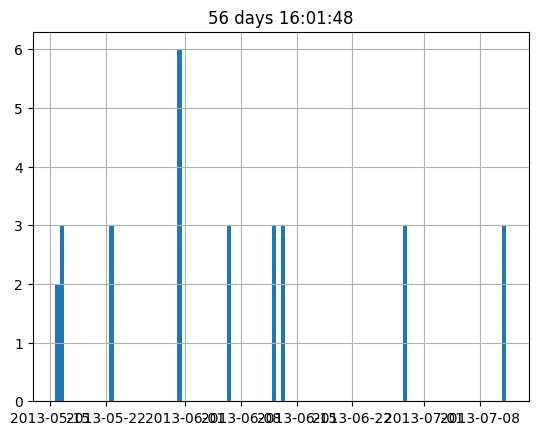

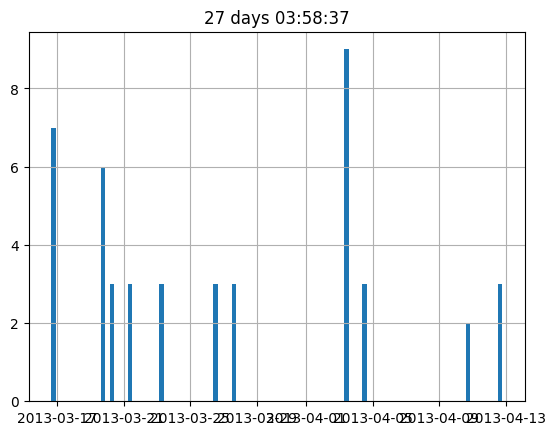

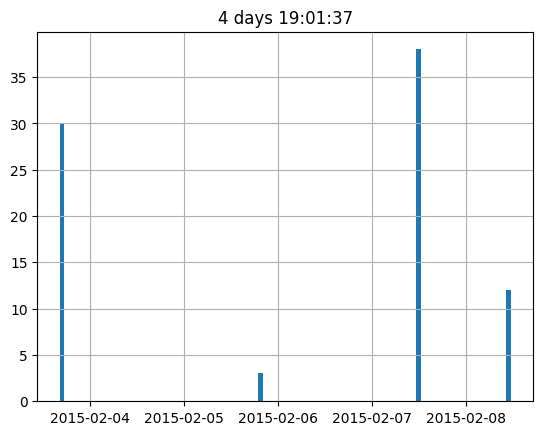

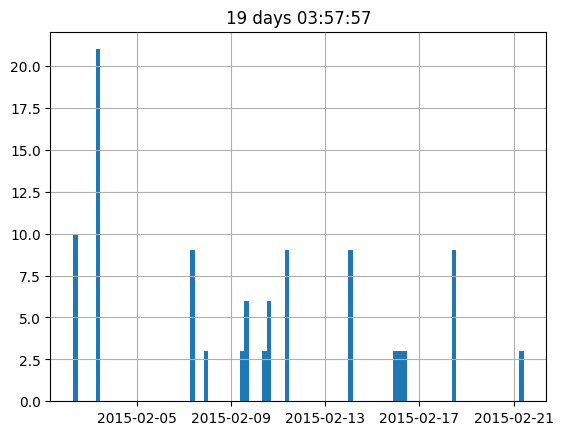

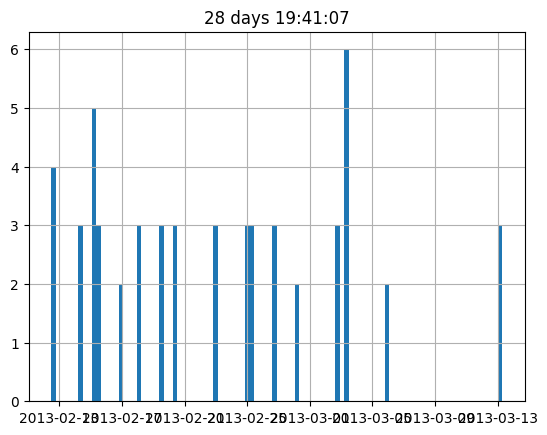

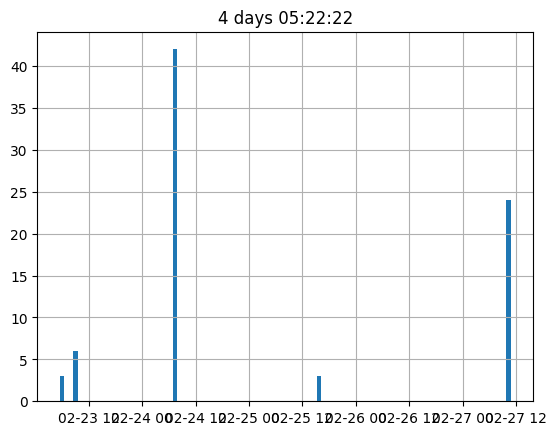

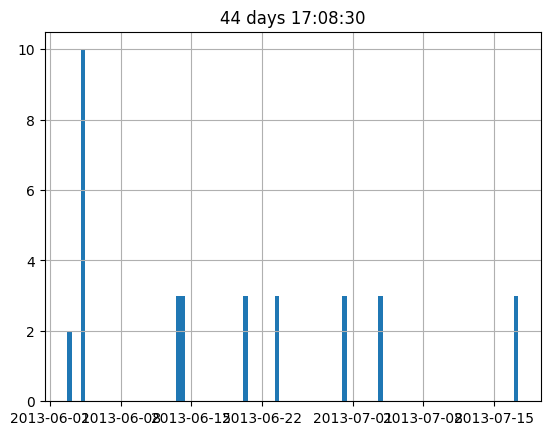

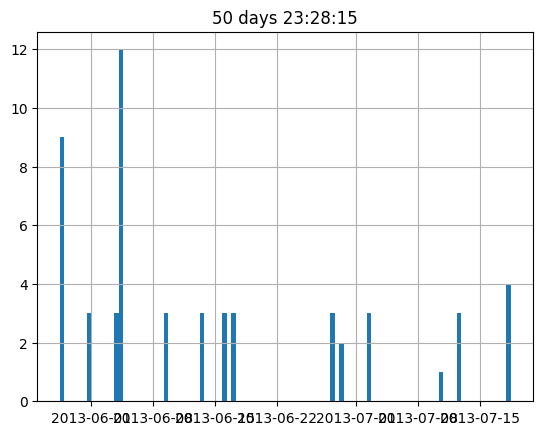

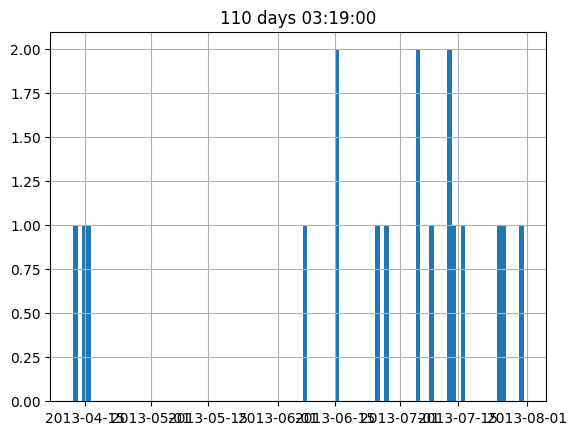

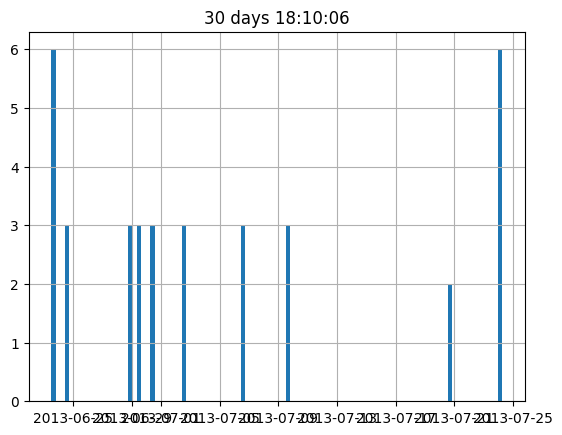

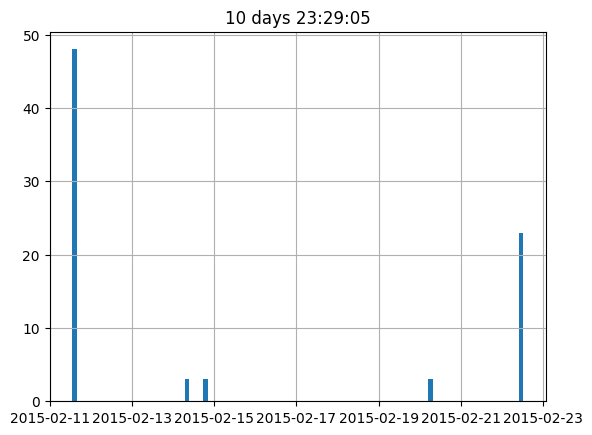

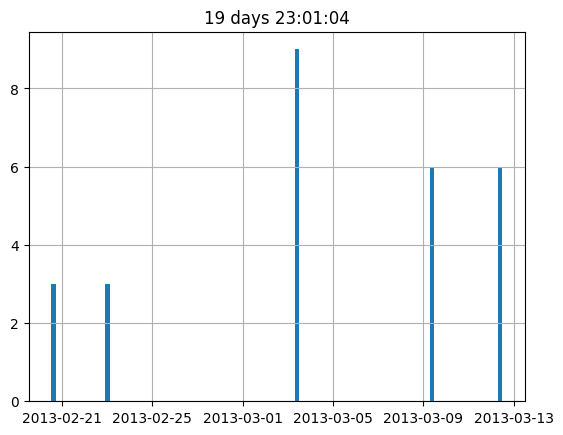

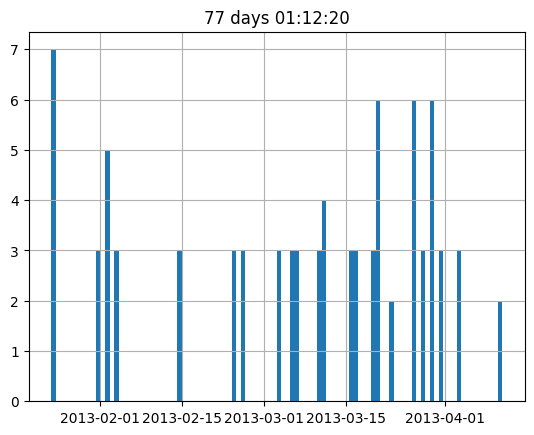

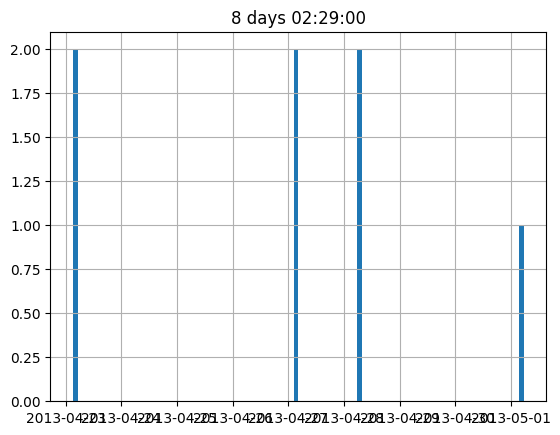

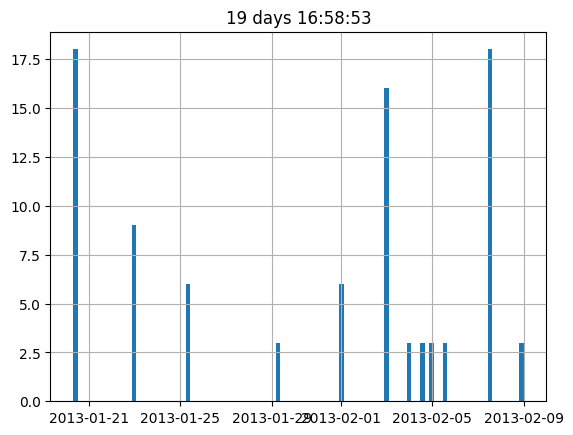

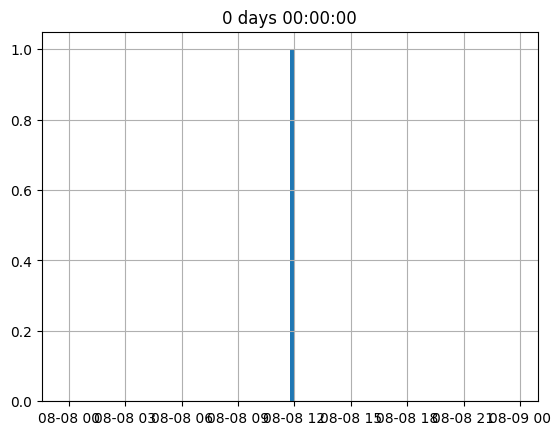

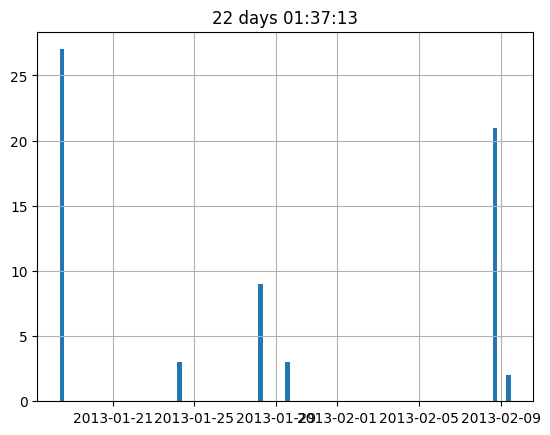

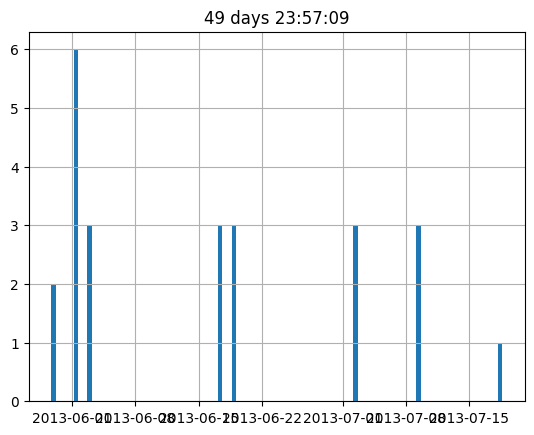

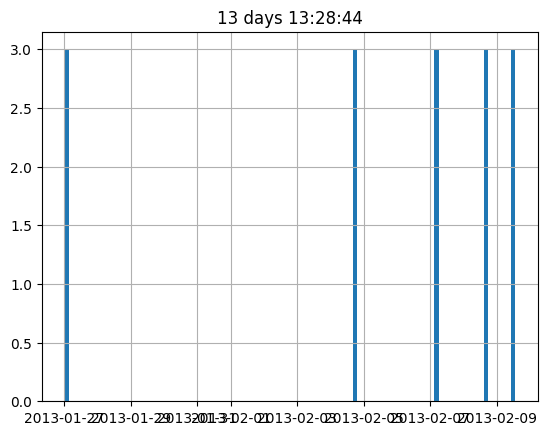

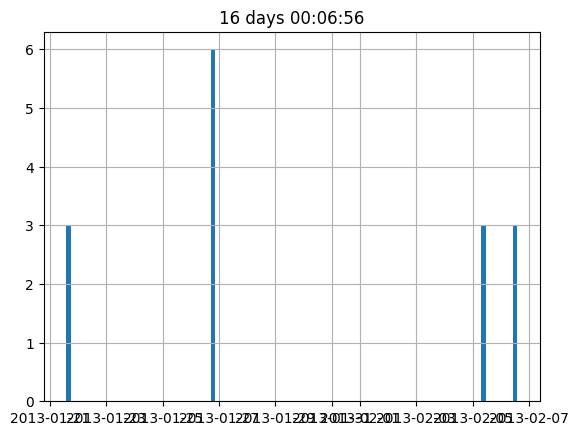

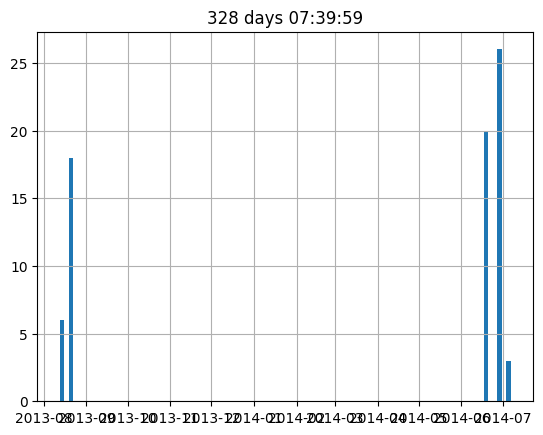

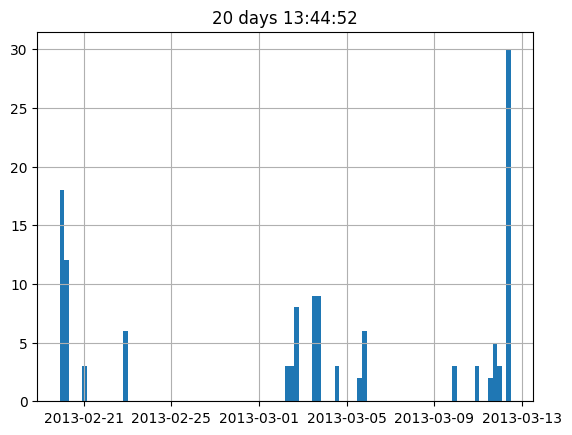

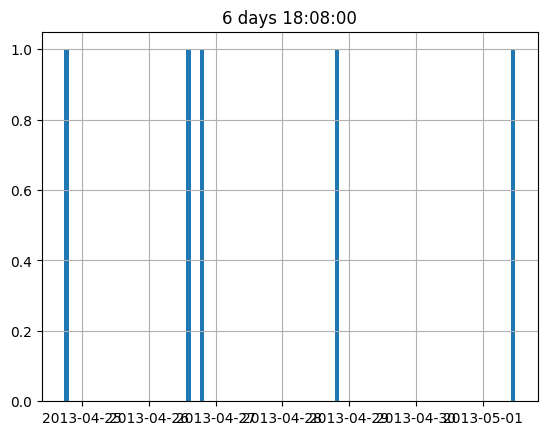

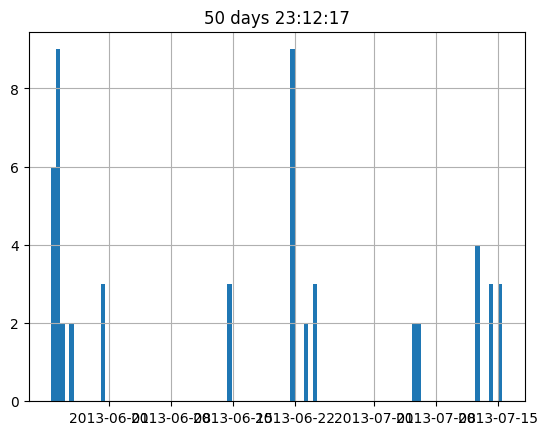

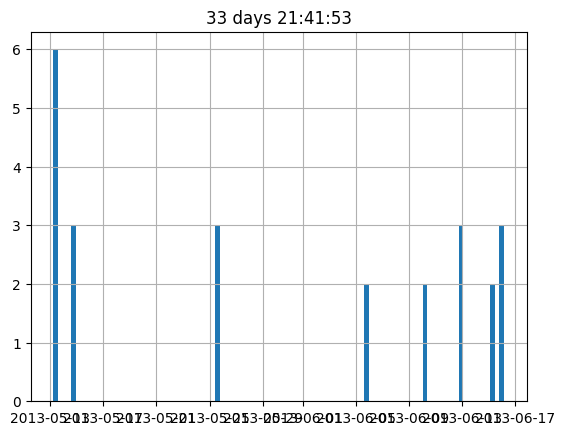

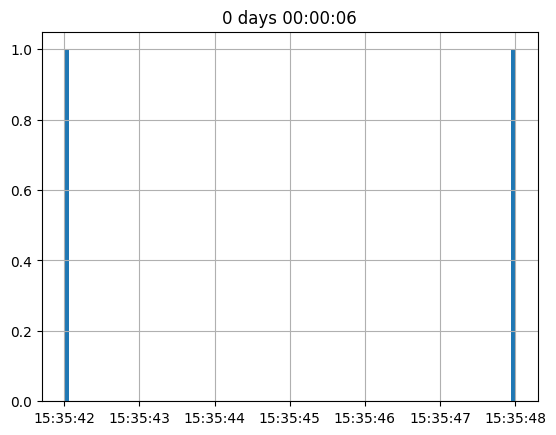

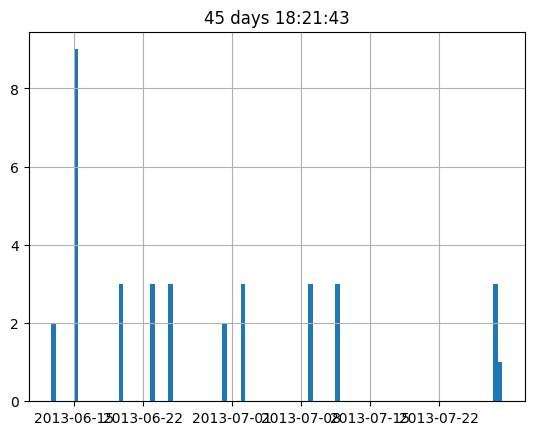

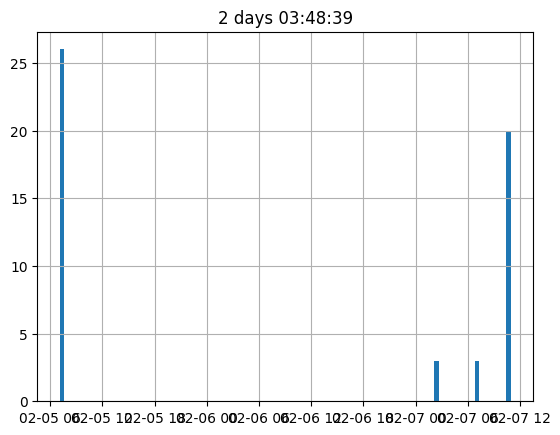

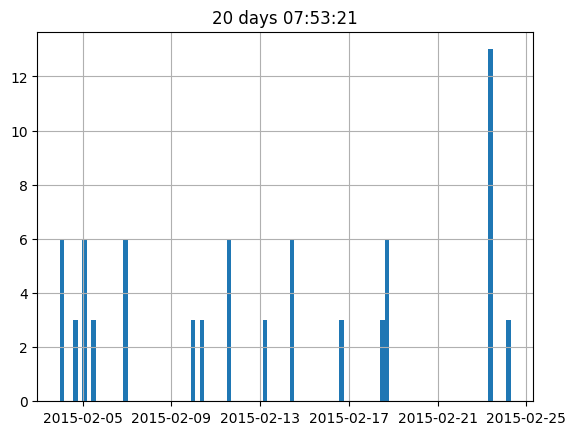

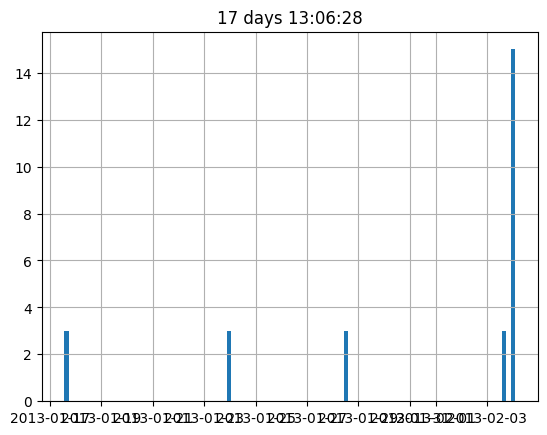

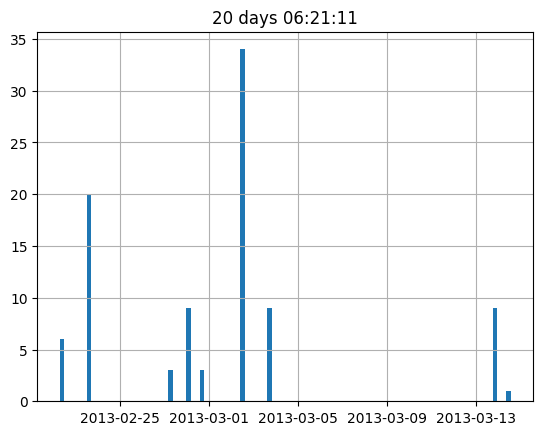

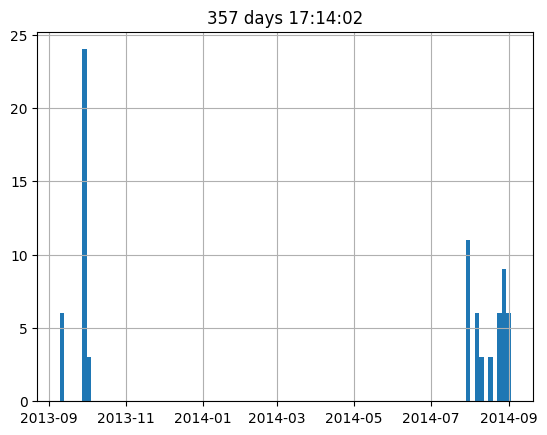

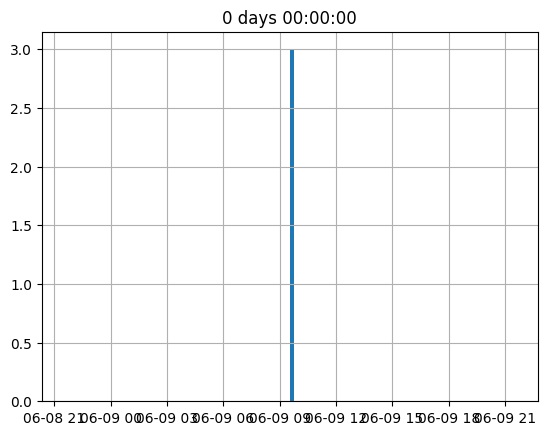

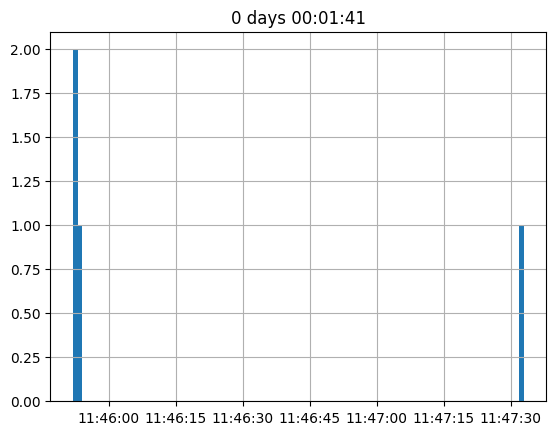

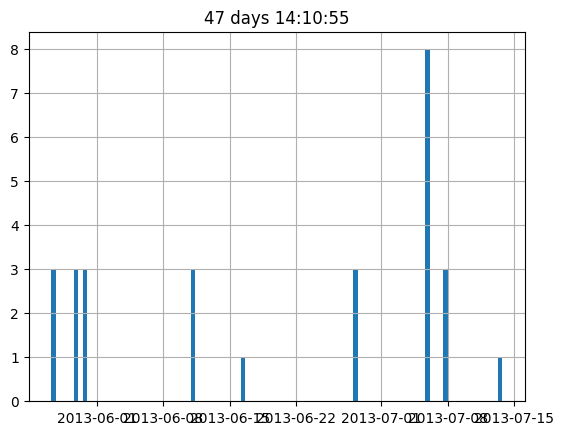

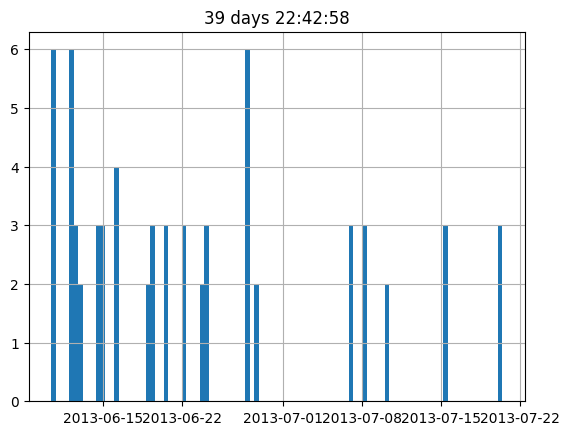

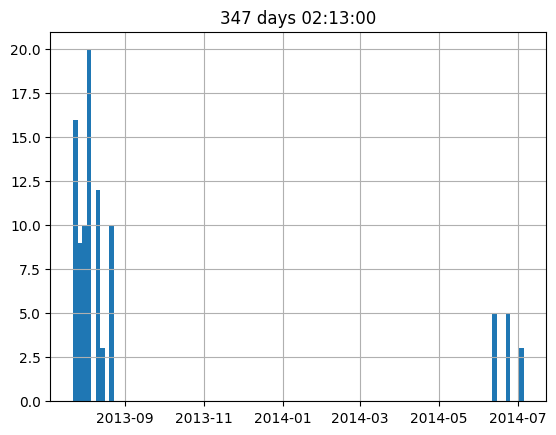

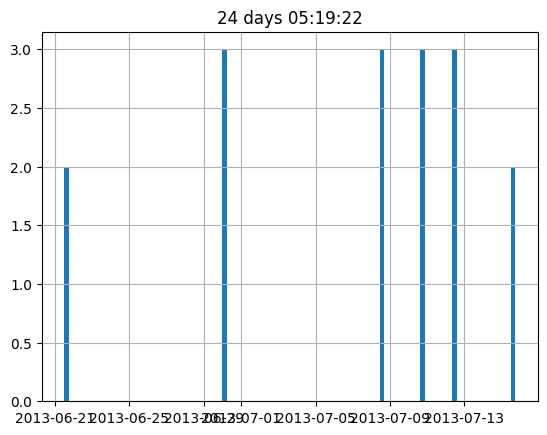

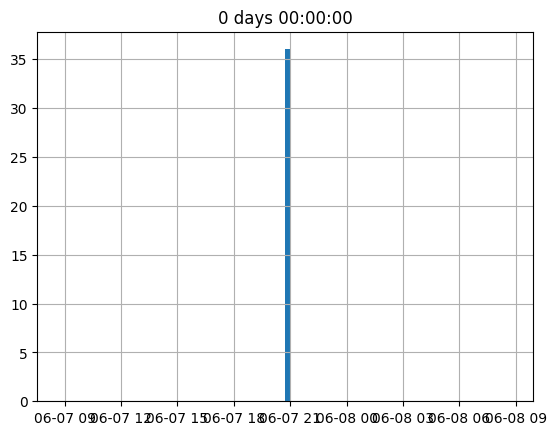

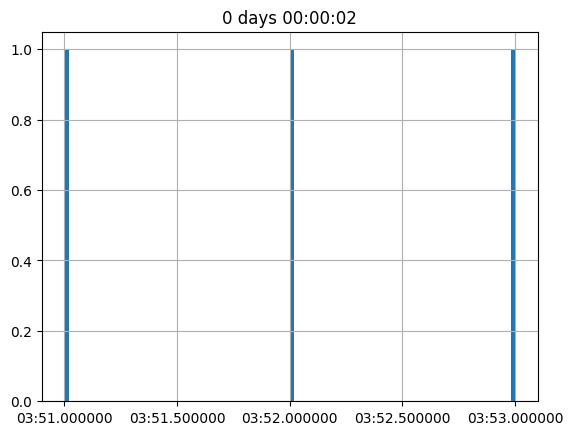

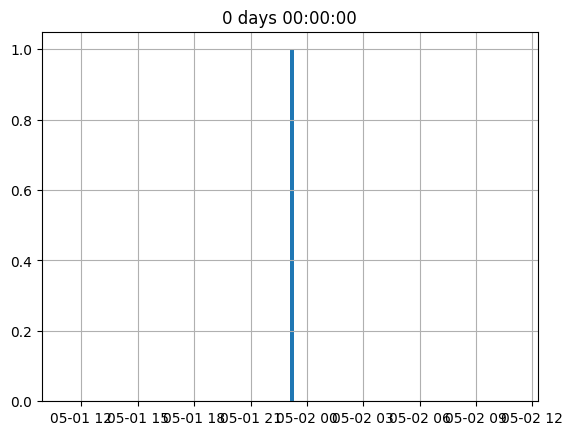

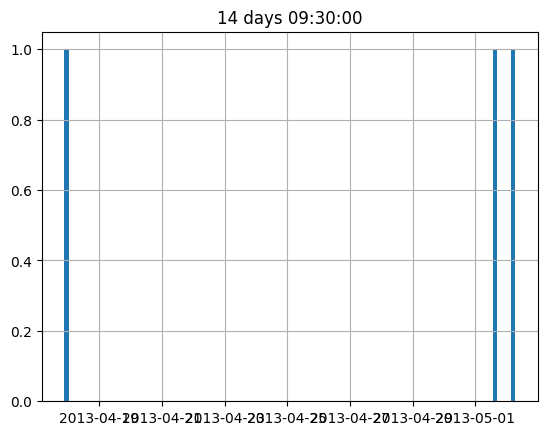

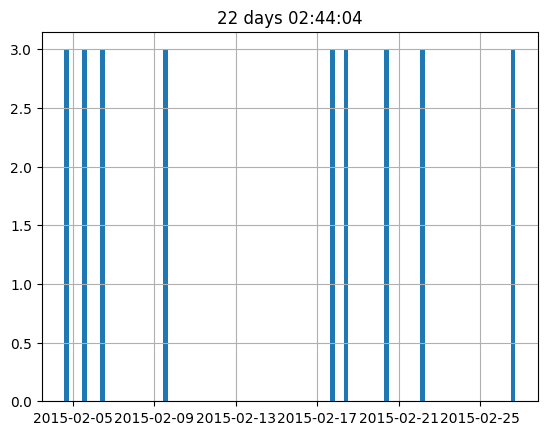

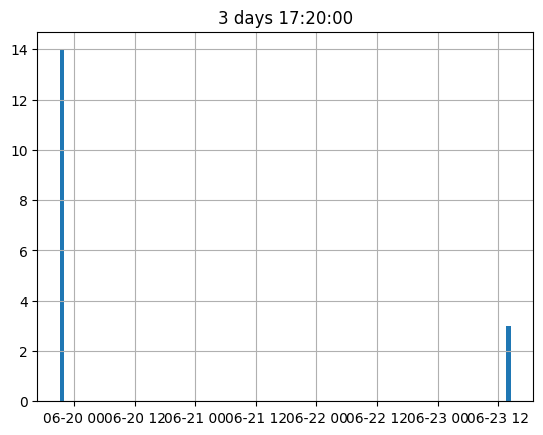

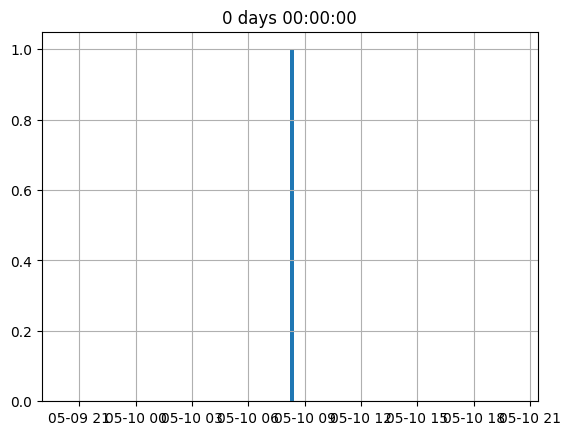

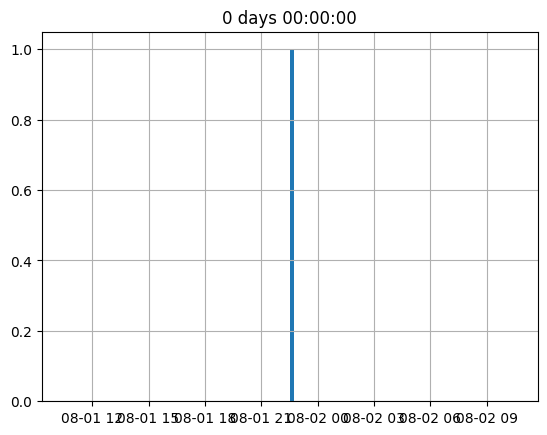

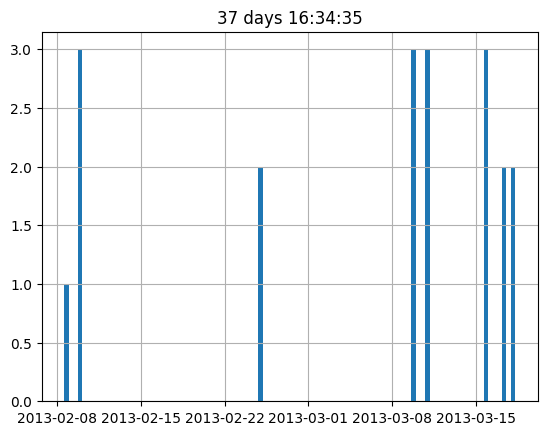

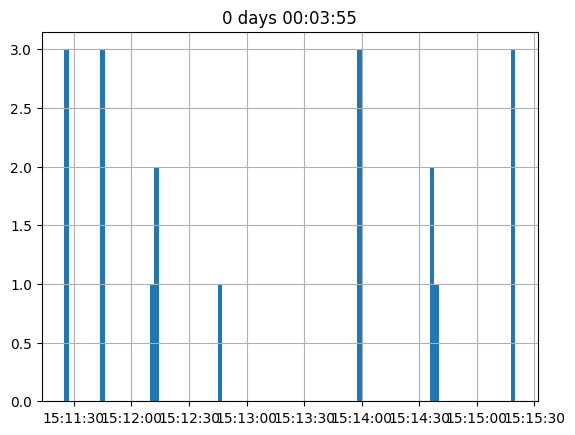

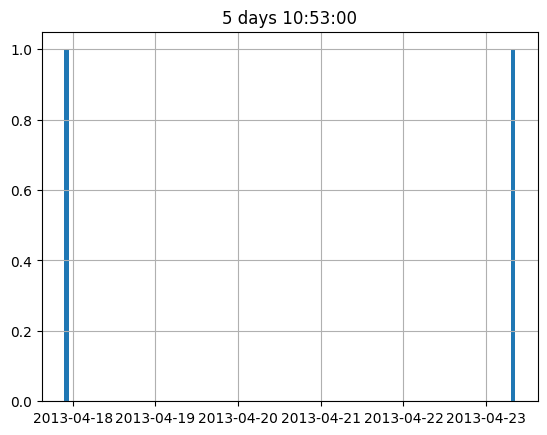

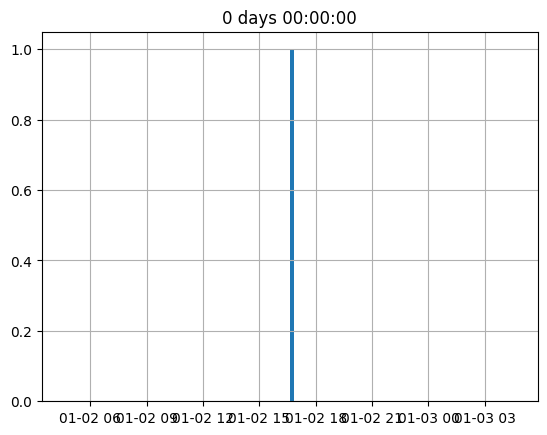

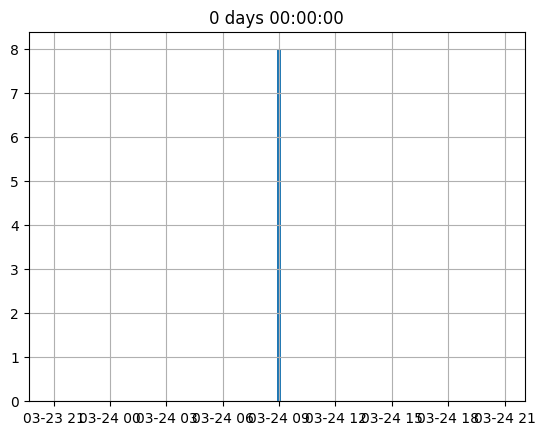

In [11]:
print(dfn["location"].unique())
for location in dfn["location"].unique():
    dfn[dfn["location"] == location].hist(column="datetime", bins=100)
    plt.title(str(dfn[dfn["location"] == location]["datetime"].max() - dfn[dfn["location"] == location]["datetime"].min()))
    plt.show()